**GROUP ASSIGNMENT - Group 7**
**CASE STUDY**

As a proficient derivatives trading expert at **Interactive Brokers Group (IBG)**, you manage trading accounts for clients who lack the time and expertise for direct stock and derivative market engagement.  
Your role involves providing **tailored equity price risk hedging solutions** and professional fund management services. At IBG, a leading brokerage firm, you leverage your **five years of experience** and the company's resources to deliver top-tier financial management.

Your responsibilities require in-depth market knowledge and advanced derivatives trading skills to navigate market volatility, minimize risks, and maximize returns for your clients. The management has tasked you with specific duties that demand your expertise in crafting sophisticated trading strategies.

---

**Group Members:**  
Davide Cadorin – s4153157  
Gianluca Fiorentino – s4152027  
Lorenzo Gumiero – s4252225  

**Course Code:** BAFI2081  
**Course Title:** Options, Futures & Risk Management  
**University:** RMIT University  
**Term:** Semester 1, 2025  

# Import

In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 6.9 MB/s eta 0:00:00


In [ ]:
# Data analysis and manipulation
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Statistics and distributions
from scipy.stats import norm

# Option pricing and optimization
from scipy.optimize import brentq

# Time series modeling and analysis
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Utilities
from itertools import combinations


# Task 1 _(20 marks)_

Any recommendation regarding option trading strategies requires understanding the behaviour of underlying stock prices.

**(a) [13 marks]**  
In this Task, you are required to evaluate how the **Northern Star Resources Ltd (NST.AX)** share price has performed over the last two years (i.e., from **March 2023 to March 2025**).  
Explore and discuss the primary reasons (e.g., company’s internal developments, the impact of both major world events and corporate events, etc.) for any significant trends or changes in its price that you have noticed over this period.

**(b) [7 marks]**  
What are the key sustainability initiatives undertaken by NST and how have they affected its stock price?

> **Note:**  
> Your response needs to be backed by data/statistics/charts and supporting citations.  
> **LSEG Workspace** should be your primary data source, which can be supplemented with data from the company's annual reports and other sources (if any).  
> In your discussion, make sure to compare the relative stock price performance and volatility of the Northern Star Resources Ltd to its peers, sector, and the **S&P/ASX 200 Index**.

---

# Nuova sezione

## 1.1 Share Price Performance Analysis: Northern Star Resources Ltd (NST.AX) (March 2023 – March 2025)


### Data Loading and Preprocessing (All Assets)

This block loads and prepares historical price data for:
- NST.AX (Northern Star Resources)
- .AXJO (S&P/ASX 200 index as benchmark)
- EVN.AX (Evolution Mining)
- GMD.AX (Genesis Minerals)

Each CSV is parsed with European date formatting and semicolon delimiters.
The price fields are cleaned by converting decimal commas to dots and cast to float.


In [ ]:
# Load NST (dd/mm/yyyy format)
nst = pd.read_csv("T1_NST.csv", sep=";", parse_dates=["Date"], dayfirst=True)
for col in ["Open", "High", "Low", "Close"]:
    nst[col] = nst[col].str.replace(",", ".").astype(float)
nst.set_index("Date", inplace=True)

# Load AXJO (Excel serial format)
axjo = pd.read_csv("T1_AXJO.csv", sep=";")
for col in ["Open", "High", "Low", "Close"]:
    axjo[col] = axjo[col].str.replace(",", ".").astype(float)
axjo["Date"] = pd.to_datetime(axjo["Date"], origin="1899-12-30", unit="D")
axjo.set_index("Date", inplace=True)

# Load EVN
evn = pd.read_csv("T1_EVN.csv", sep=";")
for col in ["Open", "High", "Low", "Close"]:
    evn[col] = evn[col].str.replace(",", ".").astype(float)
evn["Date"] = pd.to_datetime(evn["Date"], origin="1899-12-30", unit="D")
evn.set_index("Date", inplace=True)

# Load GMD
gmd = pd.read_csv("T1_GMD.csv", sep=";")
for col in ["Open", "High", "Low", "Close"]:
    gmd[col] = gmd[col].str.replace(",", ".").astype(float)
gmd["Date"] = pd.to_datetime(gmd["Date"], origin="1899-12-30", unit="D")
gmd.set_index("Date", inplace=True)


# Drop NA from AXJO, NST and GMD

axjo = axjo.dropna()
nst = nst.dropna()
gmd = gmd.dropna()

# Quick preview
for df, name in zip([nst, axjo, evn, gmd], ["NST", "AXJO", "EVN", "GMD"]):
    print(f"{name}: {df.index.dtype}, shape = {df.shape}")
    print(df.head(2))


NST: datetime64[ns], shape = (528, 5)
             Open   High    Low  Close   Volume
Date                                           
2023-03-01  10.21  10.67  10.21  10.66  6680960
2023-03-02  11.00  11.20  10.81  10.97  6649594
AXJO: datetime64[ns], shape = (528, 5)
              Open    High     Low   Close       Volume
Date                                                   
2023-03-01  7258.4  7271.4  7216.3  7251.6  668230171.0
2023-03-02  7251.6  7282.4  7242.2  7255.4  987080021.0
EVN: datetime64[ns], shape = (529, 5)
            Open  High   Low  Close      Volume
Date                                           
2023-03-01  2.75  2.86  2.73   2.83   8466892.0
2023-03-02  2.87  2.94  2.85   2.94  14464218.0
GMD: datetime64[ns], shape = (521, 5)
             Open   High    Low  Close    Volume
Date                                            
2023-03-01  1.130  1.170  1.125   1.16  512044.0
2023-03-02  1.175  1.175  1.130   1.14  650562.0


### Price Trend Analysis – NST.AX

This chart shows the closing price of NST.AX with 20-day and 100-day simple moving averages (SMA).  
It helps highlight medium and long-term trends in price evolution.

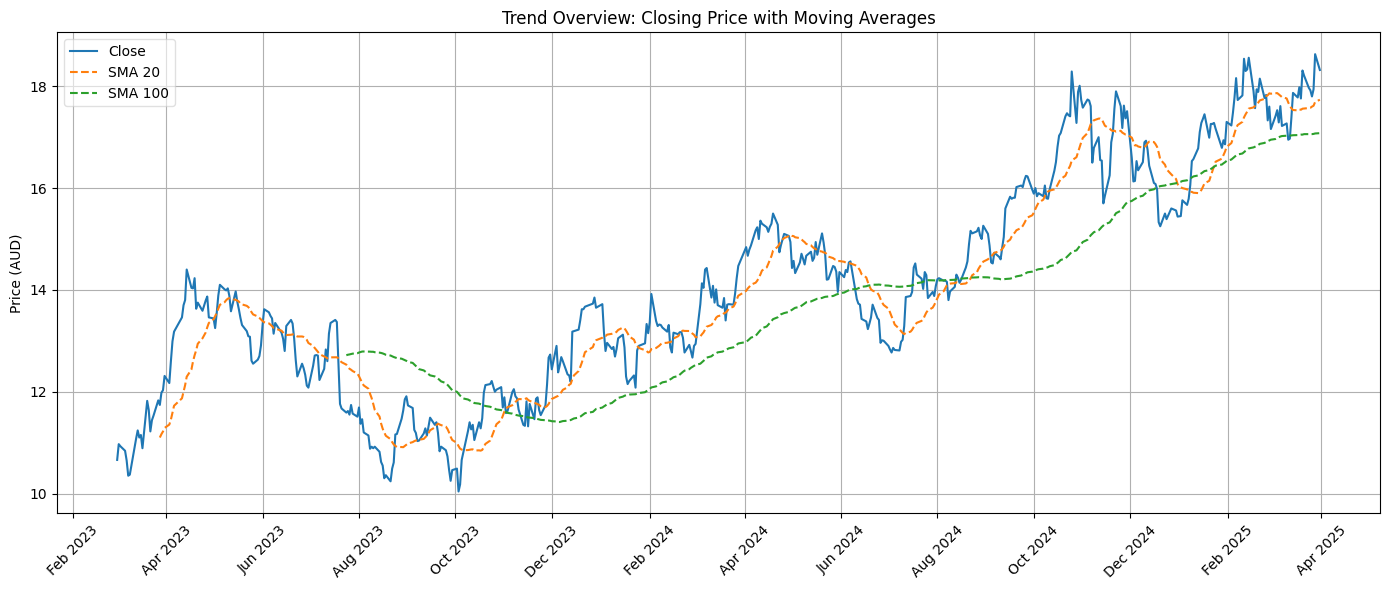

In [ ]:
# Make sure moving averages are defined
nst["SMA_20"] = nst["Close"].rolling(window=20).mean()
nst["SMA_100"] = nst["Close"].rolling(window=100).mean()

# Import matplotlib.dates if not already
import matplotlib.dates as mdates

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(nst.index, nst["Close"], label="Close", color="#1f77b4", linewidth=1.5)
ax.plot(nst.index, nst["SMA_20"], label="SMA 20", linestyle="--", color="#ff7f0e")
ax.plot(nst.index, nst["SMA_100"], label="SMA 100", linestyle="--", color="#2ca02c")

ax.set_title("Trend Overview: Closing Price with Moving Averages")
ax.set_ylabel("Price (AUD)")
ax.legend(loc="upper left", framealpha=0.6)
ax.grid(True)

# X-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Liquidity Analysis – Volume Histogram with Spike Intensity Colors

This plot shows the daily trading volume of NST.AX using a color-coded histogram.

Each bar represents the trading volume on a given day. The color of each bar reflects the **intensity of the volume spike** using a normalized z-score scale:

- 🟩 **Green**: below-average or normal volume  
- 🟨 **Yellow**: moderately high volume  
- 🟥 **Red**: extreme volume spikes (typically > 2 standard deviations above average)

The colorbar on the right provides a reference scale based on the z-score transformation of volume. This visual format helps quickly identify abnormal trading days that may be linked to impactful market events.



<ipython-input-5-f9b00be65fc0>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn_r")  # Green (low) to Red (high)


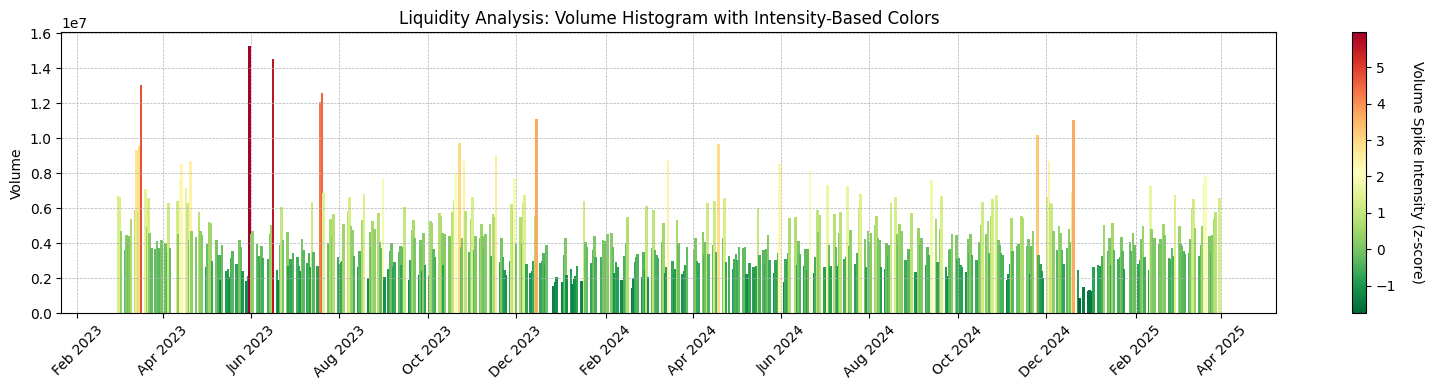

In [ ]:
# Compute mean and standard deviation of volume
volume_mean = nst["Volume"].mean()
volume_std = nst["Volume"].std()

# Calculate z-scores for volume spikes
z_scores = (nst["Volume"] - volume_mean) / volume_std

# Normalize for color mapping
norm = Normalize(vmin=z_scores.min(), vmax=z_scores.max())
cmap = cm.get_cmap("RdYlGn_r")  # Green (low) to Red (high)

# Assign color to each bar based on z-score
bar_colors = [cmap(norm(z)) for z in z_scores]

# Plot histogram
fig, ax = plt.subplots(figsize=(16, 4))
bars = ax.bar(nst.index, nst["Volume"], color=bar_colors, width=1.8)

# Add colorbar as reference for spike intensity
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Volume Spike Intensity (z-score)", rotation=270, labelpad=20)

# Formatting
ax.set_title("Liquidity Analysis: Volume Histogram with Intensity-Based Colors")
ax.set_ylabel("Volume")
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Rolling Volatility – NST.AX

This plot shows the 30-day rolling volatility of NST.AX's returns, cropped to the most recent period (2024–2025).  
It highlights periods of increased risk or instability.

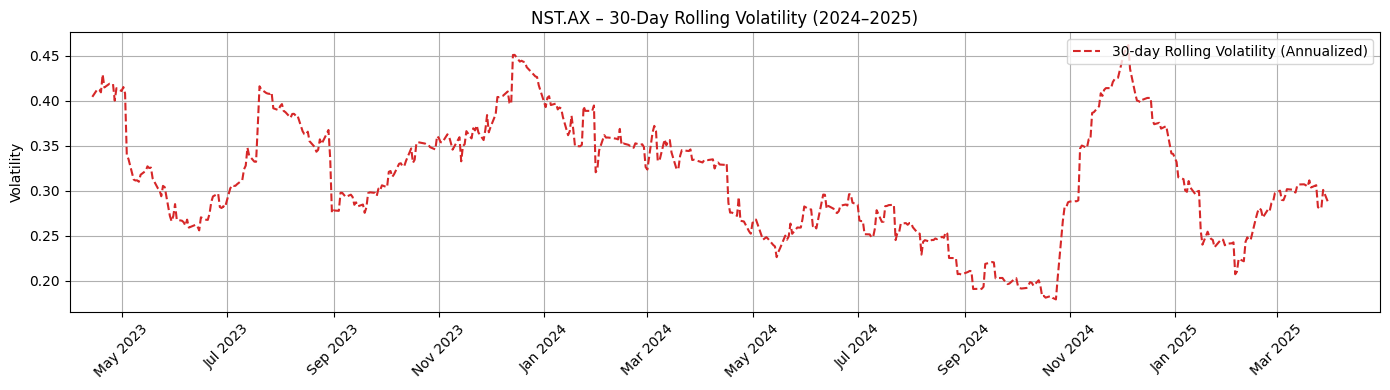

In [ ]:
# Calculate daily returns (simple returns)
nst["Return"] = nst["Close"].pct_change()

# Calculate 30-day rolling volatility: standard deviation of daily returns
nst["RollingVol_30"] = nst["Return"].rolling(window=30).std()

# Calculate annualized 30-day rolling volatility: daily std * sqrt(252 trading days)
nst["RollingVol_30_ann"] = nst["RollingVol_30"] * np.sqrt(252)

# Plot both daily and annualized rolling volatility
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(nst.index, nst["RollingVol_30_ann"], color="tab:red", linestyle="--", label="30-day Rolling Volatility (Annualized)")

# Focus only on the desired period (2024–2025)
ax.set_xlim(pd.to_datetime("2023-04-01"), pd.to_datetime("2025-04-30"))
ax.set_title("NST.AX – 30-Day Rolling Volatility (2024–2025)")
ax.set_ylabel("Volatility")
ax.legend(loc="upper right")
ax.grid(True)

# X-axis formatting for dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Event Spike Definition – Methodological Notes

This section explains how we identify **Price Spikes**, **Volume Spikes**, and **Both Spikes** in the trading history of NST.AX. These thresholds help detect abnormal movements that might signal relevant market events such as earnings announcements, acquisitions, or external shocks.

---

**Price Spike**

**Definition:**

A day is classified as a *Price Spike* if the absolute daily return is greater than 5%.

- Formula:  
  Return = (Close[t] - Close[t-1]) / Close[t-1]  
  Spike condition: **|Return| > 5%**

**Why 5%?**  
A ±5% threshold is commonly used in event studies to detect unusually large market moves while avoiding normal price fluctuations.

---

**Volume Spike**

**Definition:**

A day is classified as a *Volume Spike* if the trading volume exceeds the average volume by more than two standard deviations.

- Formula:  
  Spike condition: **Volume > Average Volume + 2 × Standard Deviation**

**Why this approach?**  
This statistical filter highlights days with unusually high trading activity, often linked to institutional reactions or breaking news.

---

**Both Spikes**

**Definition:**

A *Both Spike* is when a Price Spike and Volume Spike occur on the same day.

These are usually the most relevant events, as they suggest both a sharp price reaction and intense market participation.

---

**Interpretation Notes**

- Not every spike is linked to an actual event — always investigate the context.
- Combined spikes are strong signals of market-moving news.




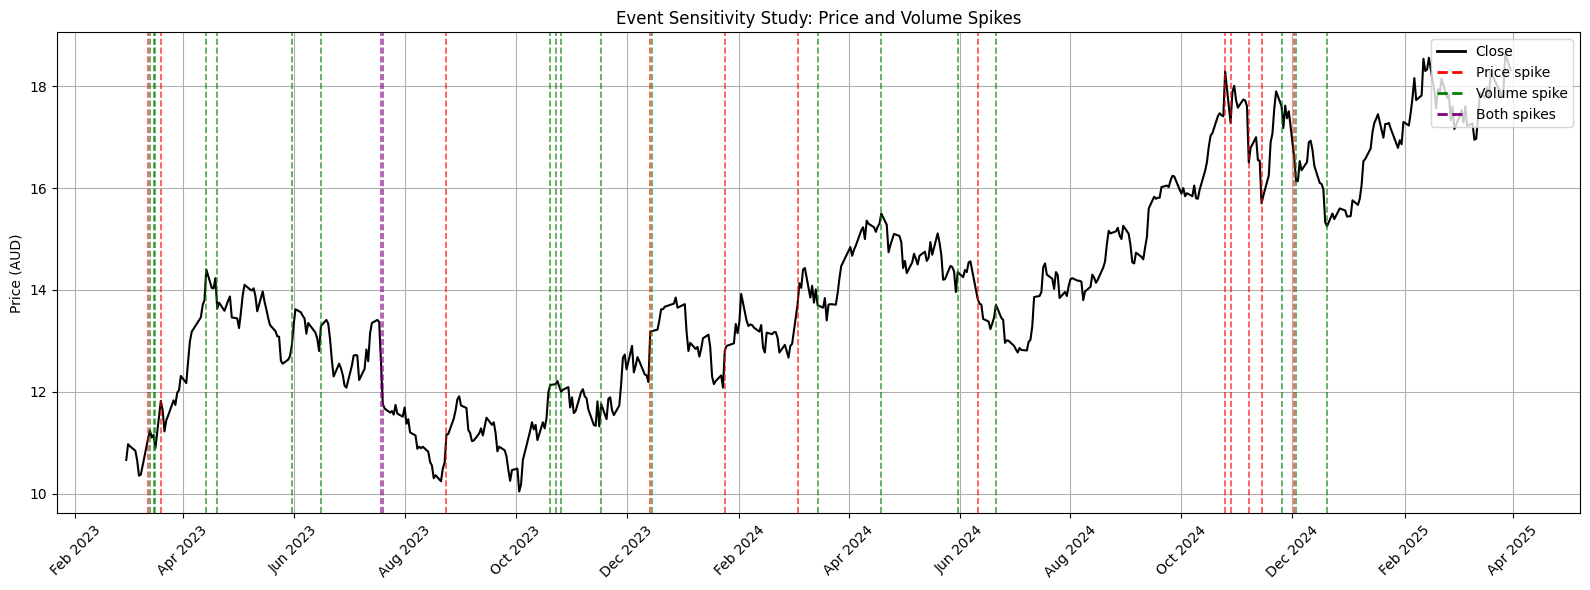

In [ ]:
# --- Spike Classification ---

# Calculate daily returns
nst["Return"] = nst["Close"].pct_change()

# Compute volume statistics
volume_mean = nst["Volume"].mean()
volume_std = nst["Volume"].std()

# Define thresholds
price_threshold = 0.05
volume_threshold = volume_mean + 2 * volume_std

# Identify spike days
only_price = nst[abs(nst["Return"]) > price_threshold].index
only_volume = nst[nst["Volume"] > volume_threshold].index
both = only_price.intersection(only_volume)

# --- Build the spike plot ---

from matplotlib.lines import Line2D

# Define colors for each spike type
event_colors = {
    'price spike': 'red',
    'volume spike': 'green',
    'both': 'purple'
}

# Initialize plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot closing price
ax.plot(nst.index, nst["Close"], color="black", linewidth=1.5)

# Build event dictionary
event_dict = {}
for date in only_price:
    event_dict[date] = "price spike"
for date in only_volume:
    event_dict[date] = "volume spike"
for date in both:
    event_dict[date] = "both"

# Plot vertical lines for events
for date, tipo in event_dict.items():
    color = event_colors[tipo]
    ax.axvline(x=date, color=color, linestyle="--", linewidth=1.2, alpha=0.7)

# Custom legend
legend_lines = [
    Line2D([0], [0], color="black", lw=2, label="Close"),
    Line2D([0], [0], color="red", linestyle="--", lw=2, label="Price spike"),
    Line2D([0], [0], color="green", linestyle="--", lw=2, label="Volume spike"),
    Line2D([0], [0], color="purple", linestyle="--", lw=2, label="Both spikes")
]

# Title, legend, axis formatting
ax.set_title("Event Sensitivity Study: Price and Volume Spikes")
ax.set_ylabel("Price (AUD)")
ax.legend(handles=legend_lines, loc="upper right")
ax.grid(True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Event Table: Summary of Detected Price and Volume Spikes

This table lists all dates where NST.AX experienced a **price spike** (|return| > 5%), **volume spike** (volume > mean + 2 × std), or **both** on the same day.
- Each row shows the event type, closing price, return, and volume for that date.
- **"News Description"** and **"Source/Link"** columns are intended to be filled manually, once each event has been investigated and classified.
- Average daily return and volume are shown below for reference.

In [ ]:
# Calculate daily return if not already present
nst["Return"] = nst["Close"].pct_change()

# Define spike thresholds
price_threshold = 0.05
volume_mean = nst["Volume"].mean()
volume_std = nst["Volume"].std()
volume_threshold = volume_mean + 2 * volume_std

# Identify spike dates
only_price = nst[abs(nst["Return"]) > price_threshold].index
only_volume = nst[nst["Volume"] > volume_threshold].index
both = only_price.intersection(only_volume)

# Create event dictionary
event_dict = {}
for date in only_price:
    event_dict[date] = "Price Spike"
for date in only_volume:
    event_dict[date] = "Volume Spike"
for date in both:
    event_dict[date] = "Both Spikes"

# Build table
event_table = []
for date, event_type in sorted(event_dict.items()):
    close = round(nst.loc[date, "Close"], 2)
    ret = round(nst.loc[date, "Return"], 2)
    volume = int(nst.loc[date, "Volume"])
    event_table.append({
        "Date": date.strftime("%Y-%m-%d"),
        "Event Type": event_type,
        "Close Price": close,
        "Return (%)": ret,
        "Volume": volume,
        "News Description": "",
        "Source/Link": ""
    })

# Create DataFrame
event_df = pd.DataFrame(event_table)

# Print average return and volume (formatted for display)
average_return = round(nst["Return"].mean() * 100, 4)
average_volume = int(volume_mean)
print(f"Average Daily Return: {average_return} %")
print(f"Average Daily Volume: {average_volume}")

# Show full table
event_df  # or display(event_df) if in notebook



Average Daily Return: 0.1231 %
Average Daily Volume: 4182857


Date    Event Type  Close Price  Return (%)    Volume  \
0   2023-03-13   Price Spike        11.08        0.05   5886892   
1   2023-03-14  Volume Spike        11.24        0.01   9296115   
2   2023-03-16  Volume Spike        11.15        0.00   9555325   
3   2023-03-17  Volume Spike        10.89       -0.02  13054940   
4   2023-03-20   Price Spike        11.82        0.09   7072420   
5   2023-04-14  Volume Spike        14.40        0.04   8510354   
6   2023-04-20  Volume Spike        13.63       -0.04   8722513   
7   2023-05-31  Volume Spike        12.91        0.02  15274780   
8   2023-06-16  Volume Spike        13.29        0.04  14522446   
9   2023-07-19   Both Spikes        12.59       -0.06  12078612   
10  2023-07-20   Both Spikes        11.76       -0.07  12602816   
11  2023-08-24   Price Spike        11.16        0.05   5293279   
12  2023-10-20  Volume Spike        12.13        0.01   7975418   
13  2023-10-23  Volume Spike        12.15        0.00   9701075   
14  2023-10-26  Volume Spike        12.00       -0.01   8718497   
15  2023-11-17  Volume Spike        11.76        0.04   8989352   
16  2023-12-14   Price Spike        13.18        0.08   5580480   
17  2023-12-15  Volume Spike        13.19        0.00  11064528   
18  2024-01-24   Price Spike        12.81        0.06   4406254   
19  2024-03-04   Price Spike        13.72        0.06   3731845   
20  2024-03-15  Volume Spike        13.70       -0.02   8761633   
21  2024-04-19  Volume Spike        15.50        0.01   9637152   
22  2024-05-31  Volume Spike        14.35        0.03   8537122   
23  2024-06-11   Price Spike        13.82       -0.05   5515963   
24  2024-06-21  Volume Spike        13.71        0.02   8192285   
25  2024-10-25   Price Spike        18.29        0.05   6543358   
26  2024-10-28   Price Spike        17.28       -0.06   6736661   
27  2024-11-07   Price Spike        16.50       -0.06   5428238   
28  2024-11-14   Price Spike        15.70       -0.05   5530902   
29  2024-11-25  Volume Spike        17.61       -0.02  10177915   
30  2024-12-02   Price Spike        16.59       -0.05   6635964   
31  2024-12-03  Volume Spike        16.13       -0.03   8689337   
32  2024-12-20  Volume Spike        15.25       -0.01  11022612   

   News Description Source/Link  
0                                
1                                
2                                
3                                
4                                
5                                
6                                
7                                
8                                
9                                
10                               
11                               
12                               
13                               
14                               
15                               
16                               
17                               
18                               
19                               
20                               
21                               
22                               
23                               
24                               
25                               
26                               
27                               
28                               
29                               
30                               
31                               
32

### Cumulative Return Comparison: NST vs Peers and Benchmark

This chart compares the cumulative returns of **NST.AX** with its main peers (**EVN.AX**, **GMD.AX**) and the **S&P/ASX 200 index** (AXJO), starting from a common baseline (normalized to 1).
- All assets are aligned on common trading days to ensure fair comparison.
- Cumulative returns are calculated as the compounded product of daily returns.
- This visualization highlights periods where NST.AX has outperformed or underperformed its sector and the overall market, making it easy to spot relative strength, weakness, or periods of divergence.


<ipython-input-10-c8bf50b2c6f5>:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


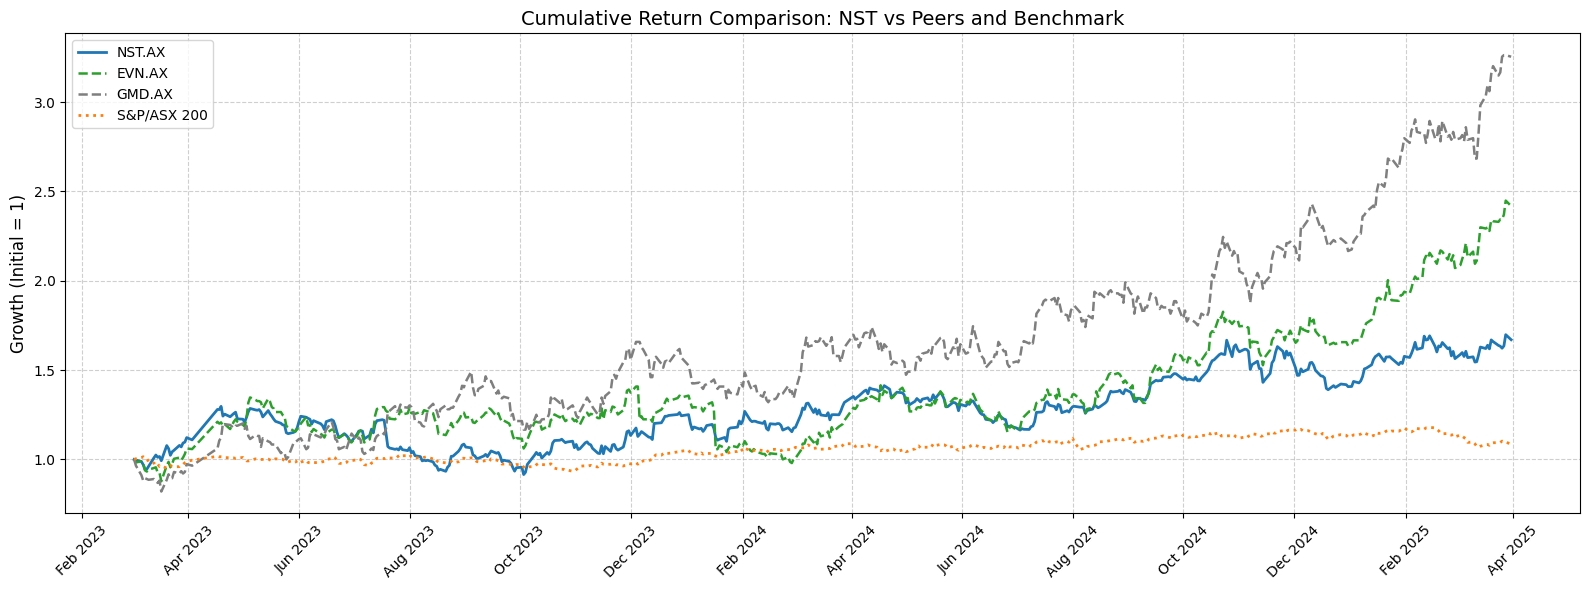

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Remove duplicate dates to ensure a clean datetime index
nst = nst[~nst.index.duplicated(keep='first')]
axjo = axjo[~axjo.index.duplicated(keep='first')]
evn = evn[~evn.index.duplicated(keep='first')]
gmd = gmd[~gmd.index.duplicated(keep='first')]

# Find intersection of dates (common trading days)
common_dates = nst.index.intersection(axjo.index).intersection(evn.index).intersection(gmd.index)

# Align closing prices for all assets on common dates
prices = pd.DataFrame({
    "NST": nst.loc[common_dates, "Close"],
    "EVN": evn.loc[common_dates, "Close"],
    "GMD": gmd.loc[common_dates, "Close"],
    "AXJO": axjo.loc[common_dates, "Close"]
})

# Calculate daily returns and cumulative product for each series
returns = prices.pct_change().dropna()
cumulative_returns = (1 + returns).cumprod()

# Normalize so all series start from 1
cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

# Define professional color palette (Tableau 10 inspired)
colors = {
    "NST": "#1f77b4",   # Dark blue
    "EVN": "#2ca02c",   # Olive green
    "GMD": "#7f7f7f",   # Medium gray
    "AXJO": "#ff7f0e"   # Soft orange
}

# Plot cumulative return comparison
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(cumulative_returns.index, cumulative_returns["NST"], label="NST.AX", color=colors["NST"], linewidth=2)
ax.plot(cumulative_returns.index, cumulative_returns["EVN"], label="EVN.AX", color=colors["EVN"], linestyle="--", linewidth=1.8)
ax.plot(cumulative_returns.index, cumulative_returns["GMD"], label="GMD.AX", color=colors["GMD"], linestyle="--", linewidth=1.8)
ax.plot(cumulative_returns.index, cumulative_returns["AXJO"], label="S&P/ASX 200", color=colors["AXJO"], linestyle=":", linewidth=2)

# Add titles and labels
ax.set_title("Cumulative Return Comparison: NST vs Peers and Benchmark", fontsize=14)
ax.set_ylabel("Growth (Initial = 1)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", frameon=True)

# Date formatting for x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




<ipython-input-12-a33a22f8af2f>:22: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


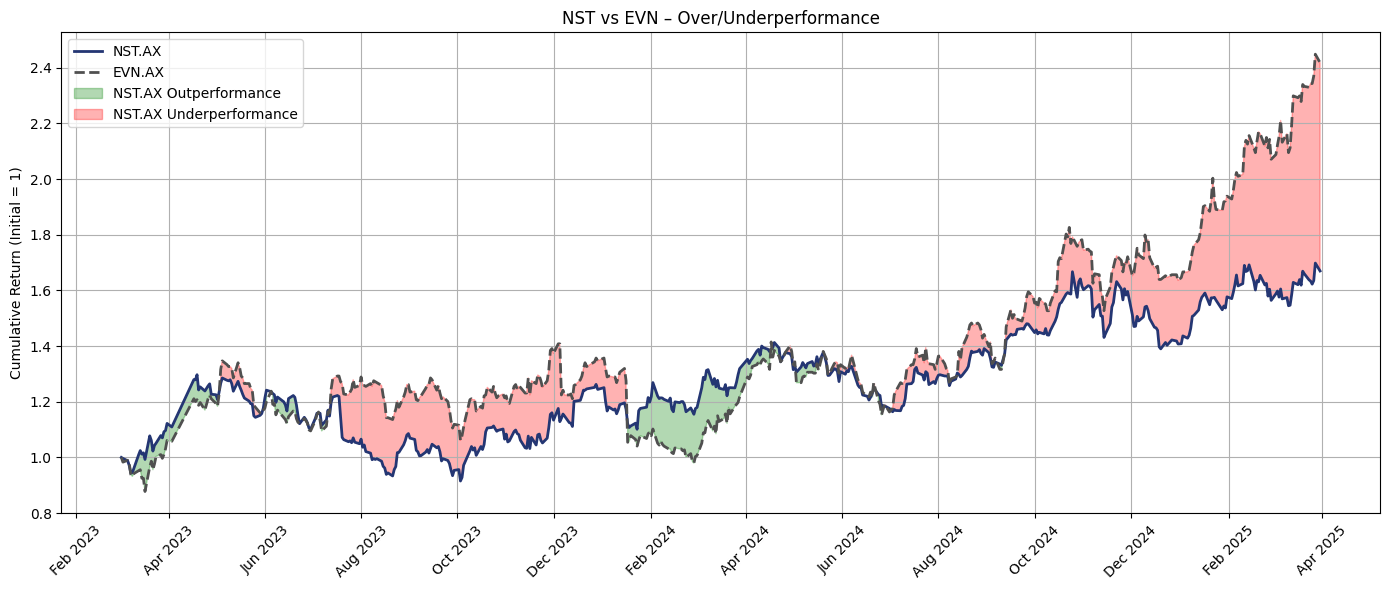

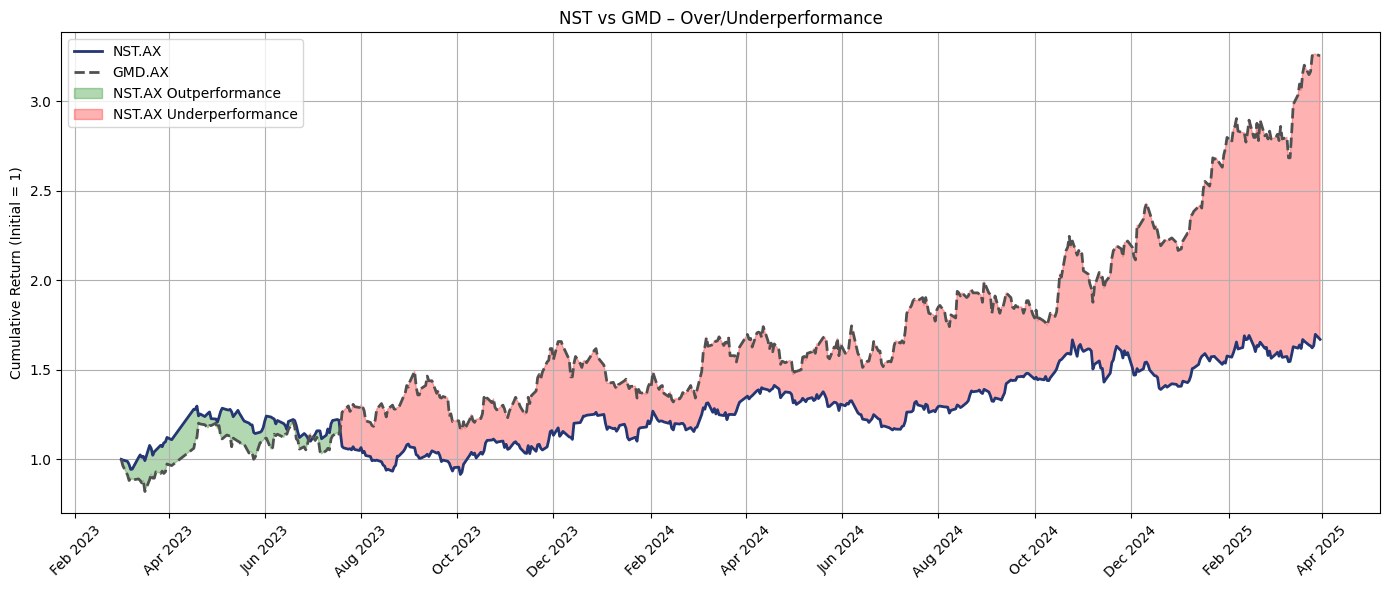

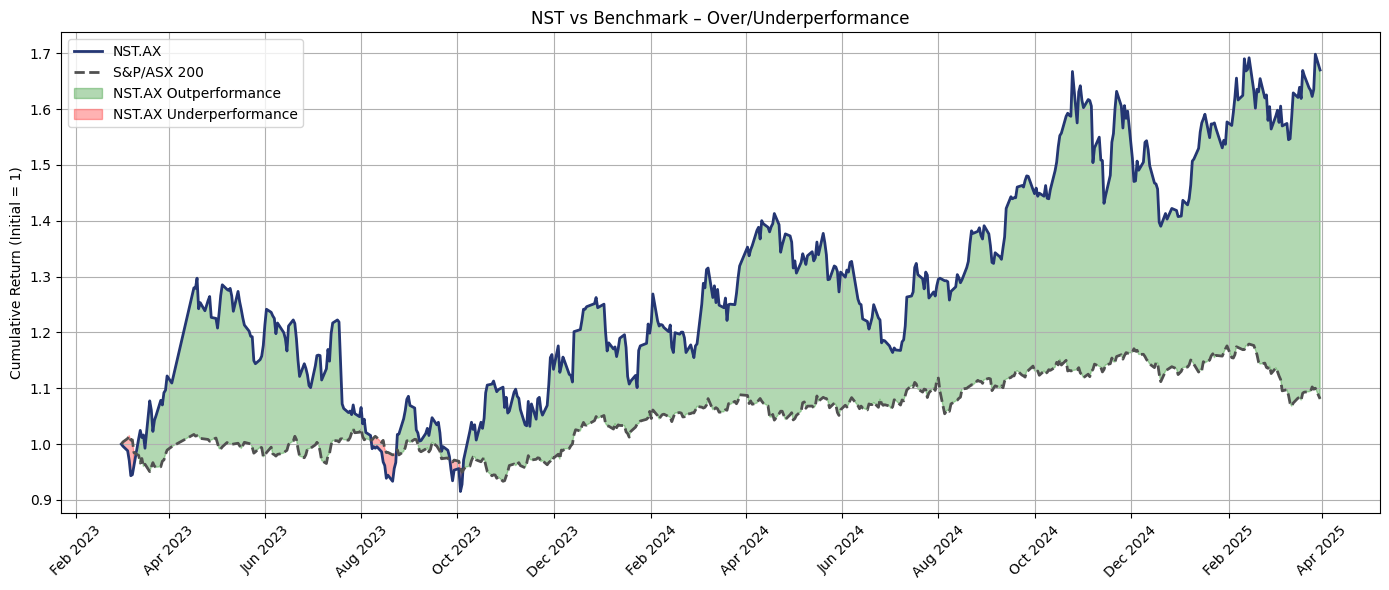

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Remove duplicate indices (if any)
nst = nst[~nst.index.duplicated(keep="first")]
evn = evn[~evn.index.duplicated(keep="first")]
gmd = gmd[~gmd.index.duplicated(keep="first")]
axjo = axjo[~axjo.index.duplicated(keep="first")]

# Find common dates across all assets
common_dates = nst.index.intersection(evn.index).intersection(gmd.index).intersection(axjo.index)

# Create aligned price table
prices = pd.DataFrame({
    "NST.AX": nst.loc[common_dates, "Close"],
    "EVN.AX": evn.loc[common_dates, "Close"],
    "GMD.AX": gmd.loc[common_dates, "Close"],
    "S&P/ASX 200": axjo.loc[common_dates, "Close"]
})

# Calculate cumulative returns (normalized to 1 at start)
returns = prices.pct_change().dropna()
cumulative_returns = (1 + returns).cumprod()
cumulative_returns = cumulative_returns / cumulative_returns.iloc[0]

# Function to plot pairwise over/underperformance with shading
def plot_comparison(x, y1, y2, label1, label2, title):
    plt.figure(figsize=(14, 6))
    plt.plot(x, y1, label=label1, color="#243673", linewidth=2)
    plt.plot(x, y2, label=label2, color="#505050", linestyle="--", linewidth=2)

    # Overperformance (NST > Peer)
    plt.fill_between(x, y1, y2, where=(y1 > y2), color="green", alpha=0.3, label=f"{label1} Outperformance")

    # Underperformance (NST < Peer)
    plt.fill_between(x, y1, y2, where=(y1 < y2), color="red", alpha=0.3, label=f"{label1} Underperformance")

    plt.title(title)
    plt.ylabel("Cumulative Return (Initial = 1)")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# NST vs EVN
plot_comparison(
    cumulative_returns.index,
    cumulative_returns["NST.AX"],
    cumulative_returns["EVN.AX"],
    "NST.AX",
    "EVN.AX",
    "NST vs EVN – Over/Underperformance"
)

# NST vs GMD
plot_comparison(
    cumulative_returns.index,
    cumulative_returns["NST.AX"],
    cumulative_returns["GMD.AX"],
    "NST.AX",
    "GMD.AX",
    "NST vs GMD – Over/Underperformance"
)

# NST vs Benchmark (S&P/ASX 200)
plot_comparison(
    cumulative_returns.index,
    cumulative_returns["NST.AX"],
    cumulative_returns["S&P/ASX 200"],
    "NST.AX",
    "S&P/ASX 200",
    "NST vs Benchmark – Over/Underperformance"
)


## 1.2 Sustainability Initiatives and Their Impact on NST.AX Stock Performance



### **ESG Event Data Setup**

This section defines a set of ESG-related events for Northern Star Resources Ltd (NST.AX), which have been manually collected and categorized.  
Each event is associated with a date and a specific ESG pillar—**Environmental, Social, Governance, General ESG, or Mixed ESG**—and mapped to a distinct color for visualization purposes.



In [ ]:
# ESG color mapping by category
esg_colors = {
    "Environmental": "green",
    "Social": "red",
    "Governance": "purple",
    "General ESG": "blue",
    "Mixed ESG": "#17becf" # teal/cyan
}

# ESG events: list of (date, type, description)
esg_events = [
    ("2023-07-15", "Environmental", "Energy strategy shift"),
    ("2023-12-15", "Environmental", "GHG disclosure improvement"),
    ("2024-02-13", "Environmental", "Solar milestone"),
    ("2024-06-07", "Environmental", "Carosue Dam solar plant"),
    ("2024-06-30", "Governance", "Board transparency review"),
    ("2024-08-22", "General ESG", "ESG highlights in Q&A"),
    ("2024-09-20", "Social", "Workforce policy update"),
    ("2024-11-07", "General ESG", "Annual ESG update"),
    ("2024-11-20", "Governance", "AGM governance reform"),
    ("2024-12-02", "Mixed ESG", "ESG & capex announcement"),
    ("2025-02-05", "Environmental", "Climate risk reassessment"),
    ("2025-02-13", "Mixed ESG", "Sustainability in earnings"),
    ("2025-04-01", "Governance", "Whistleblower policy"),
]

# Preprocess for plotting: (datetime, color)
esg_lines = [(pd.to_datetime(date), esg_colors[etype]) for date, etype, _ in esg_events]


### **ESG Event Overlay Plot (Lines Only)**

This plot overlays vertical dashed lines on the closing price chart of **NST.AX**, marking the timing of key ESG-related events.  
Each line is color-coded according to the ESG pillar (**Environmental, Social, Governance, General ESG, Mixed ESG**), enabling quick visual identification of periods where sustainability news may have aligned with price movements.  
This initial visualization does not include event labels or annotations, and serves as a foundation for further event analysis.


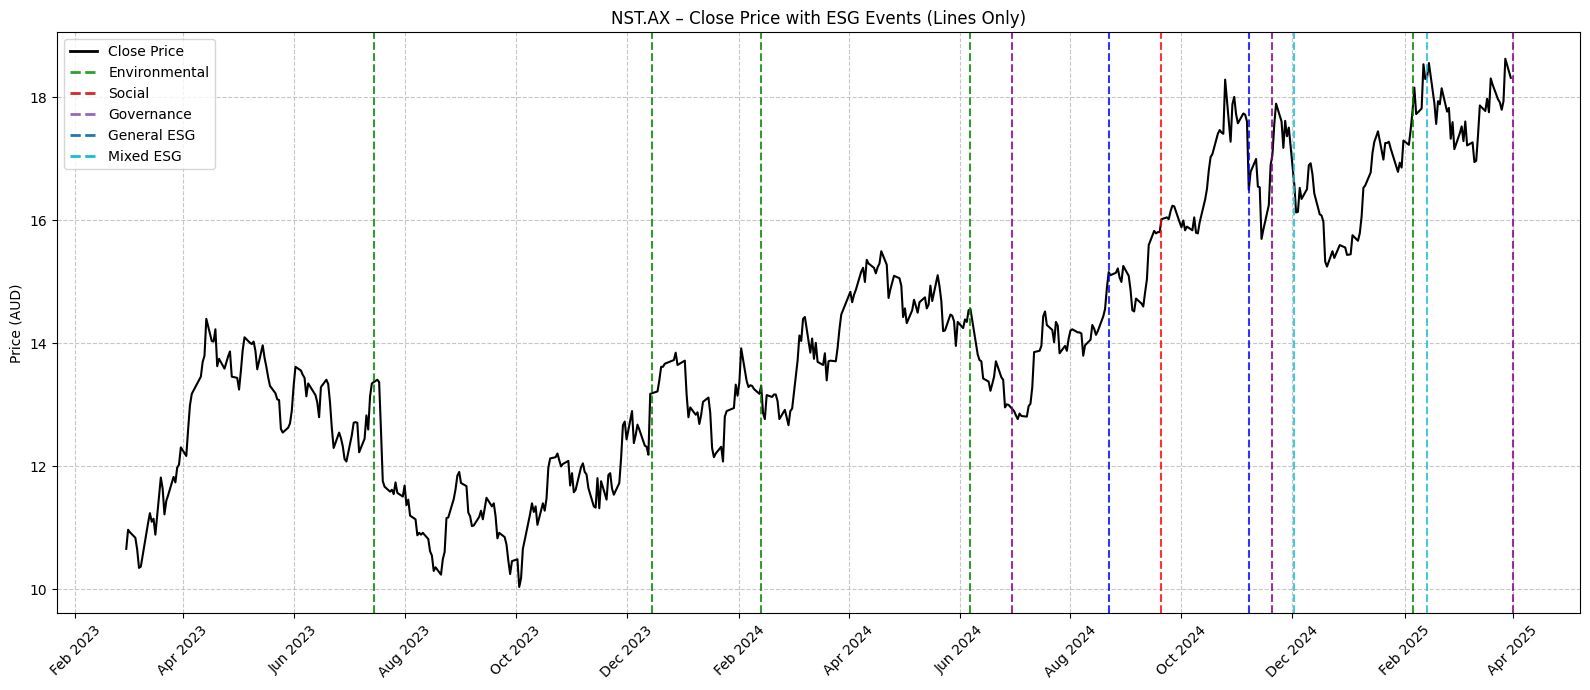

In [ ]:
# ESG Event Overlay Plot (Lines Only)

# Plot base: NST.AX close price
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(nst.index, nst["Close"], color="black", linewidth=1.5, label="Close Price")

# Add vertical dashed lines for each ESG event, color-coded by type
for date, color in esg_lines:
    ax.axvline(x=date, color=color, linestyle="--", linewidth=1.5, alpha=0.8)

# Professional color palette for legend consistency
from matplotlib.lines import Line2D
legend_lines = [
    Line2D([0], [0], color="black", lw=2, label="Close Price"),
    Line2D([0], [0], color="#2ca02c", linestyle="--", lw=2, label="Environmental"),
    Line2D([0], [0], color="#d62728", linestyle="--", lw=2, label="Social"),
    Line2D([0], [0], color="#9467bd", linestyle="--", lw=2, label="Governance"),
    Line2D([0], [0], color="#1f77b4", linestyle="--", lw=2, label="General ESG"),
    Line2D([0], [0], color="#17becf", linestyle="--", lw=2, label="Mixed ESG"),
]

# Final chart formatting
ax.legend(handles=legend_lines, loc="upper left")
ax.set_title("NST.AX – Close Price with ESG Events (Lines Only)")
ax.set_ylabel("Price (AUD)")
ax.grid(True, linestyle="--", alpha=0.7)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
# plt.show()
# fig.savefig("NST_ESG_overlay_clean.png", dpi=300)


### **ESG Events ±3 Day Price Reaction**

This chart visualizes the price impact of ESG-related events for NST.AX, using a ±3 trading day window around each event.
- Shaded bands indicate the window for each ESG event, color-coded by ESG type.
- Percentage price change from t–3 to t+3 days is annotated below the event date.
- This approach highlights possible short-term market reactions to major sustainability and governance news.


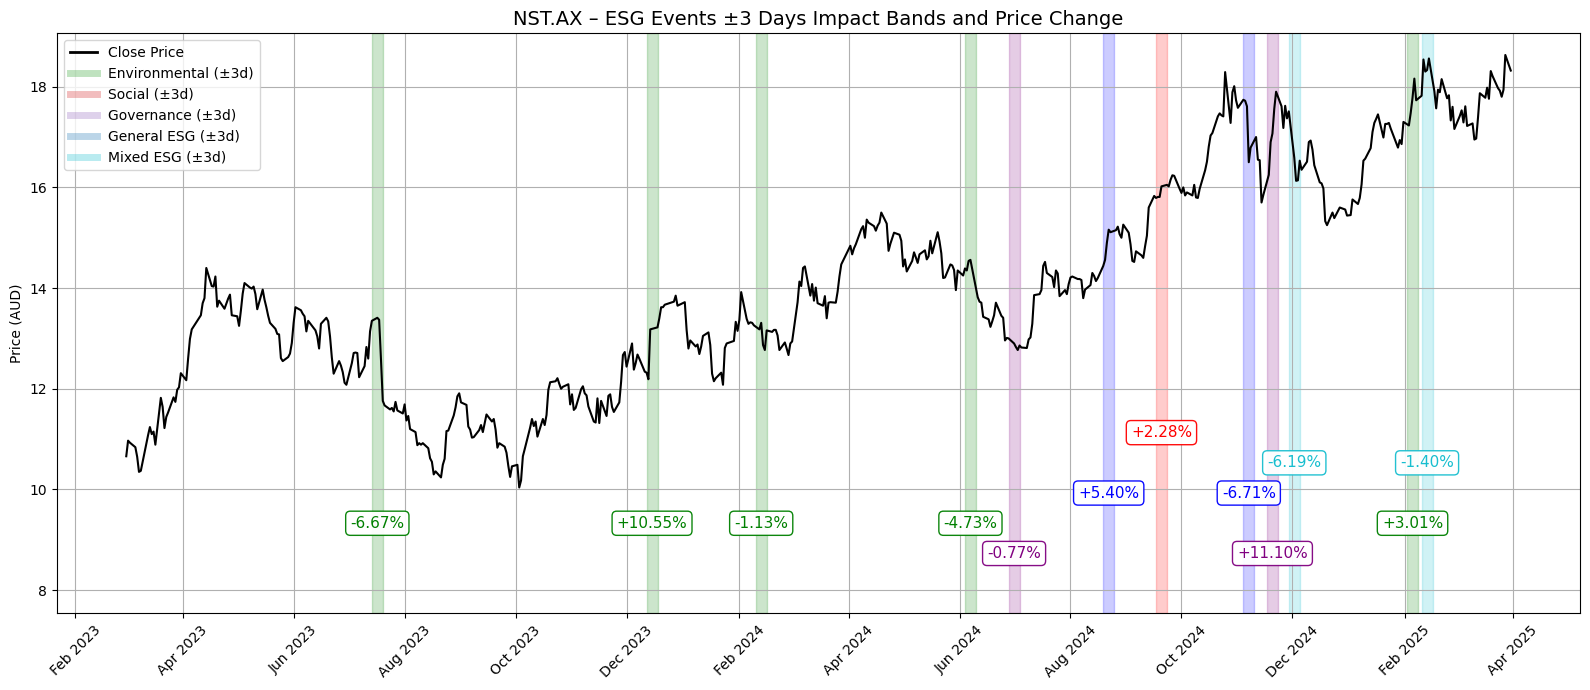

In [ ]:
# Function to align ESG event date to next available trading day
def get_market_date(event_date_str, available_dates):
    target = pd.to_datetime(event_date_str)
    after = available_dates[available_dates >= target]
    return after.min() if not after.empty else None

cutoff_date = pd.to_datetime("2025-03-31")
available_dates = nst.index
combined_esg_events = [(d, t) for (d, t, _) in esg_events]

# Align events and compute ±3 trading day price change
adjusted_events = []
price_changes = {}
for date_str, etype in combined_esg_events:
    edate = get_market_date(date_str, available_dates)
    if edate is None:
        continue
    idx = nst.index.get_loc(edate)
    if idx < 3 or idx + 3 >= len(nst):
        continue
    before = nst.iloc[idx - 3]["Close"]
    after = nst.iloc[idx + 3]["Close"]
    pct = ((after - before) / before) * 100
    adjusted_events.append((edate, etype))
    price_changes[edate] = pct

# Plot close price and ESG event bands
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(nst.index, nst["Close"], color="black", linewidth=1.5, label="Close Price")

# Custom label vertical offsets (to reduce overlap)
type_offsets = {
    "Environmental": -0.4,
    "Social": 1.4,
    "Governance": -1.0,
    "General ESG": 0.2,
    "Mixed ESG": 0.8
}

# Plot ±3d shaded regions and annotate with price change
for edate, etype in adjusted_events:
    color = esg_colors[etype]
    start = edate - pd.Timedelta(days=3)
    end = edate + pd.Timedelta(days=3)
    ax.axvspan(start, end, color=color, alpha=0.2)

    pct = price_changes[edate]
    label = f"{pct:+.2f}%"
    base = nst["Close"].min() - 0.4
    offset = type_offsets.get(etype.replace(" / Mixed", ""), 0)
    ypos = base + offset

    ax.annotate(
        label,
        xy=(edate, ypos),
        xytext=(edate, ypos),
        fontsize=11,
        ha="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.95),
        color=color
    )

# Legend (uses hex codes for visual coherence)
from matplotlib.lines import Line2D
legend_lines = [
    Line2D([0], [0], color="black", lw=2, label="Close Price"),
    Line2D([0], [0], color="#2ca02c", lw=5, alpha=0.3, label="Environmental (±3d)"),
    Line2D([0], [0], color="#d62728", lw=5, alpha=0.3, label="Social (±3d)"),
    Line2D([0], [0], color="#9467bd", lw=5, alpha=0.3, label="Governance (±3d)"),
    Line2D([0], [0], color="#1f77b4", lw=5, alpha=0.3, label="General ESG (±3d)"),
    Line2D([0], [0], color="#17becf", lw=5, alpha=0.3, label="Mixed ESG (±3d)")
]

ax.legend(handles=legend_lines, loc="upper left", fontsize=10)
ax.set_title("NST.AX – ESG Events ±3 Days Impact Bands and Price Change", fontsize=14)
ax.set_ylabel("Price (AUD)")
ax.set_ylim(bottom=nst["Close"].min() - 2.5)
ax.grid(True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

### ESG Events: Directional Price Change from t to t+3

This plot evaluates the immediate directional price response of NST.AX to ESG-related announcements.  
- For each ESG event, the price change from the event day (t) to three trading days later (t+3) is calculated.
- A shaded band highlights the evaluation window, and the percentage return is displayed below each band.
- Events are color-coded by ESG category (Environmental, Social, Governance, General ESG, Mixed ESG), making it easy to visually distinguish between types of disclosures and their market impacts.


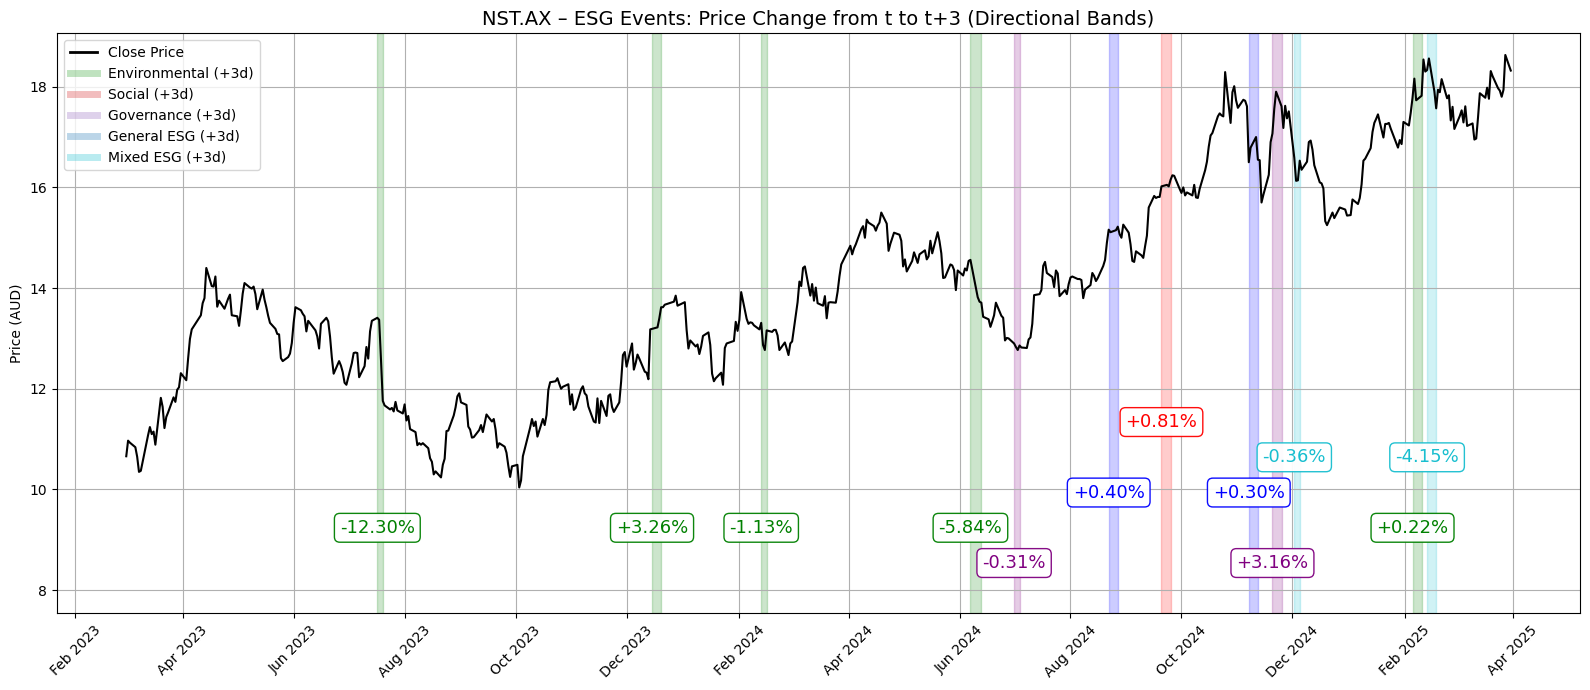

In [ ]:
# Align ESG event dates to valid trading days
def get_market_date(event_date_str, available_dates):
    target = pd.to_datetime(event_date_str)
    after = available_dates[available_dates >= target]
    return after.min() if not after.empty else None

cutoff_date = pd.to_datetime("2025-03-31")
available_dates = nst.index
combined_esg_events = [(d, t) for (d, t, _) in esg_events]

adjusted_events = []
price_changes = {}

# Calculate price change from event day t to t+3
for date_str, etype in combined_esg_events:
    edate = get_market_date(date_str, available_dates)
    if edate is None:
        continue
    idx = nst.index.get_loc(edate)
    if idx + 3 >= len(nst):
        continue
    t0 = edate
    t3 = nst.index[idx + 3]
    pct = ((nst.loc[t3, "Close"] - nst.loc[t0, "Close"]) / nst.loc[t0, "Close"]) * 100
    adjusted_events.append((t0, t3, etype))
    price_changes[t0] = pct

# Plot closing price and ESG event windows
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(nst.index, nst["Close"], color="black", linewidth=1.5, label="Close Price")

# Define custom label vertical offsets for clarity
type_offsets = {
    "Environmental": -0.4,
    "Social": 1.7,
    "Governance": -1.1,
    "General ESG": 0.3,
    "Mixed ESG": 1
}

# Plot shaded bands for each ESG window and annotate with price change
for t0, t3, etype in adjusted_events:
    color = esg_colors[etype]
    ax.axvspan(t0, t3, color=color, alpha=0.2)

    pct = price_changes[t0]
    label = f"{pct:+.2f}%"
    base = nst["Close"].min() - 0.5
    offset = type_offsets.get(etype.replace(" / Mixed", ""), 0)
    ypos = base + offset

    ax.annotate(
        label,
        xy=(t0, ypos),
        xytext=(t0, ypos),
        fontsize=13,
        ha="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.95),
        color=color
    )

# Custom legend using hex colors
from matplotlib.lines import Line2D
legend_lines = [
    Line2D([0], [0], color="black", lw=2, label="Close Price"),
    Line2D([0], [0], color="#2ca02c", lw=5, alpha=0.3, label="Environmental (+3d)"),
    Line2D([0], [0], color="#d62728", lw=5, alpha=0.3, label="Social (+3d)"),
    Line2D([0], [0], color="#9467bd", lw=5, alpha=0.3, label="Governance (+3d)"),
    Line2D([0], [0], color="#1f77b4", lw=5, alpha=0.3, label="General ESG (+3d)"),
    Line2D([0], [0], color="#17becf", lw=5, alpha=0.3, label="Mixed ESG (+3d)")
]

# Final chart formatting
ax.legend(handles=legend_lines, loc="upper left", fontsize=10)
ax.set_title("NST.AX – ESG Events: Price Change from t to t+3 (Directional Bands)", fontsize=14)
ax.set_ylabel("Price (AUD)")
ax.set_ylim(bottom=nst["Close"].min() - 2.5)
ax.grid(True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()


### ESG Events Triggering Confirmed Market Spikes (t to t+3)

This section isolates ESG-related announcements for NST.AX that are followed by abnormal market activity (price spike, volume spike, or both) within the subsequent three trading days.  
For each qualifying event:
- A shaded directional band (from event day **t** to **t+3** trading days) is drawn.
- A dashed vertical line marks the specific day of the detected spike within this window.
- Only ESG events with confirmed spikes are visualized.
- The percentage change in closing price from t to t+3 is annotated below each event band.

This approach highlights which ESG disclosures have triggered immediate and significant market reactions.



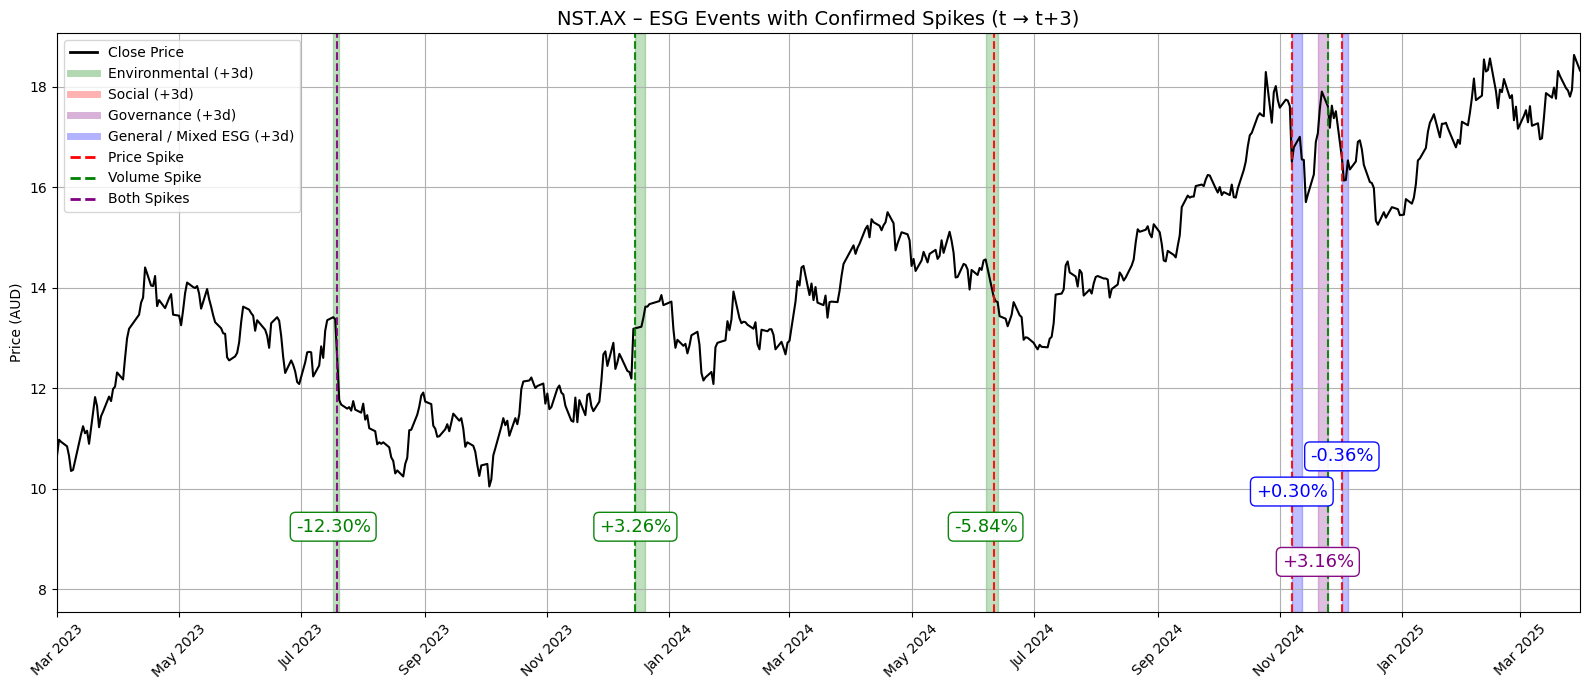

In [ ]:
# Parameters
cutoff_date = pd.to_datetime("2025-03-31")
available_dates = nst.index
price_threshold = 0.05
volume_mean = nst["Volume"].mean()
volume_std = nst["Volume"].std()
volume_threshold = volume_mean + 2 * volume_std

# Classify spikes
only_price = nst[abs(nst["Return"]) > price_threshold].index
only_volume = nst[nst["Volume"] > volume_threshold].index
both = only_price.intersection(only_volume)

event_dict = {}
for date in only_price:
    event_dict[date] = "price spike"
for date in only_volume:
    event_dict[date] = "volume spike"
for date in both:
    event_dict[date] = "both"

event_colors = {
    "price spike": "red",
    "volume spike": "green",
    "both": "purple"
}

esg_colors = {
    "Environmental": "green",
    "Social": "red",
    "Governance": "purple",
    "General ESG": "blue",
    "Mixed ESG": "blue"
}

# Define custom label vertical offsets for clarity
type_offsets = {
    "Environmental": -0.4,
    "Social": 1.7,
    "Governance": -1.1,
    "General ESG": 0.3,
    "Mixed ESG": 1
}

# Align ESG dates to trading days
def get_market_date(event_date_str, available_dates):
    target_date = pd.to_datetime(event_date_str)
    future_dates = available_dates[available_dates >= target_date]
    return future_dates.min() if not future_dates.empty else None

# Prepare aligned ESG events and compute price change t → t+3
adjusted_events = []
adjusted_price_changes_auto = {}

for date_str, etype in combined_esg_events:
    market_date = get_market_date(date_str, available_dates)
    if market_date:
        adjusted_events.append((market_date, etype))
        idx = nst.index.get_loc(market_date)
        if idx + 3 < len(nst):
            price_before = nst.loc[market_date, "Close"]
            price_after = nst.loc[nst.index[idx + 3], "Close"]
            pct_change = ((price_after - price_before) / price_before) * 100
            adjusted_price_changes_auto[market_date.strftime('%Y-%m-%d')] = f"{pct_change:+.2f}%"
        else:
            adjusted_price_changes_auto[market_date.strftime('%Y-%m-%d')] = "--"

# Match ESG events with spikes in t → t+3 window
matched_events = []
for event_date, etype in adjusted_events:
    try:
        idx = nst.index.get_loc(event_date)
        window = nst.index[idx:idx + 4]  # t, t+1, t+2, t+3
        for d in window:
            if d in event_dict:
                matched_events.append((event_date, etype, d, event_dict[d]))
                break
    except:
        continue

# Final plot
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(nst.index, nst["Close"], color="black", linewidth=1.5, label="Close Price")

for t0, etype, spike_date, spike_type in matched_events:
    idx = nst.index.get_loc(t0)
    t3 = nst.index[idx + 3] if idx + 3 < len(nst) else t0 + pd.Timedelta(days=3)
    color = esg_colors[etype]
    spike_color = event_colors[spike_type]

    # Band t → t+3
    ax.axvspan(t0, t3, color=color, alpha=0.25)

    # Spike line
    ax.axvline(x=spike_date, color=spike_color, linestyle="--", linewidth=1.5, alpha=0.9)

    # Label with percentage change
    pct = adjusted_price_changes_auto.get(t0.strftime('%Y-%m-%d'), "--")
    base = nst["Close"].min() - 0.5
    offset = type_offsets.get(etype.replace(" / Mixed", ""), 0)
    ypos = base + offset
    ax.annotate(
        pct,
        xy=(t0, ypos),
        xytext=(t0, ypos),
        fontsize=13,
        ha="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.95),
        color=color
    )

# Custom legend
from matplotlib.lines import Line2D
legend_lines = [
    Line2D([0], [0], color="black", lw=2, label="Close Price"),
    Line2D([0], [0], color="green", lw=5, alpha=0.3, label="Environmental (+3d)"),
    Line2D([0], [0], color="red", lw=5, alpha=0.3, label="Social (+3d)"),
    Line2D([0], [0], color="purple", lw=5, alpha=0.3, label="Governance (+3d)"),
    Line2D([0], [0], color="blue", lw=5, alpha=0.3, label="General / Mixed ESG (+3d)"),
    Line2D([0], [0], color="red", linestyle="--", lw=2, label="Price Spike"),
    Line2D([0], [0], color="green", linestyle="--", lw=2, label="Volume Spike"),
    Line2D([0], [0], color="purple", linestyle="--", lw=2, label="Both Spikes"),
]

# Final formatting
ax.legend(handles=legend_lines, loc="upper left", fontsize=10)
ax.set_title("NST.AX – ESG Events with Confirmed Spikes (t → t+3)", fontsize=14)
ax.set_ylabel("Price (AUD)")
ax.set_ylim(bottom=nst["Close"].min() - 2.5)
ax.grid(True)
ax.set_xlim([nst.index.min(), cutoff_date])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()



### ESG Event Table: t→t+3 Market Reaction and Spike Detection

This table summarizes all ESG events with their corresponding market response:
- For each event, it reports the closing price, percentage return from t to t+3, and whether a price spike, volume spike, or both were detected in the three days following the announcement.
- The table also includes columns for "News Description" and "Source/Link" to be filled during qualitative review.
- Summary statistics for the average return and total number of events are shown below.

Use this table to investigate which ESG events triggered abnormal market activity and to document the nature of each event.


In [ ]:
# Rebuild ESG event table with t→t+3 window and spike classification
esg_table = []
for event_date, etype in adjusted_events:
    row = {}
    row["Date"] = event_date.strftime("%Y-%m-%d")
    row["ESG Type"] = etype

    # --- Market values ---
    close = round(nst.loc[event_date, "Close"], 2)
    row["Close Price"] = close

    # --- Return over t→t+3 ---
    idx = nst.index.get_loc(event_date)
    if idx + 3 < len(nst):
        ret = ((nst.iloc[idx + 3]["Close"] - close) / close) * 100
        row["Return (%)"] = round(ret, 2)
    else:
        row["Return (%)"] = None

    # --- Spike detection within window t→t+3 ---
    window = nst.index[idx:idx+4]  # t, t+1, t+2, t+3
    spike_detected = None
    spike_day = None
    for d in window:
        if d in both:
            spike_detected = "Both Spikes"
            spike_day = d.strftime("%Y-%m-%d")
            break
        elif d in only_price and spike_detected is None:
            spike_detected = "Price Spike"
            spike_day = d.strftime("%Y-%m-%d")
        elif d in only_volume and spike_detected is None:
            spike_detected = "Volume Spike"
            spike_day = d.strftime("%Y-%m-%d")

    row["Spike Type"] = spike_detected if spike_detected else "None"
    row["Spike Date"] = spike_day if spike_day else ""

    # --- Placeholders for manual enrichment ---
    row["News Description"] = ""
    row["Source/Link"] = ""

    esg_table.append(row)

# Create DataFrame
esg_df = pd.DataFrame(esg_table)

# Optional summary statistics
avg_return = round(esg_df["Return (%)"].dropna().mean(), 2)
print(f"Average ESG Event Return (t→t+3): {avg_return} %")
print(f"Total ESG Events: {len(esg_df)}")
print(f"With Spike Detected: {sum(esg_df['Spike Type'] != 'None')}")

# Preview table
esg_df  # or display(esg_df) in a Jupyter/Colab environment



Average ESG Event Return (t→t+3): -1.33 %
Total ESG Events: 12
With Spike Detected: 6


Date       ESG Type  Close Price  Return (%)    Spike Type  \
0   2023-07-17  Environmental        13.41      -12.30   Both Spikes   
1   2023-12-15  Environmental        13.19        3.26  Volume Spike   
2   2024-02-13  Environmental        13.31       -1.13          None   
3   2024-06-07  Environmental        14.56       -5.84   Price Spike   
4   2024-07-01     Governance        12.90       -0.31          None   
5   2024-08-22    General ESG        15.16        0.40          None   
6   2024-09-20         Social        16.02        0.81          None   
7   2024-11-07    General ESG        16.50        0.30   Price Spike   
8   2024-11-20     Governance        17.07        3.16  Volume Spike   
9   2024-12-02      Mixed ESG        16.59       -0.36   Price Spike   
10  2025-02-05  Environmental        17.78        0.22          None   
11  2025-02-13      Mixed ESG        18.33       -4.15          None   

    Spike Date News Description Source/Link  
0   2023-07-19                               
1   2023-12-15                               
2                                            
3   2024-06-11                               
4                                            
5                                            
6                                            
7   2024-11-07                               
8   2024-11-25                               
9   2024-12-02                               
10                                           
11

# Task 2 (20 marks)

Recent sharp declines in key commodity prices have highlighted the growing unpredictability within the mining sector (Sharesight, 2025). Assuming broader market developments — such as ongoing geopolitical tensions, volatility in global demand, and falling commodity prices — continue to unfold. These macroeconomic uncertainties may further amplify volatility for mining companies like Northern Star Resources Ltd. As a result, analysts expect heightened volatility in NST’s stock over the coming months. However, there is no clear consensus on whether the stock will rise or fall — only that significant movement is likely.

As an investor who anticipates increased market volatility but is uncertain about the direction of NST’s price movement, you are considering using options to take advantage of this scenario.

**(a)** Identify two option strategies that an investor could use to profit from increasing volatility in NST regardless of the direction of the stock price movement. Discuss the relative advantages and disadvantages of the two strategies.

**(b)** Using data information provided in Exhibit 1, construct numerical examples of each strategy for NST options, to justify your decision and comparison of the two strategies discussed in Task (2a). Explain how the strategies will work, detail all transactions for undertaking the strategies and evaluate the outcomes of two options strategies at expiry.

> Note that the profit diagrams can be constructed with the assistance of the spreadsheet OptionStrategyAnalyzer10e.xlsm. You can use as much capital as you wish. Note that you buy options at ask prices and sell options at bid prices.

**Exhibit 1:** NST.AX option data for 25th March 2025 (observation date or strategy construction date)



### **Dividend Assumption**

For simplicity and in line with the assignment instructions (Task 4), we assume that Northern Star Resources Ltd. does **not** pay dividends during the life of the options under analysis. This allows us to use the standard Black-Scholes model for option pricing and implied volatility calculations, with no dividend adjustment (i.e., dividend yield q = 0).


### Data Import – Exhibit 1

NST.AX option data from Exhibit 1 has been manually transcribed and loaded into Python DataFrames.  
This structure enables analysis, simulation, and visualization of option strategies using actual bid/ask prices and sizes for both calls and puts, across multiple expiries and strikes.

These datasets serve as the foundation for all subsequent quantitative analysis and option strategy simulations.


In [ ]:
# Option data for 15-May-2025 expiry, including Bid/Ask Size for both Call and Put
data_15may = {
    'Strike':      [16.51, 17.01, 17.51, 18.01, 18.51, 19.01],
    'Call_Bid':    [1.69,  1.34,  1.03,  0.77,  0.56,  0.41],
    'Call_Ask':    [1.83,  1.47,  1.15,  0.89,  0.66,  0.47],
    'Call_BidSize':[400,   400,   400,   400,   400,   200],
    'Call_AskSize':[400,   400,   400,   400,   400,   8],
    'Put_Bid':     [0.23,  0.36,  0.54,  0.77,  1.04,  1.36],
    'Put_Ask':     [0.32,  0.46,  0.64,  0.89,  1.17,  1.51],
    'Put_BidSize': [400,   400,   400,   400,   400,   400],
    'Put_AskSize': [400,   400,   400,   400,   400,   400]
}
df_15may = pd.DataFrame(data_15may)
df_15may['Expiry'] = '2025-05-15'

# Option data for 19-Jun-2025 expiry
data_19jun = {
    'Strike':      [16.51, 17.01, 17.51, 18.01, 18.51, 19.01],
    'Call_Bid':    [1.94,  1.60,  1.30,  1.05,  0.83,  0.65],
    'Call_Ask':    [2.08,  1.74,  1.44,  1.17,  0.95,  0.77],
    'Call_BidSize':[400,   400,   400,   400,   400,   400],
    'Call_AskSize':[400,   400,   400,   400,   400,   400],
    'Put_Bid':     [0.40,  0.56,  0.74,  0.97,  1.23,  1.55],
    'Put_Ask':     [0.50,  0.66,  0.86,  1.10,  1.38,  1.69],
    'Put_BidSize': [400,   400,   400,   400,   400,   400],
    'Put_AskSize': [400,   400,   400,   400,   400,   400]
}
df_19jun = pd.DataFrame(data_19jun)
df_19jun['Expiry'] = '2025-06-19'

# Option data for 17-Jul-2025 expiry
data_17jul = {
    'Strike':      [16.51, 17.01, 17.51, 18.01, 18.51, 19.01],
    'Call_Bid':    [2.07,  1.77,  1.47,  1.22,  1.01,  0.82],
    'Call_Ask':    [2.29,  1.95,  1.65,  1.40,  1.15,  0.96],
    'Call_BidSize':[400,   400,   400,   400,   400,   400],
    'Call_AskSize':[400,   400,   400,   400,   400,   400],
    'Put_Bid':     [0.51,  0.67,  0.86,  1.10,  1.35,  1.65],
    'Put_Ask':     [0.63,  0.81,  1.01,  1.24,  1.53,  1.83],
    'Put_BidSize': [400,   400,   400,   400,   400,   400],
    'Put_AskSize': [400,   400,   400,   400,   400,   400]
}
df_17jul = pd.DataFrame(data_17jul)
df_17jul['Expiry'] = '2025-07-17'

# Each DataFrame now contains full bid/ask/size info for both calls and puts, separated by expiry.
print("May Expiry:")
print(df_15may)
print("\nJune Expiry:")
print(df_19jun)
print("\nJuly Expiry:")
print(df_17jul)


May Expiry:
   Strike  Call_Bid  Call_Ask  Call_BidSize  Call_AskSize  Put_Bid  Put_Ask  \
0   16.51      1.69      1.83           400           400     0.23     0.32   
1   17.01      1.34      1.47           400           400     0.36     0.46   
2   17.51      1.03      1.15           400           400     0.54     0.64   
3   18.01      0.77      0.89           400           400     0.77     0.89   
4   18.51      0.56      0.66           400           400     1.04     1.17   
5   19.01      0.41      0.47           200             8     1.36     1.51   

   Put_BidSize  Put_AskSize      Expiry  
0          400          400  2025-05-15  
1          400          400  2025-05-15  
2          400          400  2025-05-15  
3          400          400  2025-05-15  
4          400          400  2025-05-15  
5          400          400  2025-05-15  

June Expiry:
   Strike  Call_Bid  Call_Ask  Call_BidSize  Call_AskSize  Put_Bid  Put_Ask  \
0   16.51      1.94      2.08           400    

### Volatility Estimations:

#### Historical (Realized) Volatility

Historical volatility is estimated as the annualized standard deviation of daily log returns, typically calculated using a 30-day rolling window. This approach provides a forward-looking, comparable metric to the 30-day implied volatility extracted from options prices.


**Calculation Steps**

**1. Compute daily log returns**
- Formula:  
  log_return[t] = ln(Price[t] / Price[t-1])
- Where:
    - Price[t] = closing price on day t
    - ln = natural logarithm

**2. Calculate the rolling standard deviation of log returns**
- For each day t, use the most recent N returns (typically N = 30 days):
  rolling_std[t] = standard_deviation of (log_return[t-N+1] ... log_return[t])

**3. Annualize the rolling volatility**
- Formula:  
  annualized_vol[t] = rolling_std[t] * sqrt(252)
- Where:
    - sqrt = square root
    - 252 = typical number of trading days in a year

 **Why Use a 30-Day Window?**

- **Industry Convention:**  
  30 days approximates a “monthly” volatility and is a standard window for comparing realized and implied volatilities.
- **Sensitivity:**  
  Long enough to smooth out noise, but short enough to react to recent market changes.
- **Comparability:**  
  Allows direct comparison with the 30-day implied volatility of options, which is also annualized.

**Interpretation**

The annualized volatility tells us the “typical” magnitude of price moves we’d expect over a one-year horizon, based on how volatile the stock has been in the past month.

---

**In summary:**  
We use a 30-day rolling window of daily log returns to estimate historical volatility, then annualize it for direct comparison with market-implied volatility. This is a universally accepted method in both academia and industry.




In [ ]:
def historical_volatility(price_series, window=30):
    """
    Compute annualized historical volatility (realized volatility) from a price series.
    - price_series: pd.Series of closing prices, indexed by date
    - window: lookback window in days
    Returns pd.Series of rolling annualized volatility
    """
    log_ret = np.log(price_series / price_series.shift(1))
    rolling_std = log_ret.rolling(window=window).std()
    ann_vol = rolling_std * np.sqrt(252)
    return ann_vol

# Usage:
nst["HistVol_30d_ann"] = historical_volatility(nst["Close"], window=30)
hist_vol_25mar = nst.loc[:'2025-03-25', "HistVol_30d_ann"].dropna().iloc[-1]
print(f"Historical Volatility (Annualized, 30d) at 25-Mar-2025: {hist_vol_25mar:.2%}")

Historical Volatility (Annualized, 30d) at 25-Mar-2025: 28.22%


#### Implied Volatility (IV)

Implied volatility is a forward-looking estimate of expected stock price fluctuations, derived from the market prices of options. Unlike historical volatility, which is backward-looking, IV reflects the consensus of market participants about future risk.

**Calculation Steps**

**1. Select the Option**
- Choose an option close to “at-the-money” (ATM), i.e., strike price nearest to the current stock price.
- Use the option with a relevant expiry (e.g., next 1-3 months).

**2. Retrieve the Market Price**
- Take the market price of the option.  
  - For accuracy, use the mid price:  
    mid_price = (Bid + Ask) / 2

**3. Use the Black-Scholes Model (or another option pricing model)**
- Plug in all known variables:
    - S = current stock price (spot)
    - K = strike price
    - T = time to expiry (in years)
    - r = risk-free interest rate
    - Option market price (mid)
- The **implied volatility** is the value of σ (volatility) that makes the Black-Scholes theoretical price equal to the observed market price.

**4. Numerical Inversion**
- There is no algebraic solution for IV.  
- IV is typically found using a root-finding algorithm (e.g., Newton-Raphson, Brent’s method), solving:
  - BlackScholesPrice(S, K, T, r, σ) = OptionMarketPrice

**5. Result**
- The solution σ* is the **implied volatility** for that option.

**Formulas (in plain text):**

- Black-Scholes Call Price:
      price = S * N(d1) - K * exp(-r*T) * N(d2)
- Where:
        d1 = [ln(S/K) + (r + 0.5*σ²)*T] / [σ * sqrt(T)]
        d2 = d1 - σ * sqrt(T)
        N(x) = cumulative standard normal distribution

- **IV calculation:**  
    Solve for σ such that Black-Scholes price = observed market price

**Why Use Implied Volatility?**

- **Market Consensus:**  
  IV reflects the market’s expectation of future volatility — incorporating all available information, sentiment, and risk premia.
- **Direct Input for Option Pricing:**  
  It is the standard parameter used in pricing and risk-managing options, because it is “forward-looking”.

**Interpretation**

The higher the IV, the more expensive the option — indicating that the market expects larger price swings (higher risk/uncertainty) over the life of the option.

---

**Summary:**  
Implied volatility is reverse-engineered from market option prices using the Black-Scholes model and a root-finding algorithm. It is the benchmark for forward-looking volatility and a direct measure of how “nervous” or “calm” the market is about future moves.


In [ ]:
# ---- Black-Scholes pricing functions for calls and puts ----

def black_scholes_call_price(S, K, T, r, sigma):
    """Black-Scholes price for European CALL option."""
    if T == 0 or sigma == 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put_price(S, K, T, r, sigma):
    """Black-Scholes price for European PUT option."""
    if T == 0 or sigma == 0:
        return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)



def implied_vol_call(market_price, S, K, T, r, tol=1e-6, maxiter=200):
    """Implied volatility for CALL via Black-Scholes inversion (Brent's method)."""
    def objective(sigma):
        return black_scholes_call_price(S, K, T, r, sigma) - market_price
    try:
        iv = brentq(objective, 1e-6, 3, xtol=tol, maxiter=maxiter)
        return iv
    except Exception as e:
        print(f"IV calculation failed (call): {e}")
        return np.nan

def implied_vol_put(market_price, S, K, T, r, tol=1e-6, maxiter=200):
    """Implied volatility for PUT via Black-Scholes inversion (Brent's method)."""
    def objective(sigma):
        return black_scholes_put_price(S, K, T, r, sigma) - market_price
    try:
        iv = brentq(objective, 1e-6, 3, xtol=tol, maxiter=maxiter)
        return iv
    except Exception as e:
        print(f"IV calculation failed (put): {e}")
        return np.nan

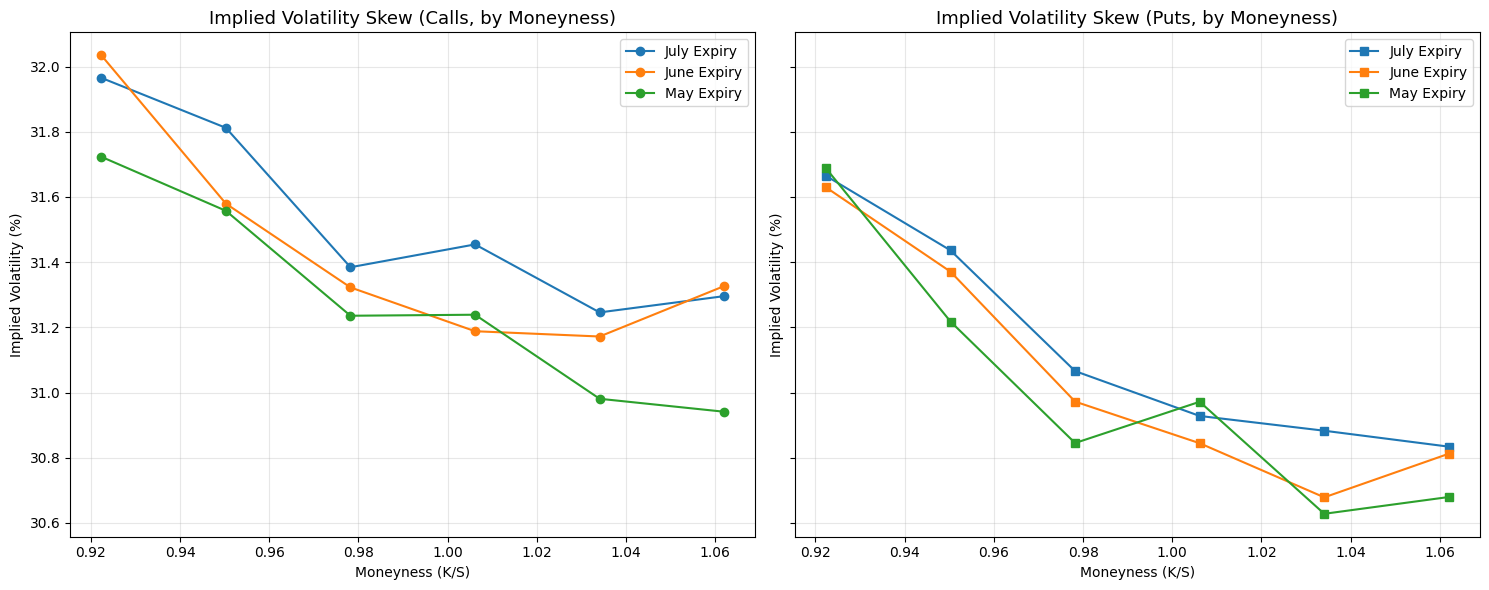

In [ ]:
# Statistics and distributions
from scipy.stats import norm
# --- Setup Option DataFrames ---
df_map = {
    "May": df_15may.copy(),
    "June": df_19jun.copy(),
    "July": df_17jul.copy()
}

S = 17.90  # Underlying price
r = 0.041
valuation_date = pd.Timestamp("2025-03-25")
expiry_dates = {
    "May": pd.Timestamp("2025-05-15"),
    "June": pd.Timestamp("2025-06-19"),
    "July": pd.Timestamp("2025-07-17")
}

# --- Calculate Implied Volatility for each strike and expiry (CALLS & PUTS) ---
iv_dict_calls = {}
iv_dict_puts = {}
results = []

for expiry, df in df_map.items():
    expiry_date = expiry_dates[expiry]
    T = (expiry_date - valuation_date).days / 365.0
    for idx, row in df.iterrows():
        K = row["Strike"]
        # --- Call IV ---
        call_bid = row["Call_Bid"]
        call_ask = row["Call_Ask"]
        call_mid = (call_bid + call_ask) / 2
        iv_call = implied_vol_call(call_mid, S, K, T, r)
        iv_dict_calls[(expiry_date, K)] = iv_call
        # --- Put IV ---
        put_bid = row["Put_Bid"]
        put_ask = row["Put_Ask"]
        put_mid = (put_bid + put_ask) / 2
        iv_put = implied_vol_put(put_mid, S, K, T, r)
        iv_dict_puts[(expiry_date, K)] = iv_put
        # --- Results for DataFrame ---
        results.append({
            "Expiry": expiry,
            "Expiry_Date": expiry_date,
            "Strike": K,
            "Call_Mid": call_mid,
            "Put_Mid": put_mid,
            "Call_IV": iv_call,
            "Put_IV": iv_put
        })

# --- Convert to DataFrame ---
iv_df_full = pd.DataFrame(results)

# Add moneyness columns
iv_df_full["Moneyness"] = iv_df_full["Strike"] / S
iv_df_full["LogMoneyness"] = np.log(iv_df_full["Strike"] / S)

# Plot IV vs Moneyness (ratio)
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
for expiry, grp in iv_df_full.groupby("Expiry"):
    axs[0].plot(grp["Moneyness"], grp["Call_IV"] * 100, marker="o", label=f"{expiry} Expiry")
    axs[1].plot(grp["Moneyness"], grp["Put_IV"] * 100, marker="s", label=f"{expiry} Expiry")
axs[0].set_title("Implied Volatility Skew (Calls, by Moneyness)", fontsize=13)
axs[1].set_title("Implied Volatility Skew (Puts, by Moneyness)", fontsize=13)
for ax in axs:
    ax.set_xlabel("Moneyness (K/S)")
    ax.set_ylabel("Implied Volatility (%)")
    ax.grid(True, alpha=0.3)
    ax.legend()
plt.tight_layout()
plt.show()

---

#### **GARCH for Volatility Estimation?**

In financial markets, volatility is rarely constant over time. Instead, it tends to cluster: periods of high volatility are often followed by more high volatility, and low volatility by more low. Traditional historical volatility, which assumes constant variance, fails to capture this dynamic behavior.  
The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model provides a more sophisticated framework by allowing volatility to evolve as a stochastic process, conditional on past returns and past volatility. This approach is widely used in risk management and option pricing because it better reflects real-world patterns in financial time series, especially during turbulent market periods.

---


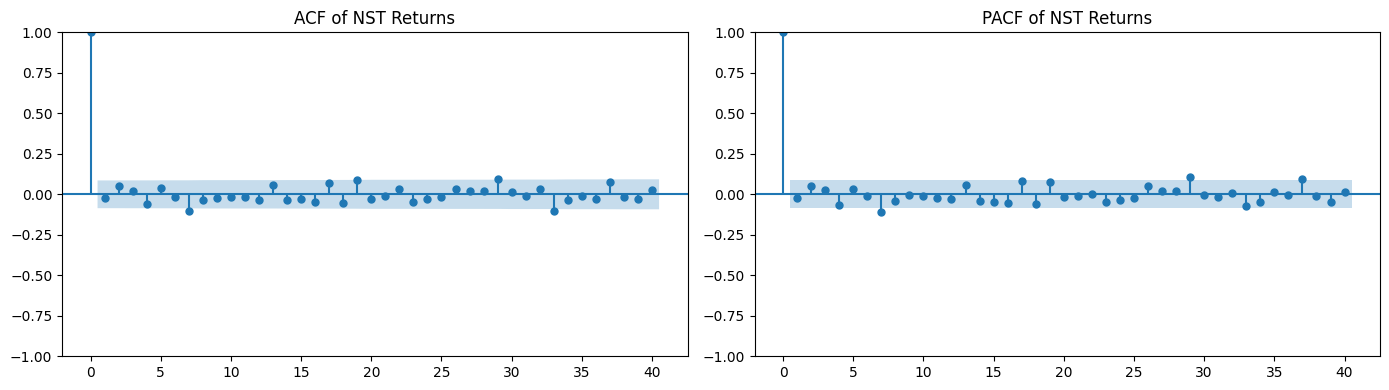

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1103.67
Distribution:                  Normal   AIC:                           2215.34
Method:            Maximum Likelihood   BIC:                           2232.38
                                        No. Observations:                  523
Date:                Sat, May 24 2025   Df Residuals:                      522
Time:                        02:51:52   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1150  8.615e-02      1.334      0.182 [-5.39

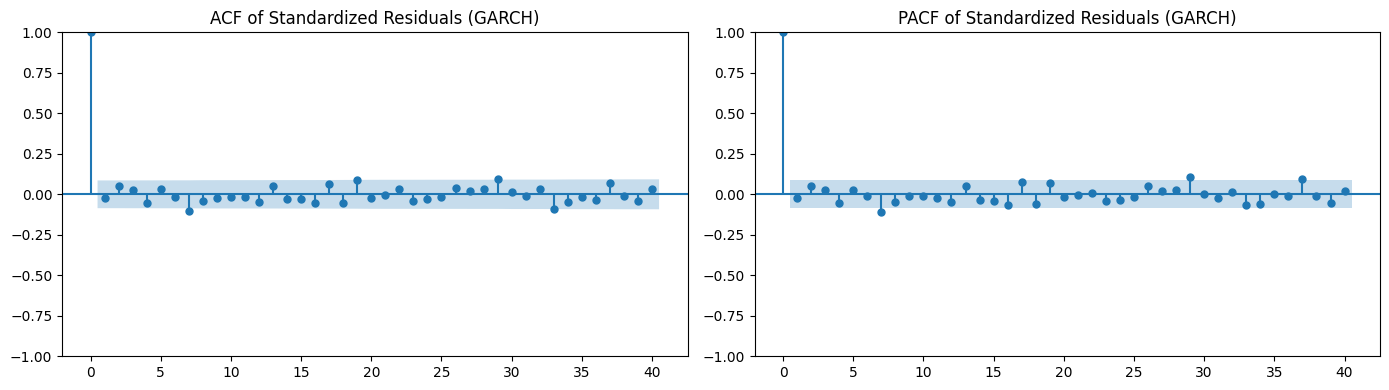

      lb_stat  lb_pvalue
10  11.149587   0.345983
20  25.164819   0.195198


In [ ]:

returns = nst.loc[:'2025-03-25', "Return"].dropna() * 100

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(returns, lags=40, ax=ax[0])
ax[0].set_title("ACF of NST Returns")
plot_pacf(returns, lags=40, ax=ax[1])
ax[1].set_title("PACF of NST Returns")
plt.tight_layout()
plt.show()

garch = arch_model(returns, vol='Garch', p=1, q=1)
garch_fitted = garch.fit(disp="off")
print(garch_fitted.summary())

resid = garch_fitted.resid / garch_fitted.conditional_volatility

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(resid, lags=40, ax=ax[0])
ax[0].set_title("ACF of Standardized Residuals (GARCH)")
plot_pacf(resid, lags=40, ax=ax[1])
ax[1].set_title("PACF of Standardized Residuals (GARCH)")
plt.tight_layout()
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
print(lb)


---

##### Model Diagnostics and Validation

After estimating the GARCH(1,1) model on NST.AX returns, we conducted a thorough diagnostic analysis:

- The autocorrelation (ACF) and partial autocorrelation (PACF) plots of the raw returns showed no significant structure, confirming stationarity.
- GARCH parameter estimates were positive and plausible, with a high degree of volatility persistence (α + β ≈ 0.97), typical for equities.
- The standardized residuals (returns adjusted for GARCH-estimated volatility) showed no remaining autocorrelation, indicating the model captured the time-varying volatility effectively.
- The Ljung-Box test for autocorrelation in the residuals yielded p-values well above 0.05, supporting the null hypothesis of no autocorrelation.

**Conclusion:**  

Based on these results, the GARCH(1,1) model is well specified for NST.AX.


In [ ]:

# Assume returns already computed: nst["Return"] = nst["Close"].pct_change()
returns = nst.loc[:'2025-03-25', "Return"].dropna() * 100  # GARCH prefers % returns

# Fit GARCH(1,1) model
garch = arch_model(returns, vol='Garch', p=1, q=1)
garch_fitted = garch.fit(disp="off")

# Get conditional volatility (forecast for last date)
garch_vol = garch_fitted.conditional_volatility.iloc[-1] / 100 * np.sqrt(252)  # annualize, back to decimals

print(f"GARCH(1,1) Forecast Volatility at 25-Mar-2025 (Annualized): {garch_vol:.2%}")

GARCH(1,1) Forecast Volatility at 25-Mar-2025 (Annualized): 29.80%


#### Volatility Selection: Implied Volatility vs. GARCH Forecast

For all Greeks and sensitivity calculations below, we use **implied volatility (IV)** derived from option prices as our primary measure of risk.

Although we have also computed a **GARCH(1,1) forecast volatility** (annualized at 29.80% as of 25-Mar-2025), this value is generally lower than the IV observed across most strikes.

**Why use IV?**
- **Market relevance:** Implied volatility reflects market participants' forward-looking expectations and is the industry standard for option pricing and risk management.
- **Prudence:** IV typically embeds a volatility premium, making it a more conservative estimate—especially during uncertain or volatile periods.
- **Forward-looking:** Unlike GARCH, which is based solely on historical data, IV incorporates current market sentiment and risk premia.

> **Summary:**  
> Implied volatility is used for all Greeks and scenario analysis in this notebook.  
> GARCH-based volatility is included only as a fallback in rare cases where IV is missing or unreliable.

---


### **Volatility Strategies: Description and Payoff Functions**

When you expect a significant increase in volatility but have no directional view, the following option strategies are most commonly used. Here are their structures and the corresponding payoff formulas (expressed in plain text for Colab):

**1. Long Straddle**

- **Structure:** Buy one call and one put, same strike (usually at-the-money, ATM) and same expiry.
- **Objective:** Profit from a large price move in either direction.
- **Payoff formula:**  
      Payoff = max(S - K, 0) + max(K - S, 0) - (Call Premium + Put Premium)  
  (where S = underlying price at expiry, K = strike)

---

**2. Long Strangle**

- **Structure:** Buy one call (out-of-the-money, higher strike), buy one put (out-of-the-money, lower strike), same expiry.
- **Objective:** Profit from a very large price move in either direction, at a lower cost than a straddle.
- **Payoff formula:**  
      Payoff = max(S - K_call, 0) + max(K_put - S, 0) - (Call Premium + Put Premium)  
  (where K_call > current spot > K_put)

---

**3. Short Butterfly Spread (using calls)**

- **Structure:**  
    - **Sell one call at a lower strike (K1)**  
    - **Buy two calls at a middle strike (ATM, K2)**  
    - **Sell one call at a higher strike (K3)**  
    - **All with the same expiry.**
- **Objective:**  
    Profit from a large move in the underlying (either up or down); risk is limited to the premium paid.
- **Payoff formula:**  
      Payoff = -max(S - K1, 0) + 2 * max(S - K2, 0) - max(S - K3, 0)  
           - (-Premium received for K1 - Premium received for K3 + 2 * Premium paid for K2)  
  (where K1 < K2 < K3 and strikes are equally spaced)

---

 **4. Reverse Iron Condor (Long Iron Condor)**

- **Structure:**
    - **Buy** one lower strike put (Kp1), OTM, farthest below spot
    - **Sell** one higher strike put (Kp2), closer to spot, still OTM
    - **Sell** one lower strike call (Kc1), just above spot
    - **Buy** one higher strike call (Kc2), farthest above spot
    - All with the same expiry.

- **Objective:**
    Profit if the underlying moves significantly up or down (i.e., high volatility), with limited risk.

- **Payoff formula:**
      Payoff =
             + [max(Kp1 - S, 0) - Premium paid for put Kp1]
             - [max(Kp2 - S, 0) - Premium received for put Kp2]
             - [max(S - Kc1, 0) - Premium received for call Kc1]
             + [max(S - Kc2, 0) - Premium paid for call Kc2]

  (where strikes are ordered: Kp1 < Kp2 < Kc1 < Kc2, and S = underlying price at expiry)

- **Comment:**
    This strategy profits from a sharp move outside the central range (either down below Kp1 or up above Kc2), with maximum loss limited to the net premium paid if the price remains between Kp2 and Kc1 at expiry.


---

In [ ]:
def payoff_long_straddle(S, K, call_ask, put_ask):
    """
    Payoff of Long Straddle:
    Buy 1 call and 1 put at the same strike (ATM), same expiry.

    S: underlying price at expiry (can be scalar or numpy array)
    K: strike price (ATM)
    call_ask: ask price paid for the call
    put_ask: ask price paid for the put

    Returns: Profit/loss at expiry for each S.

    Profit if the underlying moves significantly up or down (high volatility),
    loss limited to the net premium paid if the price stays near K.
    """
    return np.maximum(S - K, 0) + np.maximum(K - S, 0) - (call_ask + put_ask)

def payoff_long_strangle(S, Kc, call_ask, Kp, put_ask):
    """
    Payoff of Long Strangle:
    Buy 1 OTM call (higher strike), buy 1 OTM put (lower strike), same expiry.

    S: underlying price at expiry (can be scalar or numpy array)
    Kc: strike of the OTM call (above spot)
    call_ask: ask price paid for the call
    Kp: strike of the OTM put (below spot)
    put_ask: ask price paid for the put

    Returns: Profit/loss at expiry for each S.

    Profits from a large move in either direction, but requires a bigger movement
    than a straddle to be profitable. Loss limited to the net premium paid.
    """
    return np.maximum(S - Kc, 0) + np.maximum(Kp - S, 0) - (call_ask + put_ask)

def payoff_short_butterfly_call(S, K1, K2, K3, call_bid_K1, call_ask_K2, call_bid_K3):
    """
    Payoff of Short Butterfly Spread (using calls):
    Sell 1 call at K1 (lower), buy 2 calls at K2 (middle), sell 1 call at K3 (higher)
    S: underlying price at expiry (array)
    K1: lower strike
    K2: middle strike (ATM)
    K3: higher strike
    call_bid_K1: price received for call K1 (sell at bid)
    call_ask_K2: price paid for call K2 (buy at ask, multiplied by 2)
    call_bid_K3: price received for call K3 (sell at bid)
    """
    return (
        -np.maximum(S - K1, 0)
        + 2 * np.maximum(S - K2, 0)
        - np.maximum(S - K3, 0)
        - (-call_bid_K1 - call_bid_K3 + 2 * call_ask_K2)
    )

def payoff_reverse_iron_condor(
    S, Kp1, put_bid_Kp1, Kp2, put_ask_Kp2, Kc1, call_ask_Kc1, Kc2, call_bid_Kc2
):
    """
    Payoff of Reverse Iron Condor (Long Volatility):
    - Sell put Kp1 (receive bid)
    - Buy put Kp2 (pay ask)
    - Buy call Kc1 (pay ask)
    - Sell call Kc2 (receive bid)
    S: underlying price at expiry (array)
    """
    return (
        -(np.maximum(Kp1 - S, 0) - put_bid_Kp1)   # short put
        + (np.maximum(Kp2 - S, 0) - put_ask_Kp2)  # long put
        + (np.maximum(S - Kc1, 0) - call_ask_Kc1) # long call
        - (np.maximum(S - Kc2, 0) - call_bid_Kc2) # short call
    )


### Black-Scholes Greeks: Functions and Inputs

To properly compare option strategies and understand their risk exposures, we compute the main Black-Scholes Greeks for each option leg.  
For each option leg, we use the implied volatility (IV) specific to its strike and expiry, as derived from current option market prices. This ensures all Greeks are computed using the most market-consistent, forward-looking risk measure available.

Below are the main Greeks, with a brief explanation and their formula:

**1. Delta**

- **Meaning:** Sensitivity of the option price to changes in the underlying price.
- **Formula:**  
        For calls:  
      Delta = N(d1)  
        For puts:  
      Delta = N(d1) – 1  
        where  
      d1 = [ ln(S/K) + (r + 0.5 * sigma^2) * T ] / (sigma * sqrt(T))

**2. Gamma**

- **Meaning:** Sensitivity of delta to changes in the underlying price (second derivative).
- **Formula:**  
      Gamma = N'(d1) / (S * sigma * sqrt(T))  
        where N'(d1) is the standard normal density

**3. Vega**

- **Meaning:** Sensitivity of the option price to changes in implied volatility (per 1% change).
- **Formula:**  
      Vega = S * N'(d1) * sqrt(T) / 100

**4. Theta**

- **Meaning:** Sensitivity of the option price to the passage of time (decay per day).
- **Formula:**  
        For calls:  
      Theta = [ -S * N'(d1) * sigma / (2 * sqrt(T)) - r * K * exp(-rT) * N(d2) ] / 365  
        For puts:  
      Theta = [ -S * N'(d1) * sigma / (2 * sqrt(T)) + r * K * exp(-rT) * N(-d2) ] / 365  
        where  
      d2 = d1 - sigma * sqrt(T)

---

**Inputs needed:**  
- S = Current spot price of the underlying  
- K = Option strike price  
- T = Time to expiry in years  
- r = Risk-free interest rate (annualized)  
- For calls, set `call=True`; for puts, set `call=False`.

These Greeks will be computed for each option leg, and then summed (or subtracted) according to whether the position is long or short, to obtain the total exposure of each multi-leg strategy.


- **Sigma** :
    
    Volatility Input: Implied Volatility as Standard
    For every calculation, we use the implied volatility (IV) corresponding to the specific strike and expiry, derived from current option market prices.

    If the IV is not available or is not reliable (due to illiquidity or numerical issues), we use the GARCH(1,1) forecast volatility as a fallback. This approach ensures our risk calculations are market-aligned and prudent.




In [ ]:
# ---- Black-Scholes Greeks Functions ----

def bs_delta(S, K, T, r, sigma, call=True):
    """
    Black-Scholes Delta (Δ) for European options.

    Parameters:
    - S: Spot price of the underlying
    - K: Strike price
    - T: Time to expiry (in years)
    - r: Risk-free interest rate (annualized, continuous compounding)
    - sigma: Volatility (annualized, in decimals, e.g. 0.25)
    - call: True for call, False for put

    Returns:
    - Delta value (sensitivity of option price to underlying)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1) if call else norm.cdf(d1) - 1

def bs_gamma(S, K, T, r, sigma):
    """
    Black-Scholes Gamma (Γ) for European options.

    Parameters:
    - S: Spot price
    - K: Strike price
    - T: Time to expiry (years)
    - r: Risk-free rate
    - sigma: Volatility (annualized)

    Returns:
    - Gamma value (second derivative of option price w.r.t. underlying)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def bs_vega(S, K, T, r, sigma):
    """
    Black-Scholes Vega for European options.

    Parameters:
    - S: Spot price
    - K: Strike price
    - T: Time to expiry (years)
    - r: Risk-free rate
    - sigma: Volatility (annualized)

    Returns:
    - Vega value (sensitivity to volatility), per 1% change in volatility (i.e. divided by 100)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T) / 100

def bs_theta(S, K, T, r, sigma, call=True):
    """
    Black-Scholes Theta (Θ) for European options (per day).

    Parameters:
    - S: Spot price
    - K: Strike price
    - T: Time to expiry (years)
    - r: Risk-free rate
    - sigma: Volatility (annualized)
    - call: True for call, False for put

    Returns:
    - Theta value (change in option price per day)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    term1 = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
    if call:
        term2 = r * K * np.exp(-r * T) * norm.cdf(d2)
        return (term1 - term2) / 365
    else:
        term2 = r * K * np.exp(-r * T) * norm.cdf(-d2)
        return (term1 + term2) / 365

# ---- Volatility Choice Function (IV as default, fallback on GARCH) ----

def get_vol_for_greeks(expiry_date, strike, iv_dict, garch_vol):
    """
    Returns the appropriate volatility for Greeks calculation:
    - Uses implied volatility (IV) if available and in plausible range (1% < IV < 200%)
    - Falls back to GARCH volatility otherwise

    Parameters:
    - expiry_date: pd.Timestamp or similar
    - strike: float, strike price
    - iv_dict: dictionary with keys (expiry_date, strike) and values = implied volatility
    - garch_vol: fallback volatility (float, annualized)

    Returns:
    - Volatility (annualized, in decimals)
    """
    iv = iv_dict.get((expiry_date, strike), np.nan)
    if (not np.isnan(iv)) and (0.01 < iv < 2.0):
        return iv
    else:
        return garch_vol



### Explanation of Strategy Table Columns

- **Entry:**  
  The net premium paid (debit) or received (credit) to enter the strategy, calculated as:

  `Entry = Σ (Premium paid for options bought) − Σ (Premium received for options sold)`

- **Max Profit:**  
  The maximum possible profit achievable at expiry, according to the payoff structure of the strategy.

- **Max Loss:**  
  The worst-case loss at expiry, i.e. if the underlying moves unfavorably.

- **Break Even:**  
  The underlying price(s) at expiry where the strategy achieves a net zero profit/loss.  
  For most strategies, two break-even points are provided (low and high).

- **Delta:**  
  The **net delta** of the whole strategy, i.e. the sum of the Black-Scholes deltas for all legs.  
  This represents the overall sensitivity of the strategy’s value to small changes in the underlying asset price.

      Delta_strategy = sum of deltas of all legs
      Delta_call = N(d1)
      Delta_put = N(d1) - 1

- **Gamma:**  
The **net gamma** of the strategy, i.e. the sum (with sign) of the Black-Scholes gammas for all legs.  
Gamma measures how quickly the delta changes as the underlying price moves.

      Gamma_strategy = sum of gammas of all legs
      Gamma = φ(d1) / (S × σ × sqrt(T))

where φ(d1) is the standard normal PDF.

- **Vega:**  
The **net vega** of the strategy (sum over all legs).  
Vega expresses the sensitivity of the strategy’s value to a 1% change in volatility.

      Vega_strategy = sum of vegas of all legs
      Vega = S × φ(d1) × sqrt(T) / 100


- **Theta:**  
The **net theta** (time decay) of the strategy (sum over all legs).  
Theta estimates how much value the strategy loses per day, holding other variables constant.

      Theta_strategy = sum of thetas of all legs
      Theta = -[S × φ(d1) × σ / (2 × sqrt(T))] - r × K × e^(-rT) × N(±d2)


(with sign and option type; see Black-Scholes formula for details)

- **Cost per Vega:**  
This is the **main efficiency metric for volatility strategies**, and it quantifies how much you pay (or receive) for each unit of vega exposure.  
Lower values indicate a more efficient exposure to volatility (i.e., you are paying less premium for each unit of vega).


      Cost per Vega = |Entry| / |Vega_strategy|



Where:
- |Entry| is the absolute value of the net premium paid.
- |Vega_strategy| is the absolute value of the total vega of the strategy.

---

**Note:**  
- All Greeks are computed with implied volatility where available, otherwise with the GARCH estimate.
- “Unlimited” in Max Profit means there is theoretically no upper bound to profit (e.g., in long straddle/strangle).
- “Break Even” is a tuple/list with (lower BEP, upper BEP).

---


In [ ]:
def compute_long_straddle(K, call_ask, put_ask, expiry_date, S, T, r, iv_dict_calls, iv_dict_puts, garch_vol):
    """
    Metrics and Greeks for a Long Straddle (buy call ATM, buy put ATM).
    """
    entry = (call_ask + put_ask)
    max_loss = entry
    max_profit = "Unlimited"  # More rigor: math.inf or string "Unlimited"
    break_even_low = K - entry
    break_even_high = K + entry
    # Greeks: use correct IV for each leg
    sigma_call = get_vol_for_greeks(expiry_date, K, iv_dict_calls, garch_vol)
    sigma_put = get_vol_for_greeks(expiry_date, K, iv_dict_puts, garch_vol)
    delta = bs_delta(S, K, T, r, sigma_call, call=True) + bs_delta(S, K, T, r, sigma_put, call=False)
    gamma = bs_gamma(S, K, T, r, sigma_call) + bs_gamma(S, K, T, r, sigma_put)
    vega = bs_vega(S, K, T, r, sigma_call) + bs_vega(S, K, T, r, sigma_put)
    theta = bs_theta(S, K, T, r, sigma_call, call=True) + bs_theta(S, K, T, r, sigma_put, call=False)
    cost_per_vega = abs(entry) / abs(vega) if abs(vega) > 0 else np.nan
    return {
        "Entry": -entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": (break_even_low, break_even_high),
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Cost per Vega": cost_per_vega
    }

def compute_long_strangle(Kc, call_ask, Kp, put_ask, expiry_date, S, T, r, iv_dict_calls, iv_dict_puts, garch_vol):
    """
    Metrics and Greeks for a Long Strangle (buy OTM call, buy OTM put).
    """
    entry = call_ask + put_ask
    max_loss = entry
    max_profit = "Unlimited"
    break_even_low = Kp - entry
    break_even_high = Kc + entry
    sigma_call = get_vol_for_greeks(expiry_date, Kc, iv_dict_calls, garch_vol)
    sigma_put = get_vol_for_greeks(expiry_date, Kp, iv_dict_puts, garch_vol)
    delta = bs_delta(S, Kc, T, r, sigma_call, call=True) + bs_delta(S, Kp, T, r, sigma_put, call=False)
    gamma = bs_gamma(S, Kc, T, r, sigma_call) + bs_gamma(S, Kp, T, r, sigma_put)
    vega = bs_vega(S, Kc, T, r, sigma_call) + bs_vega(S, Kp, T, r, sigma_put)
    theta = bs_theta(S, Kc, T, r, sigma_call, call=True) + bs_theta(S, Kp, T, r, sigma_put, call=False)
    cost_per_vega = abs(entry) / abs(vega) if abs(vega) > 0 else np.nan
    return {
        "Entry": -entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": (break_even_low, break_even_high),
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Cost per Vega": cost_per_vega
    }

def compute_short_butterfly(
    K1, K2, K3, C1_bid, C2_ask, C3_bid, expiry_date, S, T, r, iv_dict_calls, garch_vol
):
    """
    Metrics and Greeks for a Short Butterfly Spread (reverse butterfly, long volatility).
    - Sell 1 call at K1 (receive bid)
    - Buy 2 calls at K2 (pay ask, x2)
    - Sell 1 call at K3 (receive bid)
    All with the same expiry.

    Max loss: absolute value of net debit paid (|entry|, always >0)
    Max profit: width between strikes minus |entry|
    """
    entry = C1_bid - 2 * C2_ask + C3_bid  # Net debit (should be negative for a net payment)
    width = K2 - K1  # Should be same as K3-K2

    max_loss = abs(entry)
    max_profit = -width - entry
    break_even_low = K1 + abs(entry)
    break_even_high = K3 - abs(entry)

    sigma1 = get_vol_for_greeks(expiry_date, K1, iv_dict_calls, garch_vol)
    sigma2 = get_vol_for_greeks(expiry_date, K2, iv_dict_calls, garch_vol)
    sigma3 = get_vol_for_greeks(expiry_date, K3, iv_dict_calls, garch_vol)

    delta = (
        -bs_delta(S, K1, T, r, sigma1, call=True)
        + 2 * bs_delta(S, K2, T, r, sigma2, call=True)
        - bs_delta(S, K3, T, r, sigma3, call=True)
    )
    gamma = (
        -bs_gamma(S, K1, T, r, sigma1)
        + 2 * bs_gamma(S, K2, T, r, sigma2)
        - bs_gamma(S, K3, T, r, sigma3)
    )
    vega = (
        -bs_vega(S, K1, T, r, sigma1)
        + 2 * bs_vega(S, K2, T, r, sigma2)
        - bs_vega(S, K3, T, r, sigma3)
    )
    theta = (
        -bs_theta(S, K1, T, r, sigma1, call=True)
        + 2 * bs_theta(S, K2, T, r, sigma2, call=True)
        - bs_theta(S, K3, T, r, sigma3, call=True)
    )
    cost_per_vega = abs(entry) / abs(vega) if abs(vega) > 0 else np.nan

    return {
        "Entry": entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": (break_even_low, break_even_high),
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Cost per Vega": cost_per_vega
    }


def compute_reverse_iron_condor(
    Kp1, P1_bid, Kp2, P2_ask, Kc1, C1_ask, Kc2, C2_bid,
    expiry_date, S, T, r, iv_dict_calls, iv_dict_puts, garch_vol
):
    """
    Metrics and Greeks for a Reverse Iron Condor (Long Volatility).
    - Sell put Kp1 (bid)
    - Buy put Kp2 (ask)
    - Buy call Kc1 (ask)
    - Sell call Kc2 (bid)
    All with the same expiry.
    """
    entry = -(P2_ask - P1_bid) - (C1_ask - C2_bid)  # Net premium paid

    # Compute payoff over relevant range for max profit/loss
    S_test = np.array([Kp1 - 10, Kp1 - 1, Kp2 - 1, Kc1 + 1, Kc2 + 1, Kc2 + 10])
    payoffs = payoff_reverse_iron_condor(
        S_test, Kp1, P1_bid, Kp2, P2_ask, Kc1, C1_ask, Kc2, C2_bid
    )
    max_profit = np.max(payoffs)
    max_loss = np.min(payoffs)

    break_even_low = Kp1 + entry
    break_even_high = Kc2 - entry

    sigma_p1 = get_vol_for_greeks(expiry_date, Kp1, iv_dict_puts, garch_vol)
    sigma_p2 = get_vol_for_greeks(expiry_date, Kp2, iv_dict_puts, garch_vol)
    sigma_c1 = get_vol_for_greeks(expiry_date, Kc1, iv_dict_calls, garch_vol)
    sigma_c2 = get_vol_for_greeks(expiry_date, Kc2, iv_dict_calls, garch_vol)

    delta = (
        -bs_delta(S, Kp1, T, r, sigma_p1, call=False)
        + bs_delta(S, Kp2, T, r, sigma_p2, call=False)
        + bs_delta(S, Kc1, T, r, sigma_c1, call=True)
        - bs_delta(S, Kc2, T, r, sigma_c2, call=True)
    )
    gamma = (
        -bs_gamma(S, Kp1, T, r, sigma_p1)
        + bs_gamma(S, Kp2, T, r, sigma_p2)
        + bs_gamma(S, Kc1, T, r, sigma_c1)
        - bs_gamma(S, Kc2, T, r, sigma_c2)
    )
    vega = (
        -bs_vega(S, Kp1, T, r, sigma_p1)
        + bs_vega(S, Kp2, T, r, sigma_p2)
        + bs_vega(S, Kc1, T, r, sigma_c1)
        - bs_vega(S, Kc2, T, r, sigma_c2)
    )
    theta = (
        -bs_theta(S, Kp1, T, r, sigma_p1, call=False)
        + bs_theta(S, Kp2, T, r, sigma_p2, call=False)
        + bs_theta(S, Kc1, T, r, sigma_c1, call=True)
        - bs_theta(S, Kc2, T, r, sigma_c2, call=True)
    )
    cost_per_vega = abs(entry) / abs(vega) if abs(vega) > 0 else np.nan

    return {
        "Entry": entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": (break_even_low, break_even_high),
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Cost per Vega": cost_per_vega
    }

def format_strategy_df(df):
    """
    Format the strategy results DataFrame for display:
    - Select and order relevant columns
    - Sort by 'Cost per Vega' in ascending order (best value first)
    - Round numeric columns to 2 decimal places
    - Reset the index for clean display

    Parameters:
        df (pd.DataFrame): Input DataFrame of strategies

    Returns:
        pd.DataFrame: Formatted and sorted DataFrame
    """
    # List of columns to display
    columns = [
        'Strategy', 'Expiry', 'Strikes', 'Entry', 'Max Profit', 'Max Loss',
        'Break Even', 'Delta', 'Gamma', 'Vega', 'Theta', 'Cost per Vega'
    ]
    # Only keep columns present in the DataFrame
    cols_present = [col for col in columns if col in df.columns]
    df_out = df[cols_present].sort_values(by='Cost per Vega', ascending=True)

    # Round all numeric columns (float or int) to 2 decimals
    for col in df_out.select_dtypes(include=['float', 'int']).columns:
        df_out[col] = df_out[col].round(2)

    # Optionally, round tuple columns (e.g., Break Even)
    if 'Break Even' in df_out.columns:
        df_out['Break Even'] = df_out['Break Even'].apply(
            lambda x: tuple(round(xx, 2) for xx in x) if isinstance(x, (tuple, list)) else x
        )

    # Reset index for a clean look
    return df_out.reset_index(drop=True)



#### **Setup input variables**

In [ ]:
from scipy.stats import norm
# --- Setup Option DataFrames ---
df_map = {
    "May": df_15may.copy(),
    "June": df_19jun.copy(),
    "July": df_17jul.copy()
}

# --- Assumptions ---
S = 17.90  # Underlying price (from Exhibit)
r = 0.041   # Assume 4.1% risk-free rate (annualized)
valuation_date = pd.Timestamp("2025-03-25")
expiry_dates = {
    "May": pd.Timestamp("2025-05-15"),
    "June": pd.Timestamp("2025-06-19"),
    "July": pd.Timestamp("2025-07-17")
}

#### **Straddle**

In [ ]:
# Calculate all possible straddles
straddle_list = []

for expiry, df in df_map.items():
    expiry_date = expiry_dates[expiry]
    T = (expiry_date - valuation_date).days / 365.0
    strikes = sorted(df['Strike'].unique())
    for K in strikes:
        call_ask = float(df.loc[df['Strike'] == K, 'Call_Ask'].iloc[0])
        put_ask  = float(df.loc[df['Strike'] == K, 'Put_Ask'].iloc[0])
        res = compute_long_straddle(
            K, call_ask, put_ask, expiry_date, S, T, r, iv_dict_calls, iv_dict_puts, garch_vol
        )
        straddle_list.append({
            "Strategy": "Straddle",
            "Expiry": expiry,
            "Strikes": [K],
            "Strike": K,
            "Call_Ask": call_ask,
            "Put_Ask": put_ask,
            **res
        })

df_straddle = format_strategy_df(pd.DataFrame(straddle_list))

# Sort by Cost per Vega and select the top 3
top5 = df_straddle.nsmallest(5, "Cost per Vega")

df_straddle

Strategy Expiry  Strikes  Entry Max Profit  Max Loss      Break Even  \
0   Straddle   June  [18.01]  -2.27  Unlimited      2.27  (15.74, 20.28)   
1   Straddle   July  [18.01]  -2.64  Unlimited      2.64  (15.37, 20.65)   
2   Straddle    May  [18.01]  -1.78  Unlimited      1.78  (16.23, 19.79)   
3   Straddle   July  [18.51]  -2.68  Unlimited      2.68  (15.83, 21.19)   
4   Straddle   June  [18.51]  -2.33  Unlimited      2.33  (16.18, 20.84)   
5   Straddle   June  [17.51]  -2.30  Unlimited      2.30  (15.21, 19.81)   
6   Straddle   July  [17.51]  -2.66  Unlimited      2.66  (14.85, 20.17)   
7   Straddle    May  [18.51]  -1.83  Unlimited      1.83  (16.68, 20.34)   
8   Straddle    May  [17.51]  -1.79  Unlimited      1.79   (15.72, 19.3)   
9   Straddle   July  [19.01]  -2.79  Unlimited      2.79   (16.22, 21.8)   
10  Straddle   June  [19.01]  -2.46  Unlimited      2.46  (16.55, 21.47)   
11  Straddle   July  [17.01]  -2.76  Unlimited      2.76  (14.25, 19.77)   
12  Straddle   June  [17.01]  -2.40  Unlimited      2.40  (14.61, 19.41)   
13  Straddle    May  [19.01]  -1.98  Unlimited      1.98  (17.03, 20.99)   
14  Straddle    May  [17.01]  -1.93  Unlimited      1.93  (15.08, 18.94)   
15  Straddle   July  [16.51]  -2.92  Unlimited      2.92  (13.59, 19.43)   
16  Straddle   June  [16.51]  -2.58  Unlimited      2.58  (13.93, 19.09)   
17  Straddle    May  [16.51]  -2.15  Unlimited      2.15  (14.36, 18.66)   

    Delta  Gamma  Vega  Theta  Cost per Vega  
0    0.08   0.29  0.07  -0.01          32.90  
1    0.10   0.25  0.08  -0.01          33.34  
2    0.04   0.38  0.05  -0.02          33.39  
3   -0.03   0.26  0.08  -0.01          33.59  
4   -0.07   0.30  0.07  -0.01          33.73  
5    0.22   0.28  0.07  -0.01          34.55  
6    0.23   0.25  0.08  -0.01          34.73  
7   -0.15   0.38  0.05  -0.02          34.86  
8    0.23   0.37  0.05  -0.02          35.04  
9   -0.15   0.25  0.08  -0.01          35.56  
10  -0.20   0.29  0.07  -0.01          36.70  
11   0.35   0.23  0.07  -0.01          38.25  
12   0.36   0.26  0.06  -0.01          38.72  
13  -0.32   0.36  0.05  -0.01          40.42  
14   0.41   0.33  0.05  -0.01          41.88  
15   0.46   0.21  0.07  -0.01          44.21  
16   0.49   0.23  0.06  -0.01          46.36  
17   0.57   0.28  0.04  -0.01          55.01

In [ ]:
top5 = df_straddle.nsmallest(5, "Cost per Vega").copy()

# Function to highlight best/worst values for each metric
def highlight_extremes(s, better="min"):
    color_max = 'background-color: #ffcccc'  # light red
    color_min = 'background-color: #ccffcc'  # light green
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_min if b else color_max if w else ''
        for b, w in zip(is_best, is_worst)
    ]

# Define which columns to highlight and which rule to use
highlight_map = {
    "Entry": "max",         # Higher is better
    "Max Loss": "min",      # Lower is better
    "Delta": "delta0",      # Closer to 0 is better
    "Vega": "max",          # Higher is better
    "Cost per Vega": "min"  # Lower is better
}

# Format function for "Break Even" column: always display as (low, high)
def format_breakeven(x):
    if isinstance(x, (tuple, list, np.ndarray)) and len(x) == 2:
        return f"({x[0]:.2f}, {x[1]:.2f})"
    return str(x)

# Format function for "Strikes" column
def format_strikes(x):
    if isinstance(x, (list, np.ndarray)) and len(x) == 1:
        return f"{x[0]:.2f}"
    elif isinstance(x, (list, np.ndarray, tuple)):
        return "(" + ", ".join([f"{xx:.2f}" for xx in x]) + ")"
    return str(x)

# Select top 5 by "Cost per Vega" and make a copy for display
top5_full = df_straddle.nsmallest(5, "Cost per Vega").copy()

# Format the "Break Even" column
if "Break Even" in top5_full.columns:
    top5_full["Break Even"] = top5_full["Break Even"].apply(format_breakeven)

# Format the "Strikes" column
if "Strikes" in top5_full.columns:
    top5_full["Strikes"] = top5_full["Strikes"].apply(format_strikes)

# Apply highlighting and formatting styles
styled = top5_full.style

# Apply coloring for best/worst in each selected column
for col, crit in highlight_map.items():
    if col in top5_full.columns:
        styled = styled.apply(highlight_extremes, better=crit, subset=[col])

# Numeric formatting: only for columns in highlight_map
for col in highlight_map.keys():
    if col in top5_full.columns:
        styled = styled.format({col: "{:.2f}"})

# Center the "Break Even" column for better readability
if "Break Even" in top5_full.columns:
    styled = styled.set_properties(subset=["Break Even"], **{'text-align': 'center'})

# Display the final styled DataFrame
display(styled)




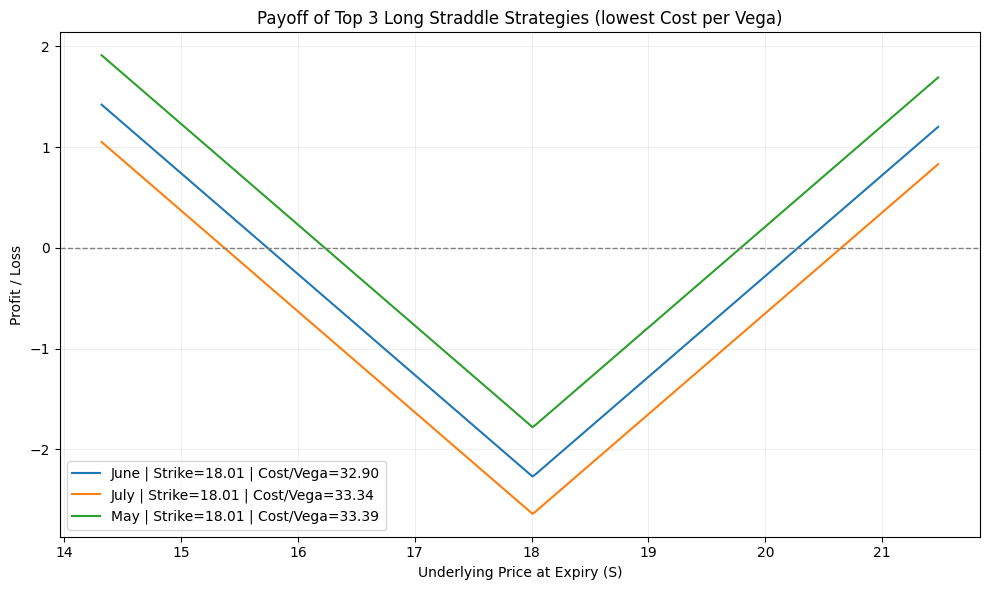

In [ ]:
DCoS_range = np.linspace(S * 0.8, S * 1.2, 300)
plt.figure(figsize=(10, 6))

# Use the raw result DataFrame for top 3
df_all = pd.DataFrame(straddle_list)
top3 = df_all.nsmallest(3, "Cost per Vega")

for idx, row in top3.iterrows():
    expiry = row['Expiry']
    K = row['Strike']
    expiry_date = expiry_dates[expiry]
    T = (expiry_date - valuation_date).days / 365.0
    # Get ask prices from the df_map for this expiry/strike
    df = df_map[expiry]
    call_ask = float(df.loc[df['Strike'] == K, 'Call_Ask'].iloc[0])
    put_ask  = float(df.loc[df['Strike'] == K, 'Put_Ask'].iloc[0])
    payoff = payoff_long_straddle(S_range, K, call_ask, put_ask)
    plt.plot(S_range, payoff, label=f"{expiry} | Strike={K} | Cost/Vega={row['Cost per Vega']:.2f}")

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Top 3 Long Straddle Strategies (lowest Cost per Vega)")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


#### Strangle

In [ ]:
# Build list of all strangles
strangle_list = []

for expiry, df in df_map.items():
    expiry_date = expiry_dates[expiry]
    T = (expiry_date - valuation_date).days / 365.0
    strikes = sorted(df['Strike'].unique())

    for Kp, Kc in combinations(strikes, 2):
        if Kp < S < Kc:  # Only sensible OTM strangles
            call_ask = float(df.loc[df['Strike'] == Kc, 'Call_Ask'].iloc[0])
            put_ask  = float(df.loc[df['Strike'] == Kp, 'Put_Ask'].iloc[0])
            res = compute_long_strangle(
                Kc, call_ask, Kp, put_ask, expiry_date, S, T, r, iv_dict_calls, iv_dict_puts, garch_vol
            )
            strangle_list.append({
                "Strategy": "Strangle",
                "Expiry": expiry,
                "Strikes": [Kp, Kc],
                "Kp": Kp,
                "Kc": Kc,
                **res
            })

# Convert to DataFrame and get top 3 by Cost per Vega
df_all_strangle = pd.DataFrame(strangle_list)
df_all_strangle_nice = format_strategy_df(pd.DataFrame(strangle_list))

df_all_strangle_nice


Strategy Expiry         Strikes  Entry Max Profit  Max Loss  \
0   Strangle    May  [16.51, 19.01]  -0.79  Unlimited      0.79   
1   Strangle    May  [17.01, 19.01]  -0.93  Unlimited      0.93   
2   Strangle   June  [16.51, 19.01]  -1.27  Unlimited      1.27   
3   Strangle    May  [16.51, 18.51]  -0.98  Unlimited      0.98   
4   Strangle   July  [16.51, 19.01]  -1.59  Unlimited      1.59   
5   Strangle   June  [17.01, 19.01]  -1.43  Unlimited      1.43   
6   Strangle    May  [17.51, 19.01]  -1.11  Unlimited      1.11   
7   Strangle    May  [17.01, 18.51]  -1.12  Unlimited      1.12   
8   Strangle   June  [16.51, 18.51]  -1.45  Unlimited      1.45   
9   Strangle   July  [17.01, 19.01]  -1.77  Unlimited      1.77   
10  Strangle   June  [17.51, 19.01]  -1.63  Unlimited      1.63   
11  Strangle   July  [16.51, 18.51]  -1.78  Unlimited      1.78   
12  Strangle   June  [17.01, 18.51]  -1.61  Unlimited      1.61   
13  Strangle    May  [17.51, 18.51]  -1.30  Unlimited      1.30   
14  Strangle   July  [17.51, 19.01]  -1.97  Unlimited      1.97   
15  Strangle   July  [17.01, 18.51]  -1.96  Unlimited      1.96   
16  Strangle    May  [16.51, 18.01]  -1.21  Unlimited      1.21   
17  Strangle   June  [17.51, 18.51]  -1.81  Unlimited      1.81   
18  Strangle   June  [16.51, 18.01]  -1.67  Unlimited      1.67   
19  Strangle    May  [17.01, 18.01]  -1.35  Unlimited      1.35   
20  Strangle   July  [17.51, 18.51]  -2.16  Unlimited      2.16   
21  Strangle   June  [17.01, 18.01]  -1.83  Unlimited      1.83   
22  Strangle   July  [16.51, 18.01]  -2.03  Unlimited      2.03   
23  Strangle   July  [17.01, 18.01]  -2.21  Unlimited      2.21   
24  Strangle    May  [17.51, 18.01]  -1.53  Unlimited      1.53   
25  Strangle   June  [17.51, 18.01]  -2.03  Unlimited      2.03   
26  Strangle   July  [17.51, 18.01]  -2.41  Unlimited      2.41   

        Break Even  Delta  Gamma  Vega  Theta  Cost per Vega  
0    (15.72, 19.8)   0.13   0.31  0.04  -0.01          17.93  
1   (16.08, 19.94)   0.05   0.34  0.05  -0.01          19.57  
2   (15.24, 20.28)   0.15   0.26  0.06  -0.01          20.71  
3   (15.53, 19.49)   0.21   0.33  0.05  -0.01          21.40  
4    (14.92, 20.6)   0.16   0.23  0.07  -0.01          22.02  
5   (15.58, 20.44)   0.08   0.27  0.06  -0.01          22.16  
6    (16.4, 20.12)  -0.04   0.36  0.05  -0.01          22.18  
7   (15.89, 19.63)   0.13   0.35  0.05  -0.02          22.73  
8   (15.06, 19.96)   0.21   0.26  0.06  -0.01          23.27  
9   (15.24, 20.78)   0.10   0.24  0.08  -0.01          23.51  
10  (15.88, 20.64)   0.01   0.28  0.07  -0.01          24.39  
11  (14.73, 20.29)   0.22   0.23  0.07  -0.01          24.43  
12   (15.4, 20.12)   0.15   0.28  0.07  -0.01          24.57  
13  (16.21, 19.81)   0.05   0.37  0.05  -0.02          25.10  
14  (15.54, 20.98)   0.04   0.25  0.08  -0.01          25.41  
15  (15.05, 20.47)   0.16   0.24  0.08  -0.01          25.81  
16   (15.3, 19.22)   0.31   0.33  0.05  -0.01          26.20  
17   (15.7, 20.32)   0.08   0.29  0.07  -0.01          26.69  
18  (14.84, 19.68)   0.29   0.26  0.06  -0.01          26.82  
19  (15.66, 19.36)   0.23   0.36  0.05  -0.02          27.18  
20  (15.35, 20.67)   0.10   0.25  0.08  -0.01          27.63  
21  (15.18, 19.84)   0.22   0.28  0.07  -0.01          27.95  
22  (14.48, 20.04)   0.28   0.23  0.07  -0.01          27.97  
23   (14.8, 20.22)   0.22   0.24  0.08  -0.01          29.22  
24  (15.98, 19.54)   0.14   0.38  0.05  -0.02          29.32  
25  (15.48, 20.04)   0.15   0.29  0.07  -0.01          29.96  
26   (15.1, 20.42)   0.16   0.25  0.08  -0.01          30.94

In [ ]:
# Function to highlight best/worst values for each metric (same as before)
def highlight_extremes(s, better="min"):
    color_max = 'background-color: #ffcccc'  # light red
    color_min = 'background-color: #ccffcc'  # light green
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_min if b else color_max if w else ''
        for b, w in zip(is_best, is_worst)
    ]

# Columns to highlight and highlight rule
highlight_map = {
    "Entry": "max",         # Higher is better
    "Max Loss": "min",      # Lower is better
    "Delta": "delta0",      # Closer to 0 is better
    "Vega": "max",          # Higher is better
    "Cost per Vega": "min"  # Lower is better
}

# Format function for "Break Even" column
def format_breakeven(x):
    if isinstance(x, (tuple, list, np.ndarray)) and len(x) == 2:
        return f"({x[0]:.2f}, {x[1]:.2f})"
    return str(x)

# Format function for "Strikes" column (now always two strikes)
def format_strikes(x):
    if isinstance(x, (list, np.ndarray, tuple)) and len(x) == 2:
        return f"({x[0]:.2f}, {x[1]:.2f})"
    return str(x)

# Select top 5 by Cost per Vega
top5_strangle = df_all_strangle_nice.nsmallest(5, "Cost per Vega").copy()

# Format columns
if "Break Even" in top5_strangle.columns:
    top5_strangle["Break Even"] = top5_strangle["Break Even"].apply(format_breakeven)
if "Strikes" in top5_strangle.columns:
    top5_strangle["Strikes"] = top5_strangle["Strikes"].apply(format_strikes)

# Apply styling
styled_strangle = top5_strangle.style
for col, crit in highlight_map.items():
    if col in top5_strangle.columns:
        styled_strangle = styled_strangle.apply(highlight_extremes, better=crit, subset=[col])

# Numeric formatting for highlighted columns only
for col in highlight_map.keys():
    if col in top5_strangle.columns:
        styled_strangle = styled_strangle.format({col: "{:.2f}"})

# Center "Break Even"
if "Break Even" in top5_strangle.columns:
    styled_strangle = styled_strangle.set_properties(subset=["Break Even"], **{'text-align': 'center'})

# Display the formatted DataFrame
display(styled_strangle)


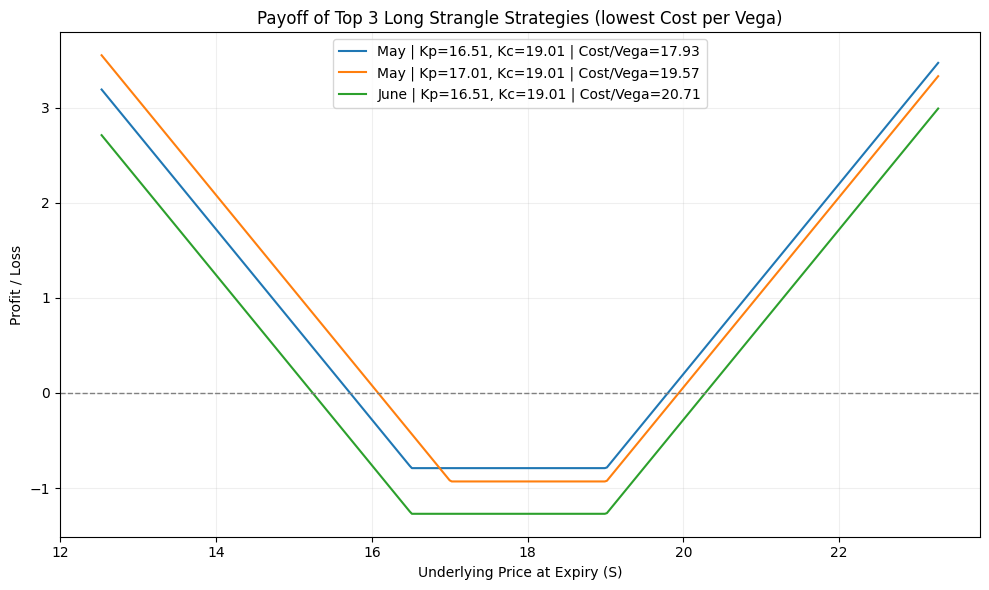

In [ ]:
top3_strangle = df_all_strangle.nsmallest(3, "Cost per Vega")

# Plot the payoff of the top 3 strangles
S_range = np.linspace(S * 0.7, S * 1.3, 400)
plt.figure(figsize=(10, 6))

for idx, row in top3_strangle.iterrows():
    expiry = row["Expiry"]
    Kp = row["Kp"]
    Kc = row["Kc"]
    # Retrieve prices from original df_map to ensure always correct
    df = df_map[expiry]
    call_ask = float(df.loc[df['Strike'] == Kc, 'Call_Ask'].iloc[0])
    put_ask  = float(df.loc[df['Strike'] == Kp, 'Put_Ask'].iloc[0])
    payoff = payoff_long_strangle(S_range, Kc, call_ask, Kp, put_ask)
    plt.plot(
        S_range, payoff,
        label=f"{expiry} | Kp={Kp}, Kc={Kc} | Cost/Vega={row['Cost per Vega']:.2f}"
    )

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Top 3 Long Strangle Strategies (lowest Cost per Vega)")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


#### Short Butterfly

In [ ]:
short_butterfly_list = []

for expiry, df in df_map.items():
    expiry_date = expiry_dates[expiry]
    T = (expiry_date - valuation_date).days / 365.0
    strikes = sorted(df['Strike'].unique())
    # K2 deve essere tra K1 e K3 e deve esistere nella griglia degli strike
    for i in range(len(strikes)):
        for j in range(i + 2, len(strikes)):  # at least one strike between the wings
            K1 = strikes[i]
            K3 = strikes[j]
            K2 = (K1 + K3) / 2
            # Only if K2 is a valid strike and not equal to K1/K3
            if (K2 in strikes) and (K2 != K1 and K2 != K3):
                C1_bid = float(df.loc[df['Strike'] == K1, 'Call_Bid'].iloc[0])
                C2_ask = float(df.loc[df['Strike'] == K2, 'Call_Ask'].iloc[0])
                C3_bid = float(df.loc[df['Strike'] == K3, 'Call_Bid'].iloc[0])
                res = compute_short_butterfly(
                    K1, K2, K3, C1_bid, C2_ask, C3_bid, expiry_date, S, T, r, iv_dict_calls, garch_vol
                )
                short_butterfly_list.append({
                    "Strategy": "Short Butterfly",
                    "Expiry": expiry,
                    "Strikes": [K1, K2, K3],
                    "K1": K1,
                    "K2": K2,
                    "K3": K3,
                    **res
                })
df_all_butterfly = pd.DataFrame(short_butterfly_list)

df_all_butterfly_nice = format_strategy_df(pd.DataFrame(short_butterfly_list))

In [ ]:
df_all_butterfly_nice

Strategy Expiry                Strikes  Entry  Max Profit  \
0   Short Butterfly    May  [17.01, 18.01, 19.01]  -0.03       -0.97   
1   Short Butterfly    May  [16.51, 17.51, 18.51]  -0.05       -0.95   
2   Short Butterfly   June  [17.01, 18.01, 19.01]  -0.09       -0.91   
3   Short Butterfly   June  [16.51, 17.51, 18.51]  -0.11       -0.89   
4   Short Butterfly   July  [17.01, 18.01, 19.01]  -0.21       -0.79   
5   Short Butterfly   July  [16.51, 17.51, 18.51]  -0.22       -0.78   
6   Short Butterfly    May  [18.01, 18.51, 19.01]  -0.14       -0.36   
7   Short Butterfly    May  [17.51, 18.01, 18.51]  -0.19       -0.31   
8   Short Butterfly    May  [17.01, 17.51, 18.01]  -0.19       -0.31   
9   Short Butterfly   June  [17.51, 18.01, 18.51]  -0.21       -0.29   
10  Short Butterfly   June  [18.01, 18.51, 19.01]  -0.20       -0.30   
11  Short Butterfly   June  [17.01, 17.51, 18.01]  -0.23       -0.27   
12  Short Butterfly    May  [16.51, 17.01, 17.51]  -0.22       -0.28   
13  Short Butterfly   June  [16.51, 17.01, 17.51]  -0.24       -0.26   
14  Short Butterfly   July  [18.01, 18.51, 19.01]  -0.26       -0.24   
15  Short Butterfly   July  [17.01, 17.51, 18.01]  -0.31       -0.19   
16  Short Butterfly   July  [17.51, 18.01, 18.51]  -0.32       -0.18   
17  Short Butterfly   July  [16.51, 17.01, 17.51]  -0.36       -0.14   

    Max Loss      Break Even  Delta  Gamma  Vega  Theta  Cost per Vega  
0       0.03  (17.04, 18.98)  -0.00   0.05  0.01   -0.0           4.80  
1       0.05  (16.56, 18.46)   0.02   0.04  0.01   -0.0           8.48  
2       0.09   (17.1, 18.92)  -0.00   0.02  0.00   -0.0          18.27  
3       0.11   (16.62, 18.4)   0.01   0.02  0.00   -0.0          23.11  
4       0.21   (17.22, 18.8)  -0.00   0.01  0.00   -0.0          48.76  
5       0.22  (16.73, 18.29)   0.01   0.01  0.00   -0.0          52.39  
6       0.14  (18.15, 18.87)  -0.01   0.01  0.00   -0.0          97.73  
7       0.19   (17.7, 18.32)  -0.00   0.01  0.00   -0.0         116.14  
8       0.19   (17.2, 17.82)   0.00   0.01  0.00   -0.0         122.64  
9       0.21   (17.72, 18.3)  -0.00   0.01  0.00   -0.0         165.97  
10      0.20  (18.21, 18.81)  -0.00   0.01  0.00   -0.0         171.15  
11      0.23  (17.24, 17.78)   0.00   0.01  0.00   -0.0         187.49  
12      0.22  (16.73, 17.29)   0.01   0.01  0.00   -0.0         189.74  
13      0.24  (16.75, 17.27)   0.01   0.00  0.00   -0.0         230.60  
14      0.26  (18.27, 18.75)  -0.00   0.00  0.00   -0.0         251.40  
15      0.31   (17.32, 17.7)   0.00   0.00  0.00   -0.0         288.53  
16      0.32  (17.83, 18.19)  -0.00   0.00  0.00   -0.0         291.19  
17      0.36  (16.87, 17.15)   0.00   0.00  0.00   -0.0         378.48

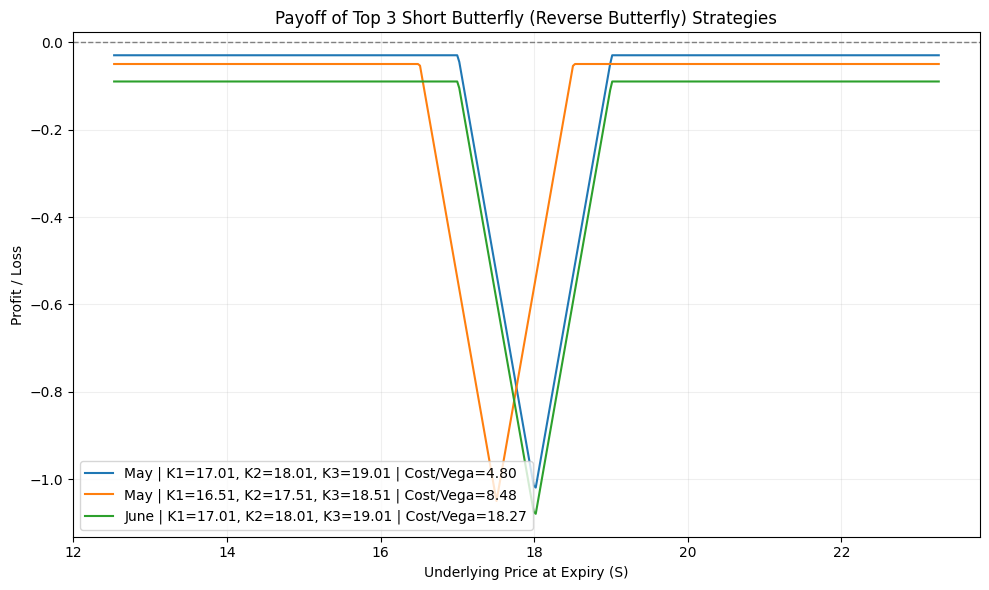

In [ ]:
top3_butterfly = df_all_butterfly.nsmallest(3, "Cost per Vega")

def payoff_short_butterfly_call(S, K1, K2, K3, call_bid_K1, call_ask_K2, call_bid_K3):
    """
    Payoff of Short Butterfly Spread (reverse butterfly, long volatility):
    Sell 1 call at K1 (bid), buy 2 calls at K2 (ask), sell 1 call at K3 (bid).
    """
    return (
        -np.maximum(S - K1, 0)
        + 2 * np.maximum(S - K2, 0)
        - np.maximum(S - K3, 0)
        - (-call_bid_K1 - call_bid_K3 + 2 * call_ask_K2)
    )

S_range = np.linspace(S * 0.7, S * 1.3, 400)
plt.figure(figsize=(10, 6))

for idx, row in top3_butterfly.iterrows():
    expiry = row["Expiry"]
    K1, K2, K3 = row["K1"], row["K2"], row["K3"]
    df = df_map[expiry]
    call_bid_K1 = float(df.loc[df['Strike'] == K1, 'Call_Bid'].iloc[0])
    call_ask_K2 = float(df.loc[df['Strike'] == K2, 'Call_Ask'].iloc[0])
    call_bid_K3 = float(df.loc[df['Strike'] == K3, 'Call_Bid'].iloc[0])
    payoff = payoff_short_butterfly_call(S_range, K1, K2, K3, call_bid_K1, call_ask_K2, call_bid_K3)
    plt.plot(
        S_range, payoff,
        label=f"{expiry} | K1={K1}, K2={K2}, K3={K3} | Cost/Vega={row['Cost per Vega']:.2f}"
    )

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Top 3 Short Butterfly (Reverse Butterfly) Strategies")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


#### **Iron Condor**

In [ ]:
reverse_iron_condor_list = []

for expiry, df in df_map.items():
    expiry_date = expiry_dates[expiry]
    T = (expiry_date - valuation_date).days / 365.0
    strikes = sorted(df['Strike'].unique())
    # Only valid combinations: Kp1 < Kp2 < Kc1 < Kc2
    for Kp1, Kp2, Kc1, Kc2 in combinations(strikes, 4):
        if Kp1 < Kp2 < Kc1 < Kc2:
            P1_bid = float(df.loc[df['Strike'] == Kp1, 'Put_Bid'].iloc[0])
            P2_ask = float(df.loc[df['Strike'] == Kp2, 'Put_Ask'].iloc[0])
            C1_ask = float(df.loc[df['Strike'] == Kc1, 'Call_Ask'].iloc[0])
            C2_bid = float(df.loc[df['Strike'] == Kc2, 'Call_Bid'].iloc[0])
            res = compute_reverse_iron_condor(
                Kp1, P1_bid, Kp2, P2_ask, Kc1, C1_ask, Kc2, C2_bid,
                expiry_date, S, T, r, iv_dict_calls, iv_dict_puts, garch_vol
            )
            reverse_iron_condor_list.append({
                "Strategy": "Reverse Iron Condor",
                "Expiry": expiry,
                "Strikes": [Kp1, Kp2, Kc1, Kc2],
                "Kp1": Kp1, "Kp2": Kp2, "Kc1": Kc1, "Kc2": Kc2,
                **res
            })

df_all_ric = pd.DataFrame(reverse_iron_condor_list)
df_all_ric_nice = format_strategy_df(df_all_ric)

# Select top 3 by Cost per Vega
top3_ric = df_all_ric.nsmallest(3, "Cost per Vega")


In [ ]:
df_all_ric_nice

Strategy Expiry                       Strikes  Entry  \
0   Reverse Iron Condor    May  [16.51, 17.51, 18.51, 19.01]  -0.66   
1   Reverse Iron Condor    May  [16.51, 17.01, 18.51, 19.01]  -0.48   
2   Reverse Iron Condor    May  [16.51, 18.01, 18.51, 19.01]  -0.91   
3   Reverse Iron Condor    May  [16.51, 17.51, 18.01, 19.01]  -0.89   
4   Reverse Iron Condor    May  [16.51, 17.51, 18.01, 18.51]  -0.74   
5   Reverse Iron Condor   June  [16.51, 17.51, 18.51, 19.01]  -0.76   
6   Reverse Iron Condor    May  [17.01, 17.51, 18.51, 19.01]  -0.53   
7   Reverse Iron Condor    May  [16.51, 17.01, 18.01, 19.01]  -0.71   
8   Reverse Iron Condor   June  [16.51, 18.01, 18.51, 19.01]  -1.00   
9   Reverse Iron Condor   June  [16.51, 17.01, 18.51, 19.01]  -0.56   
10  Reverse Iron Condor   July  [16.51, 17.51, 18.51, 19.01]  -0.83   
11  Reverse Iron Condor    May  [16.51, 17.01, 18.01, 18.51]  -0.56   
12  Reverse Iron Condor    May  [17.01, 18.01, 18.51, 19.01]  -0.78   
13  Reverse Iron Condor   July  [16.51, 18.01, 18.51, 19.01]  -1.06   
14  Reverse Iron Condor   June  [16.51, 17.51, 18.01, 18.51]  -0.80   
15  Reverse Iron Condor   June  [16.51, 17.51, 18.01, 19.01]  -0.98   
16  Reverse Iron Condor    May  [17.01, 17.51, 18.01, 19.01]  -0.76   
17  Reverse Iron Condor   July  [16.51, 17.01, 18.51, 19.01]  -0.63   
18  Reverse Iron Condor   July  [16.51, 17.51, 18.01, 18.51]  -0.89   
19  Reverse Iron Condor   June  [17.01, 17.51, 18.51, 19.01]  -0.60   
20  Reverse Iron Condor   June  [17.01, 18.01, 18.51, 19.01]  -0.84   
21  Reverse Iron Condor   June  [16.51, 17.01, 18.01, 19.01]  -0.78   
22  Reverse Iron Condor   June  [16.51, 17.01, 18.01, 18.51]  -0.60   
23  Reverse Iron Condor   July  [16.51, 17.51, 18.01, 19.01]  -1.08   
24  Reverse Iron Condor    May  [17.01, 17.51, 18.01, 18.51]  -0.61   
25  Reverse Iron Condor    May  [17.51, 18.01, 18.51, 19.01]  -0.60   
26  Reverse Iron Condor   July  [17.01, 18.01, 18.51, 19.01]  -0.90   
27  Reverse Iron Condor    May  [16.51, 17.01, 17.51, 19.01]  -0.97   
28  Reverse Iron Condor   July  [17.01, 17.51, 18.51, 19.01]  -0.67   
29  Reverse Iron Condor   July  [16.51, 17.01, 18.01, 18.51]  -0.69   
30  Reverse Iron Condor   June  [17.01, 17.51, 18.01, 19.01]  -0.82   
31  Reverse Iron Condor    May  [16.51, 17.01, 17.51, 18.01]  -0.61   
32  Reverse Iron Condor   July  [16.51, 17.01, 18.01, 19.01]  -0.88   
33  Reverse Iron Condor   June  [17.01, 17.51, 18.01, 18.51]  -0.64   
34  Reverse Iron Condor    May  [16.51, 17.01, 17.51, 18.51]  -0.82   
35  Reverse Iron Condor   June  [17.51, 18.01, 18.51, 19.01]  -0.66   
36  Reverse Iron Condor   June  [16.51, 17.01, 17.51, 18.01]  -0.65   
37  Reverse Iron Condor   July  [17.01, 17.51, 18.01, 19.01]  -0.92   
38  Reverse Iron Condor   June  [16.51, 17.01, 17.51, 19.01]  -1.05   
39  Reverse Iron Condor   July  [17.51, 18.01, 18.51, 19.01]  -0.71   
40  Reverse Iron Condor   July  [17.01, 17.51, 18.01, 18.51]  -0.73   
41  Reverse Iron Condor   July  [16.51, 17.01, 17.51, 18.01]  -0.73   
42  Reverse Iron Condor   June  [16.51, 17.01, 17.51, 18.51]  -0.87   
43  Reverse Iron Condor   July  [16.51, 17.01, 17.51, 19.01]  -1.13   
44  Reverse Iron Condor   July  [16.51, 17.01, 17.51, 18.51]  -0.94   

    Max Profit  Max Loss      Break Even  Delta  Gamma  Vega  Theta  \
0         0.34     -0.16  (15.85, 19.67)  -0.08   0.06  0.01   -0.0   
1         0.02      0.02  (16.03, 19.49)   0.01   0.04  0.01   -0.0   
2         0.59     -0.41   (15.6, 19.92)  -0.18   0.07  0.01   -0.0   
3         0.11      0.11   (15.62, 19.9)   0.01   0.06  0.01   -0.0   
4         0.26     -0.24  (15.77, 19.25)  -0.07   0.05  0.01   -0.0   
5         0.24     -0.26  (15.75, 19.77)  -0.07   0.03  0.01   -0.0   
6        -0.03     -0.03  (16.48, 19.54)  -0.00   0.03  0.00   -0.0   
7         0.29     -0.21   (15.8, 19.72)   0.10   0.04  0.01   -0.0   
8         0.50     -0.50  (15.51, 20.01)  -0.14   0.04  0.01   -0.0   
9        -0.06     -0.06  (15.95, 19.5

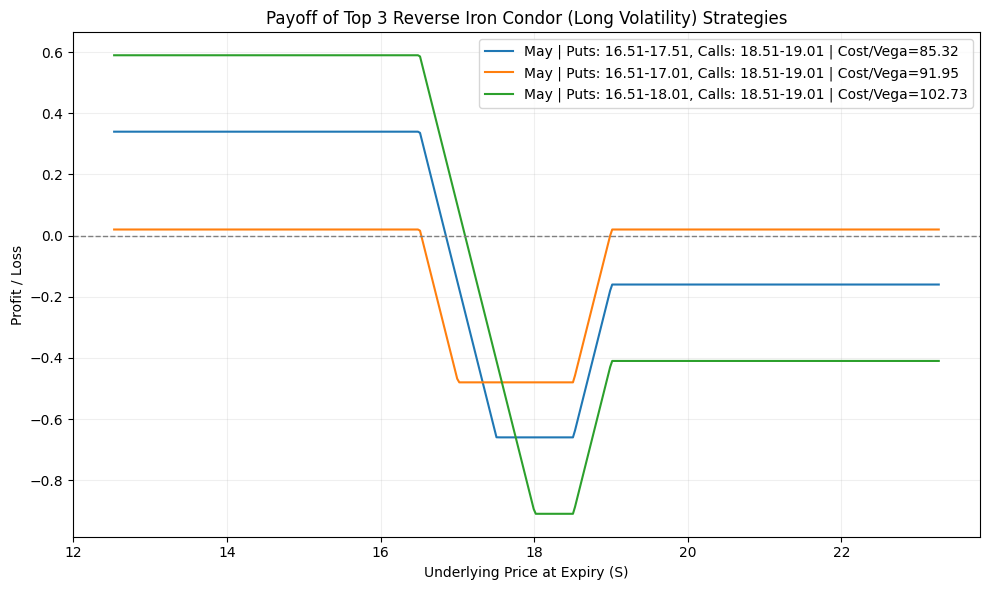

In [ ]:
S_range = np.linspace(S * 0.7, S * 1.3, 400)
plt.figure(figsize=(10, 6))
for idx, row in top3_ric.iterrows():
    expiry = row["Expiry"]
    Kp1, Kp2, Kc1, Kc2 = row["Kp1"], row["Kp2"], row["Kc1"], row["Kc2"]
    df = df_map[expiry]
    put_bid_Kp1 = float(df.loc[df['Strike'] == Kp1, 'Put_Bid'].iloc[0])
    put_ask_Kp2 = float(df.loc[df['Strike'] == Kp2, 'Put_Ask'].iloc[0])
    call_ask_Kc1 = float(df.loc[df['Strike'] == Kc1, 'Call_Ask'].iloc[0])
    call_bid_Kc2 = float(df.loc[df['Strike'] == Kc2, 'Call_Bid'].iloc[0])
    payoff = payoff_reverse_iron_condor(
        S_range, Kp1, put_bid_Kp1, Kp2, put_ask_Kp2, Kc1, call_ask_Kc1, Kc2, call_bid_Kc2
    )
    plt.plot(
        S_range, payoff,
        label=f"{expiry} | Puts: {Kp1}-{Kp2}, Calls: {Kc1}-{Kc2} | Cost/Vega={row['Cost per Vega']:.2f}"
    )

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Top 3 Reverse Iron Condor (Long Volatility) Strategies")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [ ]:
# ---- Helper function for formatting Strikes ----
def format_strikes(x):
    """
    Format the 'Strikes' column to display as comma-separated numbers (e.g., "17.01, 18.01, 19.01")
    """
    if isinstance(x, (list, tuple, np.ndarray)):
        return ", ".join([f"{float(xx):.2f}" for xx in x])
    try:
        return f"{float(x):.2f}"
    except:
        return str(x)

# ---- Highlight functions as before ----
def highlight_extremes(s, better="min"):
    color_max = 'background-color: #ffcccc'  # light red
    color_min = 'background-color: #ccffcc'  # light green
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_min if b else color_max if w else ''
        for b, w in zip(is_best, is_worst)
    ]

# ---- Format function for Break Even ----
def format_breakeven(x):
    if isinstance(x, (tuple, list, np.ndarray)) and len(x) == 2:
        return f"({x[0]:.2f}, {x[1]:.2f})"
    return str(x)

# ---- HIGHLIGHT MAP: decide which columns to color and how ----
highlight_map = {
    "Entry": "max",         # Higher is better
    "Max Loss": "min",      # Lower is better
    "Delta": "delta0",      # Closer to 0 is better
    "Vega": "max",          # Higher is better
    "Cost per Vega": "min"  # Lower is better
}

# ---- PRESENTATION FUNCTION FOR ANY STRATEGY TABLE ----
def present_top_strategies(df, n=5):
    """
    - df: DataFrame with strategy results (after computing all metrics)
    - n: number of top rows to show (by Cost per Vega)
    Returns: styled DataFrame for display (Jupyter/Colab)
    """
    # Get the top n by "Cost per Vega"
    topn = df.nsmallest(n, "Cost per Vega").copy()
    # Format Strikes for readability
    if "Strikes" in topn.columns:
        topn["Strikes"] = topn["Strikes"].apply(format_strikes)
    # Format Break Even if present
    if "Break Even" in topn.columns:
        topn["Break Even"] = topn["Break Even"].apply(format_breakeven)
    # Style
    styled = topn.style
    for col, crit in highlight_map.items():
        if col in topn.columns:
            styled = styled.apply(highlight_extremes, better=crit, subset=[col])
    # Number formatting for highlighted columns
    for col in highlight_map.keys():
        if col in topn.columns:
            styled = styled.format({col: "{:.2f}"})
    # Center Break Even
    if "Break Even" in topn.columns:
        styled = styled.set_properties(subset=["Break Even"], **{'text-align': 'center'})
    return styled

# ---- APPLY TO SHORT BUTTERFLY ----
top5_butterfly = df_all_butterfly_nice.nsmallest(5, "Cost per Vega").copy()
display(present_top_strategies(top5_butterfly, n=5))

# ---- APPLY TO REVERSE IRON CONDOR ----
top5_ric = df_all_ric_nice.nsmallest(5, "Cost per Vega").copy()
display(present_top_strategies(top5_ric, n=5))


# Task 3 (20 marks)

The Australian stock market is cautiously anticipated to experience modest growth over the next few months (Market Index, 2025; Morgan Stanley, 2025; AFR, 2024). In February, the Reserve Bank of Australia (RBA) implemented its first interest rate cut since the early stages of the COVID-19 pandemic, reducing the cash rate by 25 basis points to 4.10%. This reduction aimed to stimulate economic growth amidst a slowdown and to provide relief in financial markets (The Guardian, 2025). Market analysts, including Morgan Stanley, forecast moderate bullish momentum, projecting the S&P/ASX 200 could approach around 8,500 points by the end of 2025, driven by anticipated earnings growth of approximately 10% and attractive valuations (Morgan Stanley, 2025).

Assuming you share this modestly bullish outlook on the S&P/ASX 200 (.AXJO), this task involves examining option strategies that could effectively capitalize on the expected modest upward movement while managing the associated risks posed by current market uncertainties.

- (a) What are the two option strategies you would recommend to benefit from the bullish view on S&P/ASX 200? Explain your recommendation. Why would one be chosen over the other?

- (b) Using data information provided in Exhibit 2, construct numerical examples of each strategy for S&P/ASX 200 options, to justify your decision and comparison of the two strategies discussed in Task (3a). Explain how the strategies will work, detail all transactions for undertaking the strategies and evaluate the outcomes of two options strategies at expiry.

> Note that the profit diagrams can be constructed with the assistance of the spreadsheet OptionStrategyAnalyzer10e.xlsm. You can use as much capital as you wish. Note that you buy options at ask prices and sell options at bid prices.

#### Exhibit 2: S&P/ASX 200 option data 25th March 2025 (observation date or strategy construction date)

*Screenshot/table from LSEG Workspace with bid/ask for multiple strikes and expiries, for both calls and puts. Underlying Price: 7,981.90*

> Data source: LSEG Workspace





## Data Import – Exhibit 2

S&P/ASX 200 option data from Exhibit 2 has been manually transcribed and loaded into Python DataFrames.  
The dataset includes bid/ask prices and sizes for both calls and puts, across multiple strikes and expiries, as observed on 25th March 2025.

These DataFrames provide the basis for all subsequent analysis and option strategy simulations in this section.


In [ ]:
# --- S&P/ASX 200 (Exhibit 2) Option Data ---

# Option data for 15-May-2025 expiry (S&P/ASX 200)
data_axjo_15may = {
    'Strike':      [7900, 7925, 7950, 7975, 8000, 8025, 8050],
    'Call_Bid':    [192.00, 177.00, 161.00, 146.00, 131.00, 119.00, 106.00],
    'Call_Ask':    [209.00, 190.00, 173.00, 158.00, 143.00, 127.00, 114.00],
    'Call_BidSize':[20, 70, 70, 20, 70, 60, 20],
    'Call_AskSize':[20, 20, 20, 20, 20, 20, 20],
    'Put_Bid':     [93.00, 101.00, 109.00, 119.00, 127.00, 137.00, 149.00],
    'Put_Ask':     [102.00, 110.00, 118.00, 127.00, 139.00, 149.00, 162.00],
    'Put_BidSize': [20, 20, 40, 20, 20, 50, 50],
    'Put_AskSize': [70, 70, 20, 20, 20, 20, 70]
}
df_axjo_15may = pd.DataFrame(data_axjo_15may)
df_axjo_15may['Expiry'] = '2025-05-15'

# Option data for 19-Jun-2025 expiry (S&P/ASX 200)
data_axjo_19jun = {
    'Strike':      [7900, 7925, 7950, 7975, 8000, 8025, 8050],
    'Call_Bid':    [254.00, 238.00, 222.00, 206.00, 191.00, 178.00, 164.00],
    'Call_Ask':    [274.00, 255.00, 238.00, 223.00, 207.00, 191.00, 176.00],
    'Call_BidSize':[20, 50, 30, 30, 30, 30, 30],
    'Call_AskSize':[20, 20, 20, 50, 20, 40, 20],
    'Put_Bid':     [129.00, 137.00, 145.00, 154.00, 164.00, 174.00, 182.00],
    'Put_Ask':     [142.00, 150.00, 158.00, 167.00, 176.00, 186.00, 200.00],
    'Put_BidSize': [30, 30, 50, 50, 30, 30, 50],
    'Put_AskSize': [50, 50, 20, 20, 20, 20, 70]
}
df_axjo_19jun = pd.DataFrame(data_axjo_19jun)
df_axjo_19jun['Expiry'] = '2025-06-19'

# Option data for 17-Jul-2025 expiry (S&P/ASX 200)
data_axjo_17jul = {
    'Strike':      [7900, 7925, 7950, 7975, 8000, 8025, 8050],
    'Call_Bid':    [287.00, 273.00, 257.00, 247.00, 231.00, 216.00, 202.00],
    'Call_Ask':    [321.00, 301.00, 285.00, 263.00, 248.00, 232.00, 218.00],
    'Call_BidSize':[20, 30, 30, 30, 30, 30, 30],
    'Call_AskSize':[20, 30, 50, 20, 20, 20, 20],
    'Put_Bid':     [155.00, 163.00, 172.00, 179.00, 188.00, 198.00, 208.00],
    'Put_Ask':     [169.00, 177.00, 185.00, 194.00, 205.00, 216.00, 225.00],
    'Put_BidSize': [30, 30, 30, 50, 30, 30, 30],
    'Put_AskSize': [70, 50, 30, 20, 30, 20, 20]
}
df_axjo_17jul = pd.DataFrame(data_axjo_17jul)
df_axjo_17jul['Expiry'] = '2025-07-17'

# Optional: print a quick check
print("S&P/ASX 200 May Expiry:")
print(df_axjo_15may)
print("\nS&P/ASX 200 June Expiry:")
print(df_axjo_19jun)
print("\nS&P/ASX 200 July Expiry:")
print(df_axjo_17jul)



S&P/ASX 200 May Expiry:
   Strike  Call_Bid  Call_Ask  Call_BidSize  Call_AskSize  Put_Bid  Put_Ask  \
0    7900     192.0     209.0            20            20     93.0    102.0   
1    7925     177.0     190.0            70            20    101.0    110.0   
2    7950     161.0     173.0            70            20    109.0    118.0   
3    7975     146.0     158.0            20            20    119.0    127.0   
4    8000     131.0     143.0            70            20    127.0    139.0   
5    8025     119.0     127.0            60            20    137.0    149.0   
6    8050     106.0     114.0            20            20    149.0    162.0   

   Put_BidSize  Put_AskSize      Expiry  
0           20           70  2025-05-15  
1           20           70  2025-05-15  
2           40           20  2025-05-15  
3           20           20  2025-05-15  
4           20           20  2025-05-15  
5           50           20  2025-05-15  
6           50           70  2025-05-15  

S&P/AS

## **Volatility**

### **Implied Volatility**

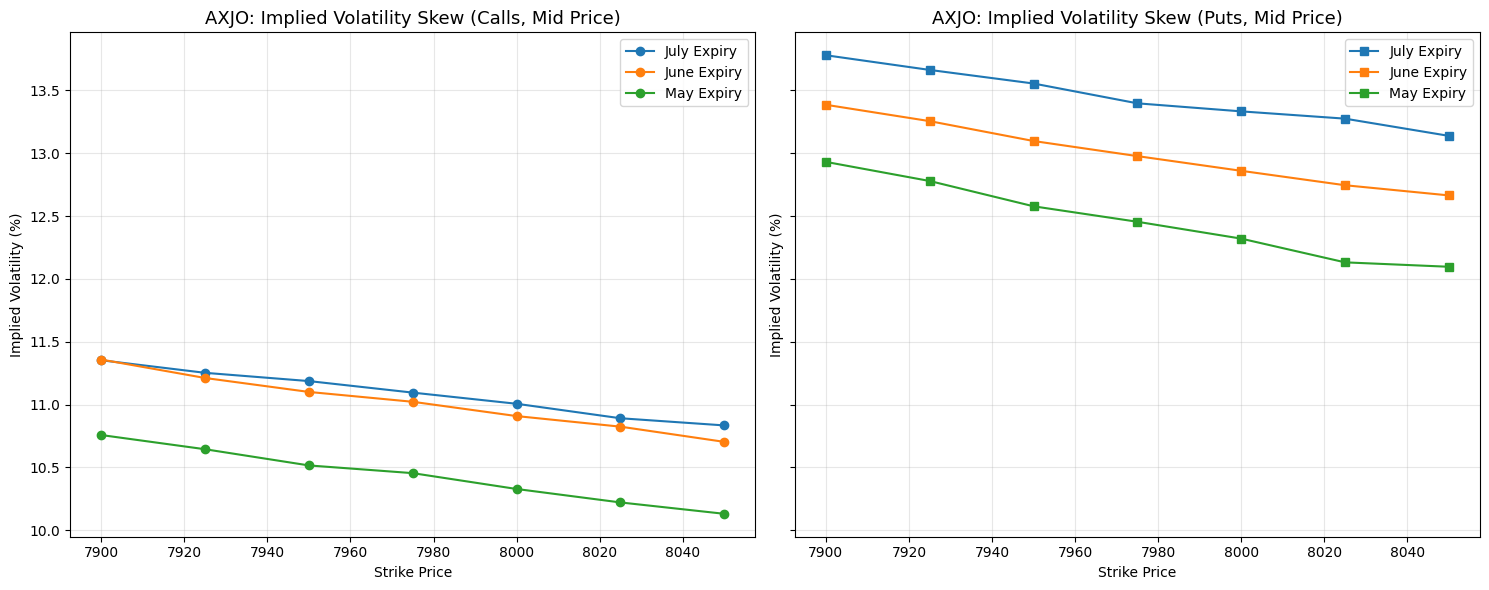

In [ ]:
# --- Option dataframes (come già creati sopra) ---
df_axjo_map = {
    "May": df_axjo_15may.copy(),
    "June": df_axjo_19jun.copy(),
    "July": df_axjo_17jul.copy()
}

# --- Set S&P/ASX 200 parameters ---
S_axjo = 7981.9  # Example: choose the "spot" price at time of data; adjust if known!
r_axjo = 0.041    # Use same risk-free rate, unless different info given
valuation_date_axjo = pd.Timestamp("2025-03-25")
expiry_dates_axjo = {
    "May": pd.Timestamp("2025-05-15"),
    "June": pd.Timestamp("2025-06-19"),
    "July": pd.Timestamp("2025-07-17")
}

# --- Implied Volatility Calculation for Exhibit 2 (S&P/ASX 200) ---

iv_dict_axjo_calls = {}
iv_dict_axjo_puts = {}
results_axjo = []

for expiry, df in df_axjo_map.items():
    expiry_date = expiry_dates_axjo[expiry]
    T = (expiry_date - valuation_date_axjo).days / 365.0
    for idx, row in df.iterrows():
        K = row["Strike"]
        # Call IV
        call_bid = row["Call_Bid"]
        call_ask = row["Call_Ask"]
        call_mid = (call_bid + call_ask) / 2
        iv_call = implied_vol_call(call_mid, S_axjo, K, T, r_axjo)
        iv_dict_axjo_calls[(expiry_date, K)] = iv_call
        # Put IV
        put_bid = row["Put_Bid"]
        put_ask = row["Put_Ask"]
        put_mid = (put_bid + put_ask) / 2
        iv_put = implied_vol_put(put_mid, S_axjo, K, T, r_axjo)
        iv_dict_axjo_puts[(expiry_date, K)] = iv_put
        # Save for DataFrame
        results_axjo.append({
            "Expiry": expiry,
            "Expiry_Date": expiry_date,
            "Strike": K,
            "Call_Mid": call_mid,
            "Put_Mid": put_mid,
            "Call_IV": iv_call,
            "Put_IV": iv_put
        })

# --- Assemble Implied Volatility DataFrame (AXJO) ---
iv_df_axjo = pd.DataFrame(results_axjo)

# --- Example plot: Volatility Smile for AXJO (Calls and Puts) ---
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
for expiry, grp in iv_df_axjo.groupby("Expiry"):
    axs[0].plot(grp["Strike"], grp["Call_IV"] * 100, marker="o", label=f"{expiry} Expiry")
    axs[1].plot(grp["Strike"], grp["Put_IV"] * 100, marker="s", label=f"{expiry} Expiry")
axs[0].set_title("AXJO: Implied Volatility Skew (Calls, Mid Price)", fontsize=13)
axs[1].set_title("AXJO: Implied Volatility Skew (Puts, Mid Price)", fontsize=13)
for ax in axs:
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility (%)")
    ax.grid(True, alpha=0.3)
    ax.legend()
plt.tight_layout()
plt.show()

# iv_dict_axjo_calls, iv_dict_axjo_puts are now ready for use in greeks calculation!


### Garch model

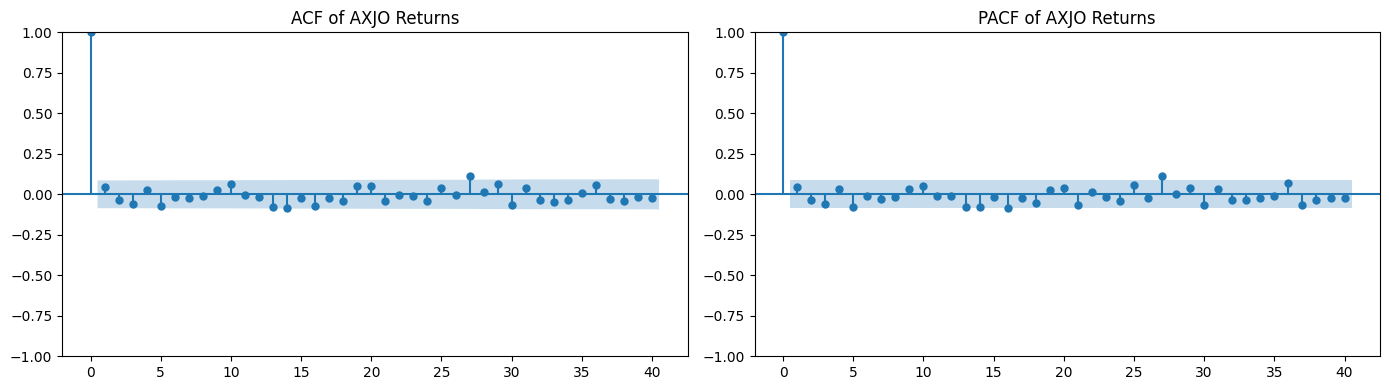

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -557.520
Distribution:                  Normal   AIC:                           1123.04
Method:            Maximum Likelihood   BIC:                           1140.08
                                        No. Observations:                  523
Date:                Sat, May 24 2025   Df Residuals:                      522
Time:                        06:34:52   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0257  3.063e-02      0.840      0.401 

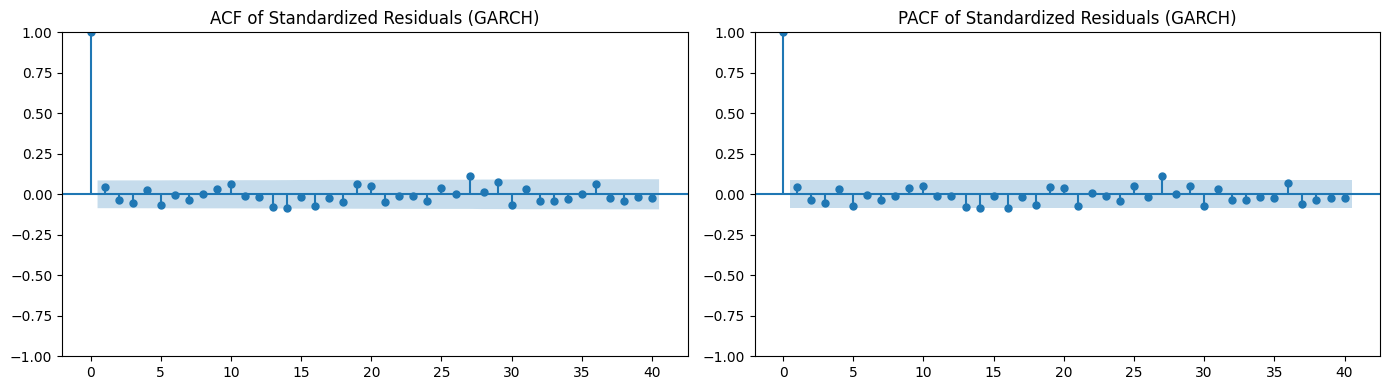

      lb_stat  lb_pvalue
10   9.424159   0.492377
20  25.403795   0.186417
GARCH(1,1) Forecast Volatility at 2025-03-25 (Annualized): 10.51%


In [ ]:
# 1. Compute log returns if not already present
if 'Return' not in axjo.columns:
    axjo['Return'] = np.log(axjo['Close'] / axjo['Close'].shift(1))

# 2. Prepare the return series up to the valuation date
valuation_date = pd.Timestamp('2025-03-25')
returns = axjo.loc[:valuation_date, 'Return'].dropna() * 100  # arch prefers returns in percent

# 3. Plot ACF and PACF of raw returns for diagnostics (optional)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(returns, lags=40, ax=ax[0])
ax[0].set_title("ACF of AXJO Returns")
plot_pacf(returns, lags=40, ax=ax[1])
ax[1].set_title("PACF of AXJO Returns")
plt.tight_layout()
plt.show()

# 4. Fit GARCH(1,1) model
garch = arch_model(returns, vol='Garch', p=1, q=1)
garch_fitted = garch.fit(disp="off")
print(garch_fitted.summary())

# 5. Compute standardized residuals for diagnostics
resid = garch_fitted.resid / garch_fitted.conditional_volatility

# 6. Plot ACF and PACF of standardized residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(resid, lags=40, ax=ax[0])
ax[0].set_title("ACF of Standardized Residuals (GARCH)")
plot_pacf(resid, lags=40, ax=ax[1])
ax[1].set_title("PACF of Standardized Residuals (GARCH)")
plt.tight_layout()
plt.show()

# 7. Ljung-Box test for autocorrelation in residuals
lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
print(lb)

# 8. Get the last conditional volatility forecast and annualize (in decimals)
garch_vol_axjo = garch_fitted.conditional_volatility.iloc[-1] / 100 * np.sqrt(252)
print(f"GARCH(1,1) Forecast Volatility at {valuation_date.date()} (Annualized): {garch_vol_axjo:.2%}")


## Bullish Strategies: Description and Payoff Functions

When you expect a modest upward movement in the underlying (bullish view), but want to manage risk, the following option strategies are commonly used. Here are their structures and the corresponding payoff formulas:

---

**1. Bull Call Spread**

- **Structure:**  
  Buy 1 call at a lower strike (K1), sell 1 call at a higher strike (K2), same expiry.  
- **Objective:**  
  Profit from moderate upside. Premium cost is reduced compared to a plain long call, but maximum profit is capped.
- **Payoff formula:**  
      Payoff = max(S - K1, 0) - max(S - K2, 0) - (Call Premium at K1 - Call Premium received at K2)

---

**2. Bull Put Spread**

- **Structure:**  
  Sell 1 put at a higher strike (K2), buy 1 put at a lower strike (K1), same expiry. (K1 < K2)  
- **Objective:**  
  Collect a net premium with limited risk. Profits if the underlying price stays above K2 at expiry.
- **Payoff formula:**  
      Payoff = [max(K1 - S, 0) - Put Premium paid at K1]  
            - [max(K2 - S, 0) - Put Premium received at K2]

- **Note:**  
  Maximum profit is the net premium received;  
  Maximum loss occurs if the underlying falls below K1 at expiry.

---

**3. Collar**

- **Market Outlook:**  
  Cautiously bullish.

- **Structure:**  
  Own stock, **buy 1 put** (lower strike X₁), **sell 1 call** (higher strike X₂), same expiry.

- **Objective:**  
  Limit downside risk, reduce hedging cost by selling a call, cap upside.

- **Zero-cost Collar:**  
  Call premium fully offsets put premium (no net option cost).

- **Payoff Formula:**  
      Payoff = (S - S₀) + max(X₁ - S, 0)
      - max(S - X₂, 0) - Put Premium at X₁
      + Call Premium at X₂


where S = price at expiry, S₀ = initial price, X₁ < S₀ < X₂.

---

**4. Covered Call**

- **Structure:**  
  Own the underlying asset, sell a call at a chosen strike (OTM).
- **Objective:**  
  Generate extra income from premium. Upside is capped at call strike.
- **Payoff formula:**  
      Payoff = (S - S0) - max(S - K, 0) + Call Premium

---

In [ ]:
def payoff_bull_call_spread(S, K1, call_ask_K1, K2, call_bid_K2):
    """
    Payoff of Bull Call Spread:
    - Buy 1 call at K1 (pay ask)
    - Sell 1 call at K2 (receive bid), K2 > K1
    S: price at expiry (can be scalar or np.array)
    Returns: Profit/Loss for each S
    """
    return (
        np.maximum(S - K1, 0)
        - np.maximum(S - K2, 0)
        - (call_ask_K1 - call_bid_K2)
    )

def payoff_bull_put_spread(S, K1, put_ask_K1, K2, put_bid_K2):
    """
    Payoff of Bull Put Spread:
    - Buy 1 put at K1 (pay ask), K1 < K2
    - Sell 1 put at K2 (receive bid)
    S: price at expiry
    Returns: Profit/Loss for each S
    """
    return (
        (np.maximum(K1 - S, 0) - put_ask_K1)
        - (np.maximum(K2 - S, 0) - put_bid_K2)
    )

def payoff_collar(S, S0, X1, put_ask_X1, X2, call_bid_X2):
    """
    Payoff of Collar:
    - Own the stock from price S0
    - Buy 1 put at X1 (pay ask)
    - Sell 1 call at X2 (receive bid), X1 < S0 < X2
    S: price at expiry
    Returns: Profit/Loss for each S
    """
    return (
        (S - S0)
        + np.maximum(X1 - S, 0)
        - np.maximum(S - X2, 0)
        - put_ask_X1
        + call_bid_X2
    )

def payoff_covered_call(S, S0, K, call_bid_K):
    """
    Payoff of Covered Call:
    - Own the stock from price S0
    - Sell 1 call at strike K (receive bid)
    S: price at expiry
    Returns: Profit/Loss for each S
    """
    return (
        (S - S0)
        - np.maximum(S - K, 0)
        + call_bid_K
    )

## Comprehensive Strategy Table: All Bullish Option Strategies

The following code systematically constructs **all possible bullish strategies** (Bull Call Spread, Bull Put Spread, Covered Call, and Collar) for every expiry and strike combination available in the S&P/ASX 200 option chain.

**Key Columns in the Table:**

- **Strategy:**  
  Indicates the strategy type (Bull Call Spread, Bull Put Spread, Covered Call, Collar).

- **Expiry:**  
  The expiration date of the option(s) used in the strategy.

- **Strike 1, Strike 2:**  
  The strikes used for the strategy.  
  - For spreads: `Strike 1` = lower strike, `Strike 2` = higher strike.  
  - For covered call: only `Strike 1` is used.  
  - For collar: `Strike 1` = put strike (protective put), `Strike 2` = call strike (covered call).

- **Net Entry:**  
  The net amount paid or received at the inception of the strategy:
  - **Positive value**: a **debit** strategy (you pay to enter; e.g. Bull Call Spread).
  - **Negative value**: a **credit** strategy (you receive cash upfront; e.g. Bull Put Spread, Covered Call).

- **Max Profit:**  
  The **maximum profit** achievable with the strategy at expiry.

- **Max Loss:**  
  The **maximum loss** possible with the strategy at expiry.

- **Break Even:**  
  The **underlying price at expiry** at which the strategy breaks even (neither profit nor loss).

- **Profit/Loss Ratio:**  
  An efficiency indicator, calculated as:  
  `Max Profit / Max Loss`  
  It represents the **reward-to-risk ratio** of each strategy.  
  - **Higher values** mean the strategy offers higher profit potential per unit of risk taken.

- **Delta:**  
  The **net delta** of the whole strategy, i.e. the sum of the Black-Scholes deltas for all legs.  
  This represents the overall sensitivity of the strategy’s value to small changes in the underlying asset price.

      Delta_strategy = sum of deltas of all legs
      Delta_call = N(d1)
      Delta_put = N(d1) - 1

- **Gamma:**  
The **net gamma** of the strategy, i.e. the sum (with sign) of the Black-Scholes gammas for all legs.  
Gamma measures how quickly the delta changes as the underlying price moves.

      Gamma_strategy = sum of gammas of all legs
      Gamma = φ(d1) / (S × σ × sqrt(T))

where φ(d1) is the standard normal PDF.

- **Vega:**  
The **net vega** of the strategy (sum over all legs).  
Vega expresses the sensitivity of the strategy’s value to a 1% change in volatility.

      Vega_strategy = sum of vegas of all legs
      Vega = S × φ(d1) × sqrt(T) / 100


- **Theta:**  
The **net theta** (time decay) of the strategy (sum over all legs).  
Theta estimates how much value the strategy loses per day, holding other variables constant.

      Theta_strategy = sum of thetas of all legs
      Theta = -[S × φ(d1) × σ / (2 × sqrt(T))] - r × K × e^(-rT) × N(±d2)


(with sign and option type; see Black-Scholes formula for details)

---

*Note: All strategies use real market bid/ask prices for option entries, ensuring results reflect realistic execution costs and liquidity. For strategies involving the underlying asset (Covered Call, Collar), it is assumed the index is purchased at the current market price.*

---

**How to use this table:**
- **Explore, filter, and compare** all possible strategy combinations.
- Use the **Net Entry** to distinguish between debit and credit trades.
- Use the **Profit/Loss Ratio** to identify strategies with the most efficient risk/reward.
- Select strategies for further analysis, visualization, or ranking according to your preferences.

---

*This table serves as a practical foundation for scenario analysis, payoff visualization, and further portfolio optimization.*



In [ ]:
def compute_bull_call_spread(
    K1, K2, call_long_ask, call_short_bid, expiry_date, S, T, r, iv_dict_calls, garch_vol
):
    """
    Metrics and Greeks for a Bull Call Spread (Buy 1 call at K1, Sell 1 call at K2).
    """
    entry = -call_long_ask + call_short_bid
    max_profit = (K2 - K1) - abs(entry)
    max_loss = abs(entry)
    break_even = K1 + abs(entry)
    # Greeks
    sigma_long = get_vol_for_greeks(expiry_date, K1, iv_dict_calls, garch_vol)
    sigma_short = get_vol_for_greeks(expiry_date, K2, iv_dict_calls, garch_vol)
    delta = bs_delta(S, K1, T, r, sigma_long, call=True) - bs_delta(S, K2, T, r, sigma_short, call=True)
    gamma = bs_gamma(S, K1, T, r, sigma_long) - bs_gamma(S, K2, T, r, sigma_short)
    vega = bs_vega(S, K1, T, r, sigma_long) - bs_vega(S, K2, T, r, sigma_short)
    theta = bs_theta(S, K1, T, r, sigma_long, call=True) - bs_theta(S, K2, T, r, sigma_short, call=True)
    indicator = max_profit / max_loss if max_loss > 0 else None
    return {
        "Entry": entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": break_even,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Profit/Loss Ratio": indicator
    }


def compute_bull_put_spread(
    K1, K2, put_long_ask, put_short_bid, expiry_date, S, T, r, iv_dict_puts, garch_vol
):
    """
    Metrics and Greeks for a Bull Put Spread (Sell 1 put at K2, Buy 1 put at K1).
    Note: K1 < K2
    """
    entry = put_short_bid - put_long_ask
    max_profit = entry
    max_loss = (K2 - K1) - entry
    break_even = K2 - entry
    sigma_short = get_vol_for_greeks(expiry_date, K2, iv_dict_puts, garch_vol)
    sigma_long = get_vol_for_greeks(expiry_date, K1, iv_dict_puts, garch_vol)
    delta = delta = bs_delta(S, K1, T, r, sigma_long, call=False) - bs_delta(S, K2, T, r, sigma_short, call=False)
    gamma = bs_gamma(S, K1, T, r, sigma_long) - bs_gamma(S, K2, T, r, sigma_short)
    vega = bs_vega(S, K1, T, r, sigma_long) - bs_vega(S, K2, T, r, sigma_short)
    theta = bs_theta(S, K1, T, r, sigma_long, call=False) - bs_theta(S, K2, T, r, sigma_short, call=False)
    indicator = max_profit / max_loss if max_loss > 0 else None
    return {
        "Entry": entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": break_even,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Profit/Loss Ratio": indicator
    }


def compute_covered_call(
    K, call_bid, underlying_price, expiry_date, S, T, r, iv_dict_calls, garch_vol
):
    """
    Metrics and Greeks for a Covered Call (Buy stock, Sell 1 call at strike K).
    """
    entry = -underlying_price + call_bid
    max_profit = (K - underlying_price) + call_bid
    max_loss = underlying_price - call_bid
    break_even = underlying_price - call_bid
    sigma_call = get_vol_for_greeks(expiry_date, K, iv_dict_calls, garch_vol)
    delta = 1 - bs_delta(S, K, T, r, sigma_call, call=True)
    gamma = -bs_gamma(S, K, T, r, sigma_call)
    vega = -bs_vega(S, K, T, r, sigma_call)
    theta = -bs_theta(S, K, T, r, sigma_call, call=True)
    indicator = max_profit / max_loss if max_loss > 0 else None
    return {
        "Entry": entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": break_even,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Profit/Loss Ratio": indicator
    }


def compute_collar(
    X1, put_ask_X1, X2, call_bid_X2, S0, expiry_date, S, T, r, iv_dict_puts, iv_dict_calls, garch_vol
):
    """
    Metrics and Greeks for a Collar (Buy stock, Buy 1 put at X1, Sell 1 call at X2).
    """
    entry = -S0 - put_ask_X1 + call_bid_X2
    max_profit = (X2 - S0) + call_bid_X2 - put_ask_X1
    max_loss = (X1 - S0) + call_bid_X2 - put_ask_X1

    break_even = S0 + put_ask_X1 - call_bid_X2
    sigma_put = get_vol_for_greeks(expiry_date, X1, iv_dict_puts, garch_vol)
    sigma_call = get_vol_for_greeks(expiry_date, X2, iv_dict_calls, garch_vol)
    delta = 1 + bs_delta(S, X1, T, r, sigma_put, call=False) - bs_delta(S, X2, T, r, sigma_call, call=True)
    gamma = bs_gamma(S, X1, T, r, sigma_put) - bs_gamma(S, X2, T, r, sigma_call)
    vega = bs_vega(S, X1, T, r, sigma_put) - bs_vega(S, X2, T, r, sigma_call)
    theta = bs_theta(S, X1, T, r, sigma_put, call=False) - bs_theta(S, X2, T, r, sigma_call, call=True)
    indicator = max_profit / max_loss if max_loss > 0 else None
    return {
        "Entry": entry,
        "Max Profit": max_profit,
        "Max Loss": max_loss,
        "Break Even": break_even,
        "Delta": delta,
        "Gamma": gamma,
        "Vega": vega,
        "Theta": theta,
        "Profit/Loss Ratio": indicator
    }

def format_strategy_df(df):
    """
    Format the strategy results DataFrame for display:
    - Select and order relevant columns
    - Sort by 'Profit/Loss Ratio' in descending order (best reward-to-risk first)
    - Round numeric columns to 2 decimal places
    - Reset the index for clean display

    Parameters:
        df (pd.DataFrame): Input DataFrame of strategies

    Returns:
        pd.DataFrame: Formatted and sorted DataFrame
    """
    # List of columns to display, update as needed
    columns = [
        'Strategy', 'Expiry', 'Strikes', 'Entry', 'Max Profit', 'Max Loss',
        'Break Even', 'Delta', 'Gamma', 'Vega', 'Theta', 'Profit/Loss Ratio'
    ]
    cols_present = [col for col in columns if col in df.columns]
    df_out = df[cols_present].sort_values(by='Profit/Loss Ratio', ascending=False)

    # Round numeric columns to 2 decimals
    for col in df_out.select_dtypes(include=['float', 'int']).columns:
        df_out[col] = df_out[col].round(2)

    # Round tuple/list columns (e.g. Break Even)
    if 'Break Even' in df_out.columns:
        df_out['Break Even'] = df_out['Break Even'].apply(
            lambda x: tuple(round(xx, 2) for xx in x) if isinstance(x, (tuple, list)) else x
        )

    return df_out.reset_index(drop=True)



### **Bull Call Spread**

In [ ]:
bull_call_list = []

for expiry, df in df_axjo_map.items():
    expiry_date = expiry_dates_axjo[expiry]
    T = (expiry_date - valuation_date_axjo).days / 365.0
    strikes = sorted(df['Strike'].unique())
    for i, K1 in enumerate(strikes[:-1]):
        for K2 in strikes[i+1:]:
            call_long_ask = float(df.loc[df['Strike'] == K1, 'Call_Ask'].iloc[0])
            call_short_bid = float(df.loc[df['Strike'] == K2, 'Call_Bid'].iloc[0])
            res = compute_bull_call_spread(
                K1, K2, call_long_ask, call_short_bid,
                expiry_date, S_axjo, T, r_axjo, iv_dict_axjo_calls, garch_vol_axjo
            )
            bull_call_list.append({
                "Strategy": "Bull Call Spread",
                "Expiry": expiry,
                "Strikes": [K1, K2],
                "K1": K1,
                "K2": K2,
                "Call_Ask (Buy)": call_long_ask,
                "Call_Bid (Sell)": call_short_bid,
                **res
            })

df_bull_call_axjo = pd.DataFrame(bull_call_list)
df_bull_call_axjo_nice = format_strategy_df(df_bull_call_axjo)

df_bull_call_axjo_nice


Strategy Expiry       Strikes  Entry  Max Profit  Max Loss  \
0   Bull Call Spread    May  [7950, 8050]  -67.0        33.0      67.0   
1   Bull Call Spread    May  [7925, 8050]  -84.0        41.0      84.0   
2   Bull Call Spread    May  [7900, 8050] -103.0        47.0     103.0   
3   Bull Call Spread    May  [7975, 8050]  -52.0        23.0      52.0   
4   Bull Call Spread    May  [7925, 8025]  -71.0        29.0      71.0   
..               ...    ...           ...    ...         ...       ...   
58  Bull Call Spread   June  [7925, 7950]  -33.0        -8.0      33.0   
59  Bull Call Spread   June  [7900, 7925]  -36.0       -11.0      36.0   
60  Bull Call Spread   July  [7950, 7975]  -38.0       -13.0      38.0   
61  Bull Call Spread   July  [7925, 7950]  -44.0       -19.0      44.0   
62  Bull Call Spread   July  [7900, 7925]  -48.0       -23.0      48.0   

    Break Even  Delta  Gamma  Vega  Theta  Profit/Loss Ratio  
0       8017.0   0.13   -0.0 -0.40  -0.11               0.49  
1       8009.0   0.16   -0.0 -0.67  -0.12               0.49  
2       8003.0   0.18   -0.0 -0.98  -0.12               0.46  
3       8027.0   0.10   -0.0 -0.19  -0.10               0.44  
4       7996.0   0.12   -0.0 -0.68  -0.08               0.41  
..         ...    ...    ...   ...    ...                ...  
58      7958.0   0.02   -0.0 -0.25  -0.01              -0.24  
59      7936.0   0.02   -0.0 -0.28  -0.01              -0.31  
60      7988.0   0.02   -0.0 -0.23  -0.01              -0.34  
61      7969.0   0.02   -0.0 -0.27  -0.01              -0.43  
62      7948.0   0.02   -0.0 -0.29  -0.01              -0.48  

[63 rows x 12 columns]

In [ ]:
# Build the Bull Call Spread strategy list for all expiries and strikes
bull_call_list = []

for expiry, df in df_axjo_map.items():
    expiry_date = expiry_dates_axjo[expiry]
    T = (expiry_date - valuation_date_axjo).days / 365.0
    strikes = sorted(df['Strike'].unique())
    # Loop over all possible strike combinations (K1 < K2)
    for i, K1 in enumerate(strikes[:-1]):
        for K2 in strikes[i+1:]:
            call_long_ask = float(df.loc[df['Strike'] == K1, 'Call_Ask'].iloc[0])
            call_short_bid = float(df.loc[df['Strike'] == K2, 'Call_Bid'].iloc[0])
            res = compute_bull_call_spread(
                K1, K2, call_long_ask, call_short_bid,
                expiry_date, S_axjo, T, r_axjo, iv_dict_axjo_calls, garch_vol_axjo
            )
            bull_call_list.append({
                "Strategy": "Bull Call Spread",
                "Expiry": expiry,
                "Strikes": [K1, K2],
                "K1": K1,
                "K2": K2,
                "Call_Ask (Buy)": call_long_ask,
                "Call_Bid (Sell)": call_short_bid,
                **res
            })

# Convert to DataFrame and format it for display
df_bull_call_axjo = pd.DataFrame(bull_call_list)
df_bull_call_axjo_nice = format_strategy_df(df_bull_call_axjo)

# Select the top 5 Bull Call Spreads by Profit/Loss Ratio
top5_bull_call = df_bull_call_axjo_nice.nlargest(5, "Profit/Loss Ratio").copy()

# Format the "Strikes" column for better readability
def format_strikes(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return "(" + ", ".join([f"{xx:.2f}" for xx in x]) + ")"
    return str(x)

if "Strikes" in top5_bull_call.columns:
    top5_bull_call["Strikes"] = top5_bull_call["Strikes"].apply(format_strikes)

# Set up highlighting criteria for each metric
highlight_map = {
    "Entry": "max",         # Higher entry is better
    "Max Profit": "max",    # Higher max profit is better
    "Max Loss": "min",      # Lower max loss is better
    "Delta": "max",         # Higher delta is better
    "Gamma": "max",         # Higher gamma is better
    "Vega": "max",          # Higher vega is better
    "Profit/Loss Ratio": "max"  # Higher P/L ratio is better
}

# Function to apply highlighting: green for best, red for worst
def highlight_extremes(s, better="max"):
    color_max = 'background-color: #ccffcc'  # green
    color_min = 'background-color: #ffcccc'  # red
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_max if b else color_min if w else ''
        for b, w in zip(is_best, is_worst)
    ]

# Apply the style and numeric formatting
styled_bull_call = top5_bull_call.style
for col, crit in highlight_map.items():
    if col in top5_bull_call.columns:
        styled_bull_call = styled_bull_call.apply(highlight_extremes, better=crit, subset=[col])
for col in highlight_map.keys():
    if col in top5_bull_call.columns:
        styled_bull_call = styled_bull_call.format({col: "{:.2f}"})

# Display the final styled DataFrame
display(styled_bull_call)


In [ ]:
# Optional: custom formatter for the Strikes column
def format_strikes(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return f"({', '.join([str(int(xx)) for xx in x])})"
    return str(x)

# Select best Bull Call Spread for each expiry (highest Profit/Loss Ratio)
best_bull_call_per_expiry = (
    df_bull_call_axjo_nice
    .sort_values("Profit/Loss Ratio", ascending=False)
    .groupby("Expiry")
    .head(1)
    .reset_index(drop=True)
)

# Format "Strikes" for nice output
if "Strikes" in best_bull_call_per_expiry.columns:
    best_bull_call_per_expiry["Strikes"] = best_bull_call_per_expiry["Strikes"].apply(format_strikes)

# Format numeric columns
for col in ["Entry", "Max Profit", "Max Loss", "Delta", "Gamma", "Vega", "Theta", "Profit/Loss Ratio"]:
    if col in best_bull_call_per_expiry.columns:
        best_bull_call_per_expiry[col] = best_bull_call_per_expiry[col].round(2)

# Define highlight rules for key columns
def highlight_extremes(s, better="min"):
    color_max = 'background-color: #ffcccc'  # light red
    color_min = 'background-color: #ccffcc'  # light green
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_min if b else color_max if w else ''
        for b, w in zip(is_best, is_worst)
    ]

highlight_map = {
    "Entry": "min",                # Lower is better
    "Max Profit": "max",           # Higher is better
    "Max Loss": "min",             # Lower is better
    "Delta": "delta0",             # Closer to 0 is better
    "Profit/Loss Ratio": "max"     # Higher is better
}

# Apply formatting and highlighting
styled = best_bull_call_per_expiry.style

for col, crit in highlight_map.items():
    if col in best_bull_call_per_expiry.columns:
        styled = styled.apply(highlight_extremes, better=crit, subset=[col])
        styled = styled.format({col: "{:.2f}"})

# Optional: center "Strikes" column
if "Strikes" in best_bull_call_per_expiry.columns:
    styled = styled.set_properties(subset=["Strikes"], **{'text-align': 'center'})

# Display the final styled table
display(styled)



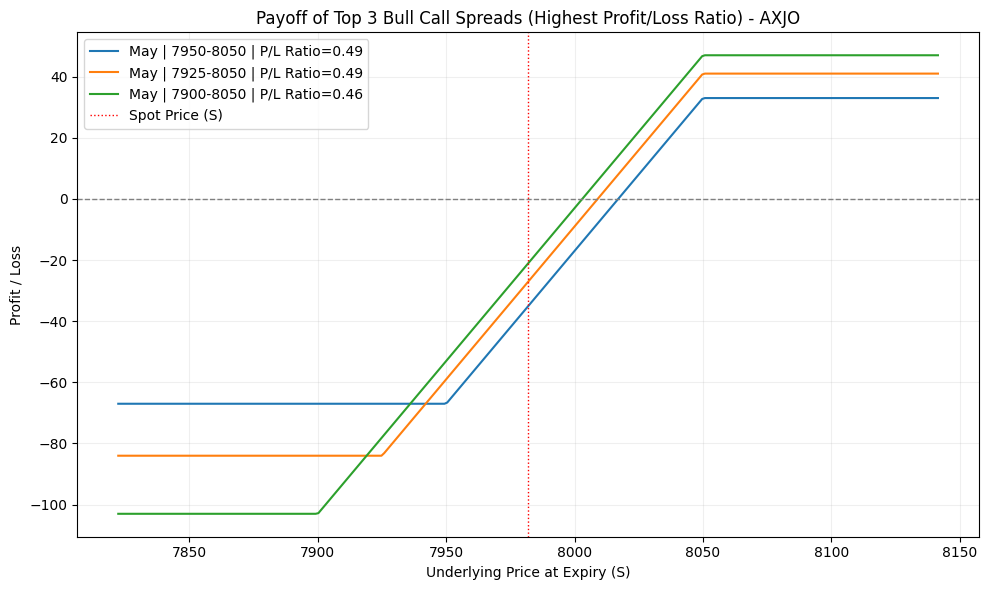

In [ ]:
# Sort by Profit/Loss Ratio and select top 3 Bull Call Spreads for illustration
top3_bull_call = df_bull_call_axjo.nlargest(3, "Profit/Loss Ratio")


# Center the x-axis around S_axjo and use a narrower range (e.g., ±5%)
span = 0.02  # 2% up and down from spot
S_range_axjo = np.linspace(S_axjo * (1 - span), S_axjo * (1 + span), 300)

plt.figure(figsize=(10, 6))

for idx, row in top3_bull_call.iterrows():
    K1 = row['K1']
    K2 = row['K2']
    call_long_ask = row['Call_Ask (Buy)']
    call_short_bid = row['Call_Bid (Sell)']
    payoff = (
        np.maximum(S_range_axjo - K1, 0) - np.maximum(S_range_axjo - K2, 0)
        - (call_long_ask - call_short_bid)
    )
    plt.plot(S_range_axjo, payoff, label=f"{row['Expiry']} | {K1}-{K2} | P/L Ratio={row['Profit/Loss Ratio']:.2f}")

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axvline(S_axjo, color='red', linestyle=':', lw=1, label='Spot Price (S)')
plt.title("Payoff of Top 3 Bull Call Spreads (Highest Profit/Loss Ratio) - AXJO")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



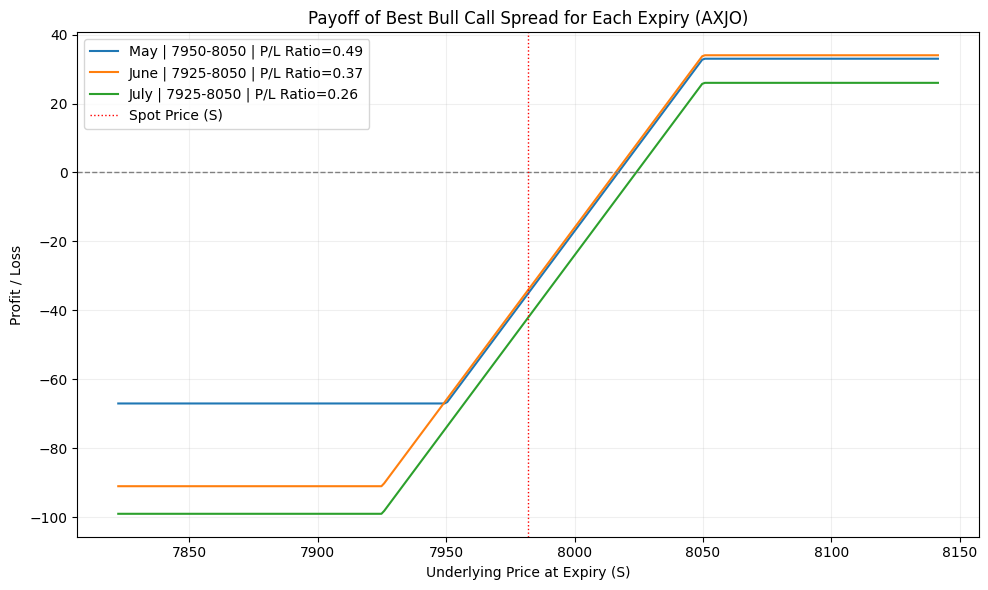

In [ ]:
# For each expiry, select the Bull Call Spread with the highest Profit/Loss Ratio
best_per_expiry = (
    df_bull_call_axjo
    .sort_values("Profit/Loss Ratio", ascending=False)
    .groupby("Expiry")
    .head(1)
)

plt.figure(figsize=(10, 6))

for idx, row in best_per_expiry.iterrows():
    K1 = row['K1']
    K2 = row['K2']
    call_long_ask = row['Call_Ask (Buy)']
    call_short_bid = row['Call_Bid (Sell)']
    payoff = (
        np.maximum(S_range_axjo - K1, 0) - np.maximum(S_range_axjo - K2, 0)
        - (call_long_ask - call_short_bid)
    )
    plt.plot(S_range_axjo, payoff, label=f"{row['Expiry']} | {K1}-{K2} | P/L Ratio={row['Profit/Loss Ratio']:.2f}")

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Best Bull Call Spread for Each Expiry (AXJO)")
plt.axvline(S_axjo, color='red', linestyle=':', lw=1, label='Spot Price (S)')
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### **Bull Put Spread**

In [ ]:
covered_call_list = []

for expiry, df in df_axjo_map.items():
    expiry_date = expiry_dates_axjo[expiry]
    T = (expiry_date - valuation_date_axjo).days / 365.0
    for idx, row in df.iterrows():
        K = row['Strike']
        call_bid = row['Call_Bid']
        res = compute_covered_call(
            K, call_bid, S_axjo, expiry_date, S_axjo, T, r_axjo, iv_dict_axjo_calls, garch_vol_axjo
        )
        covered_call_list.append({
            "Strategy": "Covered Call",
            "Expiry": expiry,
            "Strike": K,
            "Call_Bid (Sell)": call_bid,
            **res
        })

df_covered_call_axjo = pd.DataFrame(covered_call_list)
df_covered_call_axjo_nice = format_strategy_df(df_covered_call_axjo)

# Sort by Profit/Loss Ratio and select top 3 covered calls
top3_covered_call = df_covered_call_axjo.nlargest(3, "Profit/Loss Ratio")

df_covered_call_axjo

Strategy Expiry       Strikes  Entry  Max Profit  Max Loss  \
0   Bull Put Spread    May  [7900, 8050]   47.0        47.0     103.0   
1   Bull Put Spread    May  [7925, 8050]   39.0        39.0      86.0   
2   Bull Put Spread    May  [7950, 8050]   31.0        31.0      69.0   
3   Bull Put Spread    May  [7975, 8050]   22.0        22.0      53.0   
4   Bull Put Spread    May  [7900, 8025]   35.0        35.0      90.0   
..              ...    ...           ...    ...         ...       ...   
58  Bull Put Spread   July  [7900, 7925]   -6.0        -6.0      31.0   
59  Bull Put Spread   July  [7950, 7975]   -6.0        -6.0      31.0   
60  Bull Put Spread   July  [7975, 8000]   -6.0        -6.0      31.0   
61  Bull Put Spread   July  [8000, 8025]   -7.0        -7.0      32.0   
62  Bull Put Spread   July  [8025, 8050]   -8.0        -8.0      33.0   

    Break Even  Delta  Gamma  Vega  Theta  Profit/Loss Ratio  
0       8003.0   0.15   -0.0 -0.72  -0.15               0.46  
1       8011.0   0.13   -0.0 -0.49  -0.14               0.45  
2       8019.0   0.11   -0.0 -0.30  -0.12               0.45  
3       8028.0   0.08   -0.0 -0.15  -0.10               0.42  
4       7990.0   0.13   -0.0 -0.73  -0.12               0.39  
..         ...    ...    ...   ...    ...                ...  
58      7931.0   0.01   -0.0 -0.21  -0.01              -0.19  
59      7981.0   0.02   -0.0 -0.16  -0.02              -0.19  
60      8006.0   0.02   -0.0 -0.14  -0.01              -0.19  
61      8032.0   0.02   -0.0 -0.12  -0.01              -0.22  
62      8058.0   0.02   -0.0 -0.09  -0.02              -0.24  

[63 rows x 12 columns]

In [ ]:
# Build the Bull Put Spread strategy list for all expiries and strikes
bull_put_list = []

for expiry, df in df_axjo_map.items():
    expiry_date = expiry_dates_axjo[expiry]
    T = (expiry_date - valuation_date_axjo).days / 365.0
    strikes = sorted(df['Strike'].unique())
    # Bull Put Spread: Sell put at higher strike (K2), Buy put at lower strike (K1)
    for i, K1 in enumerate(strikes[:-1]):
        for K2 in strikes[i+1:]:
            put_long_ask = float(df.loc[df['Strike'] == K1, 'Put_Ask'].iloc[0])
            put_short_bid = float(df.loc[df['Strike'] == K2, 'Put_Bid'].iloc[0])
            res = compute_bull_put_spread(
                K1, K2, put_long_ask, put_short_bid,
                expiry_date, S_axjo, T, r_axjo, iv_dict_axjo_puts, garch_vol_axjo
            )
            bull_put_list.append({
                "Strategy": "Bull Put Spread",
                "Expiry": expiry,
                "Strikes": [K1, K2],
                "K1": K1,
                "K2": K2,
                "Put_Ask (Buy)": put_long_ask,
                "Put_Bid (Sell)": put_short_bid,
                **res
            })

# Convert to DataFrame and format it for display
df_bull_put_axjo = pd.DataFrame(bull_put_list)
df_bull_put_axjo_nice = format_strategy_df(df_bull_put_axjo)

# Select the top 5 Bull Put Spreads by Profit/Loss Ratio
top5_bull_put = df_bull_put_axjo_nice.nlargest(5, "Profit/Loss Ratio").copy()

# Format the "Strikes" column for better readability
if "Strikes" in top5_bull_put.columns:
    top5_bull_put["Strikes"] = top5_bull_put["Strikes"].apply(format_strikes)

# Apply highlighting to the selected metrics
styled_bull_put = top5_bull_put.style
for col, crit in highlight_map.items():
    if col in top5_bull_put.columns:
        styled_bull_put = styled_bull_put.apply(highlight_extremes, better=crit, subset=[col])
for col in highlight_map.keys():
    if col in top5_bull_put.columns:
        styled_bull_put = styled_bull_put.format({col: "{:.2f}"})

# Display the final styled DataFrame
display(styled_bull_put)


In [ ]:
# Optional: custom formatter for the Strikes column
def format_strikes(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return f"({', '.join([str(int(xx)) for xx in x])})"
    return str(x)

# Select best Bull Put Spread for each expiry (highest Profit/Loss Ratio)
best_bull_put_per_expiry = (
    df_bull_put_axjo_nice
    .sort_values("Profit/Loss Ratio", ascending=False)
    .groupby("Expiry")
    .head(1)
    .reset_index(drop=True)
)

# Format "Strikes" for nice output
if "Strikes" in best_bull_put_per_expiry.columns:
    best_bull_put_per_expiry["Strikes"] = best_bull_put_per_expiry["Strikes"].apply(format_strikes)

# Format numeric columns
for col in ["Entry", "Max Profit", "Max Loss", "Delta", "Gamma", "Vega", "Theta", "Profit/Loss Ratio"]:
    if col in best_bull_put_per_expiry.columns:
        best_bull_put_per_expiry[col] = best_bull_put_per_expiry[col].round(2)

# Define highlight rules for key columns
def highlight_extremes(s, better="min"):
    color_max = 'background-color: #ffcccc'  # light red
    color_min = 'background-color: #ccffcc'  # light green
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_min if b else color_max if w else ''
        for b, w in zip(is_best, is_worst)
    ]

highlight_map = {
    "Entry": "max",                # Higher is better (credit spread)
    "Max Profit": "max",           # Higher is better
    "Max Loss": "min",             # Lower is better
    "Delta": "delta0",             # Closer to 0 is better
    "Profit/Loss Ratio": "max"     # Higher is better
}

# Apply formatting and highlighting
styled = best_bull_put_per_expiry.style

for col, crit in highlight_map.items():
    if col in best_bull_put_per_expiry.columns:
        styled = styled.apply(highlight_extremes, better=crit, subset=[col])
        styled = styled.format({col: "{:.2f}"})

# Optional: center "Strikes" column
if "Strikes" in best_bull_put_per_expiry.columns:
    styled = styled.set_properties(subset=["Strikes"], **{'text-align': 'center'})

# Display the final styled table
display(styled)


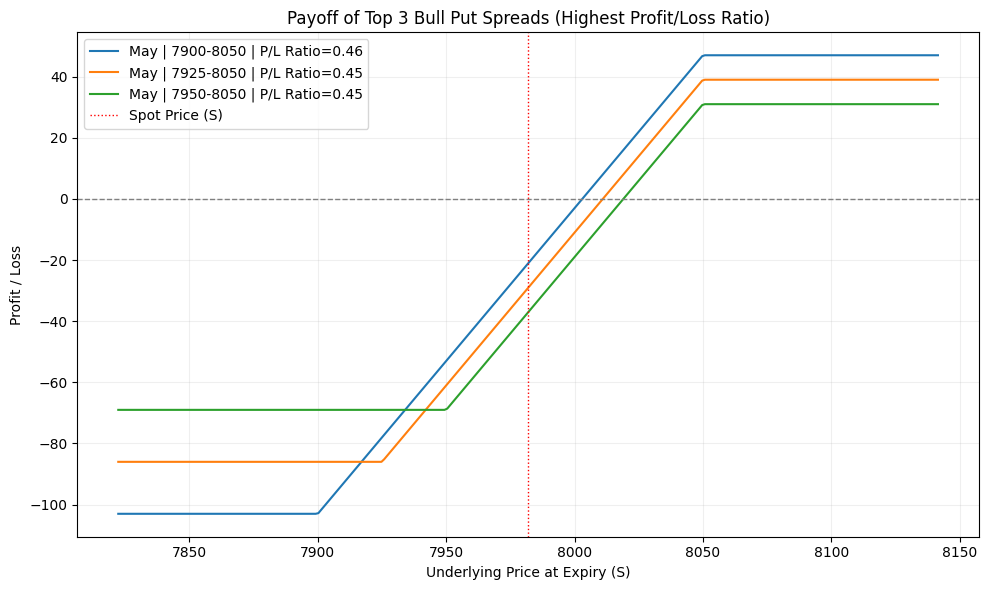

In [ ]:
# Select top 3 Bull Put Spreads by Profit/Loss Ratio
top3_put = df_bull_put_axjo.nlargest(3, "Profit/Loss Ratio")

plt.figure(figsize=(10, 6))

for idx, row in top3_put.iterrows():
    K1 = row['K1']
    K2 = row['K2']
    put_long_ask = row['Put_Ask (Buy)']
    put_short_bid = row['Put_Bid (Sell)']
    payoff = (
        np.maximum(K1 - S_range_axjo, 0) - put_long_ask
        - (np.maximum(K2 - S_range_axjo, 0) - put_short_bid)
    )
    plt.plot(S_range_axjo, payoff, label=f"{row['Expiry']} | {K1}-{K2} | P/L Ratio={row['Profit/Loss Ratio']:.2f}")

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Top 3 Bull Put Spreads (Highest Profit/Loss Ratio)")
plt.axvline(S_axjo, color='red', linestyle=':', lw=1, label='Spot Price (S)')
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


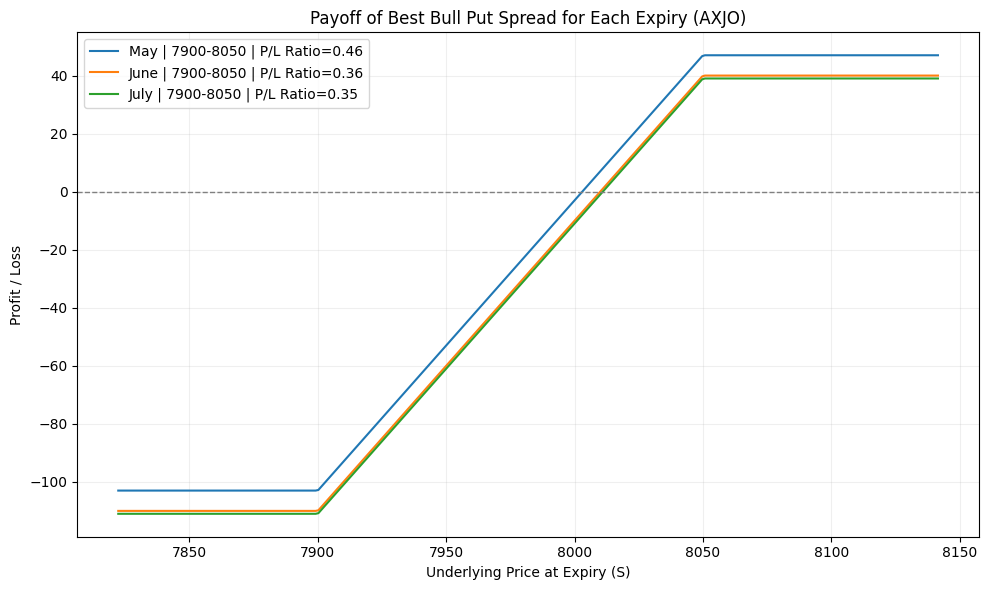

In [ ]:
# Take the best Bull Put Spread for each expiry (highest Profit/Loss Ratio)
best_put_per_expiry = (
    df_bull_put_axjo
    .sort_values("Profit/Loss Ratio", ascending=False)
    .groupby("Expiry")
    .head(1)
)

plt.figure(figsize=(10, 6))

for idx, row in best_put_per_expiry.iterrows():
    K1 = row['K1']
    K2 = row['K2']
    put_long_ask = row['Put_Ask (Buy)']
    put_short_bid = row['Put_Bid (Sell)']
    payoff = (
        np.maximum(K1 - S_range_axjo, 0) - put_long_ask
        - (np.maximum(K2 - S_range_axjo, 0) - put_short_bid)
    )
    plt.plot(S_range_axjo, payoff, label=f"{row['Expiry']} | {K1}-{K2} | P/L Ratio={row['Profit/Loss Ratio']:.2f}")

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.title("Payoff of Best Bull Put Spread for Each Expiry (AXJO)")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


### **Call covered**

In [ ]:
covered_call_list = []

for expiry, df in df_axjo_map.items():
    expiry_date = expiry_dates_axjo[expiry]
    T = (expiry_date - valuation_date_axjo).days / 365.0
    for idx, row in df.iterrows():
        K = row['Strike']
        call_bid = row['Call_Bid']
        res = compute_covered_call(
            K, call_bid, S_axjo, expiry_date, S_axjo, T, r_axjo, iv_dict_axjo_calls, garch_vol_axjo
        )
        covered_call_list.append({
            "Strategy": "Covered Call",
            "Expiry": expiry,
            "Strike": K,
            "Call_Bid (Sell)": call_bid,
            **res
        })

df_covered_call_axjo = pd.DataFrame(covered_call_list)
df_covered_call_axjo_nice = format_strategy_df(df_covered_call_axjo)

# Sort by Profit/Loss Ratio and select top 3 covered calls
top3_covered_call = df_covered_call_axjo.nlargest(3, "Profit/Loss Ratio")

df_covered_call_axjo

Strategy Expiry  Strike  Call_Bid (Sell)   Entry  Max Profit  \
0   Covered Call    May    7900            192.0 -7789.9       110.1   
1   Covered Call    May    7925            177.0 -7804.9       120.1   
2   Covered Call    May    7950            161.0 -7820.9       129.1   
3   Covered Call    May    7975            146.0 -7835.9       139.1   
4   Covered Call    May    8000            131.0 -7850.9       149.1   
5   Covered Call    May    8025            119.0 -7862.9       162.1   
6   Covered Call    May    8050            106.0 -7875.9       174.1   
7   Covered Call   June    7900            254.0 -7727.9       172.1   
8   Covered Call   June    7925            238.0 -7743.9       181.1   
9   Covered Call   June    7950            222.0 -7759.9       190.1   
10  Covered Call   June    7975            206.0 -7775.9       199.1   
11  Covered Call   June    8000            191.0 -7790.9       209.1   
12  Covered Call   June    8025            178.0 -7803.9       221.1   
13  Covered Call   June    8050            164.0 -7817.9       232.1   
14  Covered Call   July    7900            287.0 -7694.9       205.1   
15  Covered Call   July    7925            273.0 -7708.9       216.1   
16  Covered Call   July    7950            257.0 -7724.9       225.1   
17  Covered Call   July    7975            247.0 -7734.9       240.1   
18  Covered Call   July    8000            231.0 -7750.9       249.1   
19  Covered Call   July    8025            216.0 -7765.9       259.1   
20  Covered Call   July    8050            202.0 -7779.9       270.1   

    Max Loss  Break Even     Delta     Gamma       Vega     Theta  \
0     7789.9      7789.9  0.337578 -0.001139 -10.902281  1.721148   
1     7804.9      7804.9  0.365538 -0.001184 -11.220297  1.719097   
2     7820.9      7820.9  0.394623 -0.001227 -11.485270  1.708008   
3     7835.9      7835.9  0.425329 -0.001257 -11.693845  1.696620   
4     7850.9      7850.9  0.456591 -0.001287 -11.832427  1.669854   
5     7862.9      7862.9  0.488793 -0.001308 -11.898264  1.636730   
6     7875.9      7875.9  0.521587 -0.001318 -11.885530  1.596970   
7     7727.9      7727.9  0.348317 -0.000840 -14.325618  1.500608   
8     7743.9      7743.9  0.368363 -0.000868 -14.607505  1.490757   
9     7759.9      7759.9  0.389525 -0.000892 -14.860283  1.480523   
10    7775.9      7775.9  0.411580 -0.000911 -15.075574  1.469515   
11    7790.9      7790.9  0.434021 -0.000931 -15.244913  1.451900   
12    7803.9      7803.9  0.457141 -0.000946 -15.367499  1.433049   
13    7817.9      7817.9  0.480701 -0.000961 -15.438695  1.407171   
14    7694.9      7694.9  0.346006 -0.000728 -16.453122  1.371432   
15    7708.9      7708.9  0.363603 -0.000748 -16.745468  1.364772   
16    7724.9      7724.9  0.382033 -0.000764 -17.012186  1.358302   
17    7734.9      7734.9  0.400723 -0.000781 -17.242089  1.347681   
18    7750.9      7750.9  0.419911 -0.000796 -17.436174  1.334868   
19    7765.9      7765.9  0.439456 -0.000812 -17.590668  1.317652   
20    7779.9      7779.9  0.459594 -0.000821 -17.704641  1.302182   

    Profit/Loss Ratio  
0            0.014134  
1            0.015388  
2            0.016507  
3            0.017752  
4            0.018991  
5            0.020616  
6            0.022105  
7            0.022270  
8            0.023386  
9            0.024498  
10           0.025605  
11           0.026839  
12           0.028332  
13           0.029688  
14           0.026654  
15           0.028033  
16           0.029140  
17           0.031041  
18           0.032138  
19           0.033364  
20           0.034718

In [ ]:
# Define highlighting function for each metric
def highlight_extremes(s, better="min"):
    color_max = 'background-color: #ffcccc'  # light red
    color_min = 'background-color: #ccffcc'  # light green
    s_float = pd.to_numeric(s, errors="coerce")
    if better == "min":
        is_best = s_float == s_float.min()
        is_worst = s_float == s_float.max()
    elif better == "max":
        is_best = s_float == s_float.max()
        is_worst = s_float == s_float.min()
    elif better == "delta0":
        abs_vals = s_float.abs()
        is_best = abs_vals == abs_vals.min()
        is_worst = abs_vals == abs_vals.max()
    else:
        return [''] * len(s)
    return [
        color_min if b else color_max if w else ''
        for b, w in zip(is_best, is_worst)
    ]

# Select top 5 Covered Calls by Profit/Loss Ratio
top5_covered_call = df_covered_call_axjo.nlargest(5, "Profit/Loss Ratio").copy()

# Define highlight rules for Covered Call columns
highlight_map_cc = {
    "Entry": "max",                  # Higher is better (lower net cost, more premium)
    "Max Profit": "max",             # Higher is better
    "Max Loss": "min",               # Lower is better
    "Delta": "max",                  # Higher is better (more exposure to underlying)
    "Gamma": "max",                  # Higher is better
    "Vega": "delta0",                # Closer to 0 is better (less volatility sensitivity)
    "Profit/Loss Ratio": "max"       # Higher is better
}


# Apply highlighting and formatting
styled_cc = top5_covered_call.style

# Apply coloring for each column
for col, crit in highlight_map_cc.items():
    if col in top5_covered_call.columns:
        styled_cc = styled_cc.apply(highlight_extremes, better=crit, subset=[col])

# Numeric formatting for relevant columns
for col in highlight_map_cc.keys():
    if col in top5_covered_call.columns:
        styled_cc = styled_cc.format({col: "{:.2f}"})

# Display styled table
display(styled_cc)

<ipython-input-112-f781f69be3c0>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(1, 'Profit/Loss Ratio'))


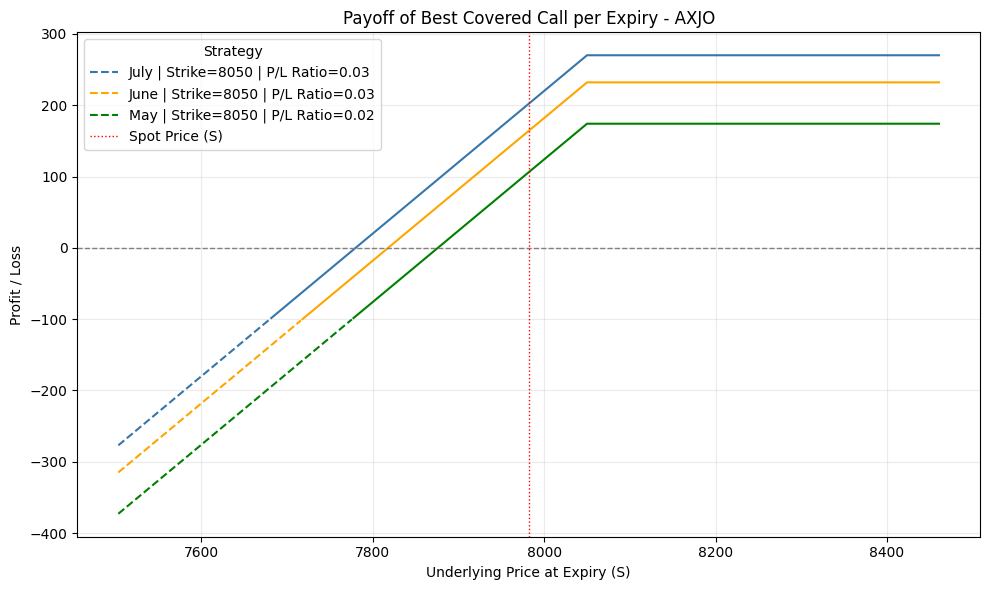

In [ ]:
# Get best covered call per expiry (highest Profit/Loss Ratio)
best_covered_per_expiry = (
    df_covered_call_axjo.groupby('Expiry')
    .apply(lambda x: x.nlargest(1, 'Profit/Loss Ratio'))
    .reset_index(drop=True)
)

span = 0.06  # ±6% around spot price
threshold = -100

S_range_cc = np.linspace(S_axjo * (1 - span), S_axjo * (1 + span), 500)
plt.figure(figsize=(10, 6))
colors = ['#3776ab', 'orange', 'green']

for idx, (i, row) in enumerate(best_covered_per_expiry.iterrows()):
    K = row['Strike']
    call_bid = row['Call_Bid (Sell)']
    expiry = row['Expiry']
    pl_ratio = row['Profit/Loss Ratio']

    payoff = (S_range_cc - S_axjo) - np.maximum(S_range_cc - K, 0) + call_bid

    # Segment curve into regions above and below threshold
    above = payoff > threshold
    start = 0
    while start < len(S_range_cc):
        # Find next contiguous region
        current = above[start]
        # Find where region ends
        end = start
        while end < len(S_range_cc) and above[end] == current:
            end += 1
        # Plot the segment
        style = '-' if current else 'dashed'
        label = f"{expiry} | Strike={K} | P/L Ratio={pl_ratio:.2f}" if start == 0 else None
        plt.plot(S_range_cc[start:end], payoff[start:end], color=colors[idx % len(colors)],
                 linestyle=style, label=label)
        start = end

plt.axhline(0, color='grey', linestyle='--', lw=1)
plt.axvline(S_axjo, color='red', linestyle=':', lw=1, label='Spot Price (S)')
plt.title("Payoff of Best Covered Call per Expiry - AXJO")
plt.xlabel("Underlying Price at Expiry (S)")
plt.ylabel("Profit / Loss")
plt.legend(title='Strategy', fontsize=10)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


#### Comparison

<ipython-input-126-41c4245b0704>:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  call_ask_Kc1_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kc1_May, 'Call_Ask'])
<ipython-input-126-41c4245b0704>:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  call_bid_Kc2_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kc2_May, 'Call_Bid'])
<ipython-input-126-41c4245b0704>:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  put_ask_Kp1_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kp1_May, 'Put_Ask'])
<ipython-input-126-41c4245b0704>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


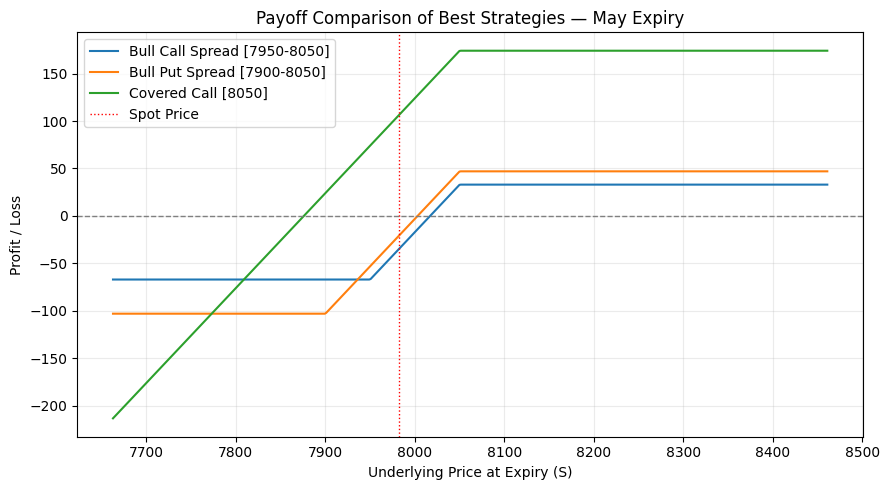

<ipython-input-126-41c4245b0704>:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  call_ask_Kc1_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kc1_Jun, 'Call_Ask'])
<ipython-input-126-41c4245b0704>:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  call_bid_Kc2_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kc2_Jun, 'Call_Bid'])
<ipython-input-126-41c4245b0704>:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  put_ask_Kp1_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kp1_Jun, 'Put_Ask'])
<ipython-input-126-41c4245b0704>:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


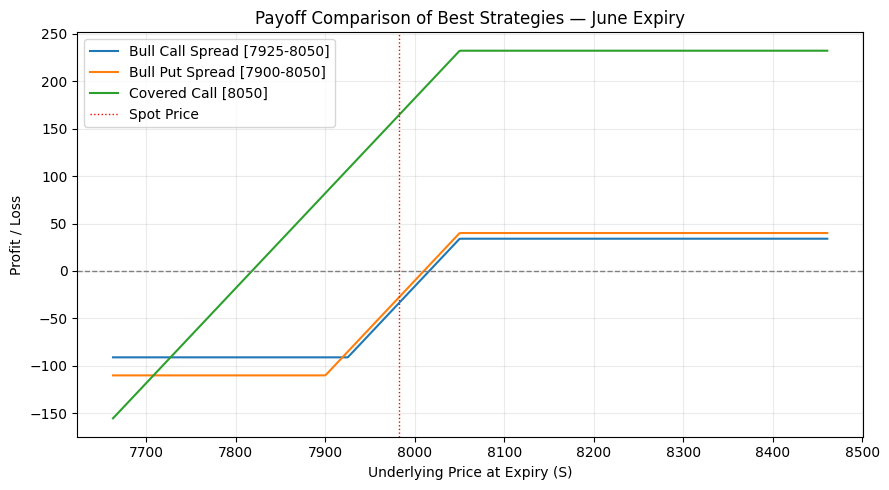

<ipython-input-126-41c4245b0704>:63: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  call_ask_Kc1_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kc1_Jul, 'Call_Ask'])
<ipython-input-126-41c4245b0704>:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  call_bid_Kc2_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kc2_Jul, 'Call_Bid'])
<ipython-input-126-41c4245b0704>:66: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  put_ask_Kp1_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kp1_Jul, 'Put_Ask'])
<ipython-input-126-41c4245b0704>:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


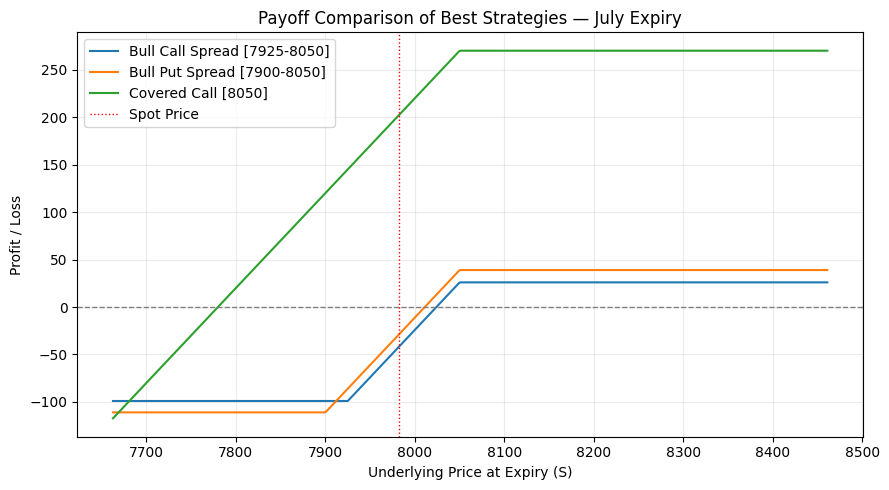

In [ ]:
def plot_expiry_comparison(expiry_label, S0, Kc1, Kc2, call_ask_Kc1, call_bid_Kc2,
                           Kp1, Kp2, put_ask_Kp1, put_bid_Kp2,
                           Kcc, call_bid_Kcc):
    S_range = np.linspace(S0 * 0.96, S0 * 1.06, 500)
    # Payoffs
    payoff_bc = np.maximum(S_range - Kc1, 0) - np.maximum(S_range - Kc2, 0) - (call_ask_Kc1 - call_bid_Kc2)
    payoff_bp = (np.maximum(Kp1 - S_range, 0) - put_ask_Kp1) - (np.maximum(Kp2 - S_range, 0) - put_bid_Kp2)
    payoff_cc = (S_range - S0) - np.maximum(S_range - Kcc, 0) + call_bid_Kcc

    plt.figure(figsize=(9, 5))
    plt.plot(S_range, payoff_bc, label=f"Bull Call Spread [{Kc1}-{Kc2}]")
    plt.plot(S_range, payoff_bp, label=f"Bull Put Spread [{Kp1}-{Kp2}]")
    plt.plot(S_range, payoff_cc, label=f"Covered Call [{Kcc}]")
    plt.axhline(0, color="grey", lw=1, linestyle="--")
    plt.axvline(S0, color='red', lw=1, linestyle=':', label='Spot Price')
    plt.xlabel("Underlying Price at Expiry (S)")
    plt.ylabel("Profit / Loss")
    plt.title(f"Payoff Comparison of Best Strategies — {expiry_label} Expiry")
    plt.legend()
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# --- Insert your best strategies for each expiry here ---
# Example for May (replace values with your actual best combos from Table 3.1-3.5)
# Maggio
S0 = S_axjo  # 7981.9
Kc1_May, Kc2_May = 7950, 8050
call_ask_Kc1_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kc1_May, 'Call_Ask'])
call_bid_Kc2_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kc2_May, 'Call_Bid'])
Kp1_May, Kp2_May = 7900, 8050
put_ask_Kp1_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kp1_May, 'Put_Ask'])
put_bid_Kp2_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kp2_May, 'Put_Bid'])
Kcc_May = 8050
call_bid_Kcc_May = float(df_axjo_15may.loc[df_axjo_15may['Strike'] == Kcc_May, 'Call_Bid'])

plot_expiry_comparison(
    "May", S0,
    Kc1_May, Kc2_May, call_ask_Kc1_May, call_bid_Kc2_May,
    Kp1_May, Kp2_May, put_ask_Kp1_May, put_bid_Kp2_May,
    Kcc_May, call_bid_Kcc_May
)

# --- Repeat for June ---
Kc1_Jun, Kc2_Jun = 7925, 8050
call_ask_Kc1_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kc1_Jun, 'Call_Ask'])
call_bid_Kc2_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kc2_Jun, 'Call_Bid'])
Kp1_Jun, Kp2_Jun = 7900, 8050
put_ask_Kp1_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kp1_Jun, 'Put_Ask'])
put_bid_Kp2_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kp2_Jun, 'Put_Bid'])
Kcc_Jun = 8050
call_bid_Kcc_Jun = float(df_axjo_19jun.loc[df_axjo_19jun['Strike'] == Kcc_Jun, 'Call_Bid'])

plot_expiry_comparison(
    "June", S0,
    Kc1_Jun, Kc2_Jun, call_ask_Kc1_Jun, call_bid_Kc2_Jun,
    Kp1_Jun, Kp2_Jun, put_ask_Kp1_Jun, put_bid_Kp2_Jun,
    Kcc_Jun, call_bid_Kcc_Jun
)

# --- Repeat for July ---
Kc1_Jul, Kc2_Jul = 7925, 8050
call_ask_Kc1_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kc1_Jul, 'Call_Ask'])
call_bid_Kc2_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kc2_Jul, 'Call_Bid'])
Kp1_Jul, Kp2_Jul = 7900, 8050
put_ask_Kp1_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kp1_Jul, 'Put_Ask'])
put_bid_Kp2_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kp2_Jul, 'Put_Bid'])
Kcc_Jul = 8050
call_bid_Kcc_Jul = float(df_axjo_17jul.loc[df_axjo_17jul['Strike'] == Kcc_Jul, 'Call_Bid'])

plot_expiry_comparison(
    "July", S0,
    Kc1_Jul, Kc2_Jul, call_ask_Kc1_Jul, call_bid_Kc2_Jul,
    Kp1_Jul, Kp2_Jul, put_ask_Kp1_Jul, put_bid_Kp2_Jul,
    Kcc_Jul, call_bid_Kcc_Jul
)


# Task 4 (37 marks)

Today is 25th March 2025, when NST's share is priced at \$17.9. Consider an NST option that expires on 17th July 2025, with a strike price of \$19. **Assume no dividends are paid on this stock**. The annual historical standard deviation of NST stocks is 28.73%. The risk-free rate is 4.0563% with annual compounding. Ignore transaction costs (e.g. bid-ask spread).

- **(a)** Using a three-step (i.e. three periods) binomial tree model, calculate theoretical prices today for:
    1. a July American put option,
    2. a July European call option,
    3. a July European put option on NST stock.

    *Draw the trees and show all calculation workings at each node.*  
    *(10 marks)*

- **(b)** For the NST European call option (with the theoretical price calculated in Task 4a): construct a hedge by combining a position in the stock with a position in the European call option on this stock. Show that the return on the hedge is the risk-free rate regardless of the outcome over each of the first two periods. You are also required to draw the tree with the stock price, hedge ratio, value of a call and a hedge portfolio showing at each node (for the first two periods/steps only). Assume that the call sells for the theoretical value.  
    *(10 marks)*

- **(c)** Now, you wish to connect the Binomial model to the continuous-time equivalent provided by the Black-Scholes-Merton model. The continuously compounded equivalent of 4.0563% is 3.9762%. Calculate the theoretical option price of the July European call and put using the BSM model. Show the formulas and calculations. Compare the theoretical option price of European call and put obtained from the two pricing models in Task (4a) and (4c). What do you notice?  
    *(7 marks)*

- **(d)** Compare and contrast the binomial model and the Black-Scholes model in terms of their underlying assumptions, computational complexity, and their suitability for pricing various types of options, including how they handle early exercise features and dividends. How sensitive are the Black-Scholes and binomial model prices to changes in volatility?  
    *(10 marks)*


Binomial parameter

dt = T / N

*   List item
*   List item


u = np.exp(sigma * np.sqrt(dt))
d = 1 / u                        
R = np.exp(r_annual * dt)       
p = (R - d) / (u - d)          

## 4.1 Binomial Parameters


### Binomial Option Pricing: Code Overview

This Python code implements a three-step binomial tree model for pricing European call and put options, as well as an American put option, on Northern Star Resources Ltd (NST.AX).  
The process provides both a systematic calculation of the price evolution of the underlying stock and the resulting option values at each node.  
All calculation workings and intermediate steps are shown for full transparency.


## Key Steps

### 1. Model Inputs and Parameters

* The script first sets the key market and contract parameters:
    * Initial stock price ($S_0$)
    * Strike price ($K$)
    * Time to maturity (in years)
    * Annualized volatility ($\sigma$)
    * Risk-free interest rate ($r$)
    * Number of binomial steps ($N$)
* Using these, it computes the core binomial model parameters:
    * The length of each period ($dt$)
    * The up ($u$) and down ($d$) movement factors (calculated from volatility)
    * The per-step risk-free discount factor ($R$)
    * The risk-neutral probability ($p$), ensuring the tree is arbitrage-free



### 2. Construction of the Stock Price Tree

* A triangular array (tree) of possible stock prices is built recursively.
* Each node represents a unique sequence of up and down moves from the initial price.
* The formula used is:
  $$
  S_{i,j} = S_0 \cdot u^j \cdot d^{i-j}
  $$
  where $i$ is the current step, and $j$ is the number of up moves.



### 3. Terminal Payoffs (at Maturity)

* At the terminal (final) nodes, the code computes the intrinsic values of the options:
    * For the European call:
      $$
      \max(0, S - K)
      $$
    * For the European and American put:
      $$
      \max(0, K - S)
      $$
* These payoffs are printed with explicit formulas for full clarity.



### 4. Backward Induction (Option Value Calculation)

* Working backwards from the terminal nodes to the present (root of the tree), the code applies the risk-neutral pricing formula at each node:
    * For European options, it computes the expected value, discounted at the risk-free rate:
      $$
      V_{i,j} = \frac{p \cdot V_{i+1, j+1} + (1-p) \cdot V_{i+1, j}}{R}
      $$
    * At each node, the value of the American put is the maximum between the immediate exercise value and the continuation value, to reflect the early exercise feature.:
      $$
      \text{American Put Value} = \max(\text{Hold}, \text{Exercise})
      $$
* All calculations are explicitly printed at each step for maximum transparency, showing both the formula, plug-in values, and result.



### 5. Results

* The model finally outputs the theoretical prices at time zero (the root of the tree) for:
    * The European call option
    * The European put option
    * The American put option

This structure enables both a step-by-step understanding of the binomial process and the verification of each calculation.


In [ ]:
# --- Binomial Tree Functions for Option Pricing ---

def build_stock_tree(S0, u, d, N):
    """
    Build the binomial tree for the underlying stock prices.

    Parameters:
        S0 (float): initial stock price
        u (float): up factor per step
        d (float): down factor per step
        N (int): number of steps

    Returns:
        np.ndarray: (N+1, N+1) matrix of stock prices at each node
    """
    stock_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))
    return stock_tree

def binomial_european_call(stock_tree, K, p, R, N):
    """
    Price a European call option using the binomial tree.

    Parameters:
        stock_tree (np.ndarray): tree of stock prices
        K (float): strike price
        p (float): risk-neutral up probability
        R (float): per-step risk-free factor
        N (int): number of steps

    Returns:
        np.ndarray: binomial tree of call option values
    """
    call_tree = np.zeros_like(stock_tree)
    # Terminal payoff
    for j in range(N + 1):
        call_tree[N, j] = max(0, stock_tree[N, j] - K)
    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            call_tree[i, j] = (p * call_tree[i + 1, j + 1] + (1 - p) * call_tree[i + 1, j]) / R
    return call_tree

def binomial_european_put(stock_tree, K, p, R, N):
    """
    Price a European put option using the binomial tree.

    Parameters:
        stock_tree (np.ndarray): tree of stock prices
        K (float): strike price
        p (float): risk-neutral up probability
        R (float): per-step risk-free factor
        N (int): number of steps

    Returns:
        np.ndarray: binomial tree of put option values
    """
    put_tree = np.zeros_like(stock_tree)
    # Terminal payoff
    for j in range(N + 1):
        put_tree[N, j] = max(0, K - stock_tree[N, j])
    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            put_tree[i, j] = (p * put_tree[i + 1, j + 1] + (1 - p) * put_tree[i + 1, j]) / R
    return put_tree

def binomial_american_put(stock_tree, K, p, R, N):
    """
    Price an American put option using the binomial tree.

    At each node, the value is the maximum between the expected value if held and the value if exercised immediately.

    Parameters:
        stock_tree (np.ndarray): tree of stock prices
        K (float): strike price
        p (float): risk-neutral up probability
        R (float): per-step risk-free factor
        N (int): number of steps

    Returns:
        np.ndarray: binomial tree of American put option values
    """
    amer_put_tree = np.zeros_like(stock_tree)
    # Terminal payoff
    for j in range(N + 1):
        amer_put_tree[N, j] = max(0, K - stock_tree[N, j])
    # Backward induction with early exercise check
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = (p * amer_put_tree[i + 1, j + 1] + (1 - p) * amer_put_tree[i + 1, j]) / R
            exercise = K - stock_tree[i, j]
            amer_put_tree[i, j] = max(hold, exercise)
    return amer_put_tree

# Utility to format tree as a readable DataFrame
def tree_to_df(tree, label):
    """
    Convert a binomial tree array to a pandas DataFrame for easier visualization.

    Parameters:
        tree (np.ndarray): binomial tree
        label (str): name for the DataFrame

    Returns:
        pd.DataFrame: formatted DataFrame
    """
    df = pd.DataFrame(tree)
    df = df.applymap(lambda x: round(x, 3))
    df.index = [f"Step {i}" for i in range(tree.shape[0])]
    df.columns = [f"Node {j}" for j in range(tree.shape[1])]
    df.name = label
    return df


In [ ]:
# Parameters
S0 = 17.9
K = 19.0
T = 114 / 365
sigma = 0.2873
r_annual = 0.040563
N = 3

dt = T / N
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
R = (1 + r_annual) ** dt
p = (R - d) / (u - d)

# Build trees
stock_tree = build_stock_tree(S0, u, d, N)
call_tree = binomial_european_call(stock_tree, K, p, R, N)
put_tree = binomial_european_put(stock_tree, K, p, R, N)
amer_put_tree = binomial_american_put(stock_tree, K, p, R, N)

# Print the theoretical values at t=0
print(f"\nTheoretical price of July European Call Option: {call_tree[0,0]:.4f}")
print(f"Theoretical price of July European Put Option: {put_tree[0,0]:.4f}")
print(f"Theoretical price of July American Put Option: {amer_put_tree[0,0]:.4f}")


Theoretical price of July European Call Option: 0.8061
Theoretical price of July European Put Option: 1.6716
Theoretical price of July American Put Option: 1.6911


### Binomial Parameters - Con spiegazione


In [ ]:
# Print all key parameters for clarity
print("-"*65)
print("\n"+"Binomial Model Parameters:")
print(f"  Time step (dt): {dt:.5f}")
print(f"  Up factor (u): {u:.5f}")
print(f"  Down factor (d): {d:.5f}")
print(f"  Per-period risk-free factor (R): {R:.5f}")
print(f"  Risk-neutral probability (p): {p:.5f}")
print("\n"+"-"*65)

-----------------------------------------------------------------

Binomial Model Parameters:
  Time step (dt): 0.10411
  Up factor (u): 1.09713
  Down factor (d): 0.91147
  Per-period risk-free factor (R): 1.00415
  Risk-neutral probability (p): 0.49918

-----------------------------------------------------------------


In [ ]:
# --- Detailed output: show all calculation workings at each node ---

def print_tree_details(stock_tree, call_tree, put_tree, amer_put_tree, K, p, R, N):
    print("\nStock Price Tree (node values):")
    for i in range(N + 1):
        for j in range(i + 1):
            formula = f"{S0:.3f} * ({u:.4f}^{j}) * ({d:.4f}^{i-j})"
            print(f"  Step {i}, Node {j}: {formula} = {stock_tree[i, j]:.4f}")
    print("\n"+"-"*65)

    print("\nOption Payoff at Final Step (Maturity):")
    for j in range(N + 1):
        print(f"  Call Payoff: max(0, {stock_tree[N, j]:.4f} - {K}) = {call_tree[N, j]:.4f}")
        print(f"  Put Payoff:  max(0, {K} - {stock_tree[N, j]:.4f}) = {put_tree[N, j]:.4f}")

    print("\n"+"-"*65)
    print("\nBackward Induction Calculation Steps:")
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # European options
            call_val = (p * call_tree[i + 1, j + 1] + (1 - p) * call_tree[i + 1, j]) / R
            put_val = (p * put_tree[i + 1, j + 1] + (1 - p) * put_tree[i + 1, j]) / R
            # American put
            hold = (p * amer_put_tree[i + 1, j + 1] + (1 - p) * amer_put_tree[i + 1, j]) / R
            exercise = K - stock_tree[i, j]
            amer_val = max(hold, exercise)
            print(f"Step {i}, Node {j}:")
            print(f"  European Call: ({p:.4f} * {call_tree[i+1, j+1]:.4f} + {1-p:.4f} * {call_tree[i+1, j]:.4f}) / {R:.4f} = {call_val:.4f}")
            print(f"  European Put:  ({p:.4f} * {put_tree[i+1, j+1]:.4f} + {1-p:.4f} * {put_tree[i+1, j]:.4f}) / {R:.4f} = {put_val:.4f}")
            print(f"  American Put:  max(hold={hold:.4f}, exercise={exercise:.4f}) = {amer_val:.4f}")

print("\n"+"-"*65)
print_tree_details(stock_tree, call_tree, put_tree, amer_put_tree, K, p, R, N)
print("\n"+"-"*65)

# --- Results (option prices at t=0) ---

print("\nTheoretical option prices at t=0:")
print(f"  European Call Option:   {call_tree[0,0]:.4f}")
print(f"  European Put Option:    {put_tree[0,0]:.4f}")
print(f"  American Put Option:    {amer_put_tree[0,0]:.4f}")
print("\n"+"-"*65)


-----------------------------------------------------------------

Stock Price Tree (node values):
  Step 0, Node 0: 17.900 * (1.0971^0) * (0.9115^0) = 17.9000
  Step 1, Node 0: 17.900 * (1.0971^0) * (0.9115^1) = 16.3153
  Step 1, Node 1: 17.900 * (1.0971^1) * (0.9115^0) = 19.6387
  Step 2, Node 0: 17.900 * (1.0971^0) * (0.9115^2) = 14.8708
  Step 2, Node 1: 17.900 * (1.0971^1) * (0.9115^1) = 17.9000
  Step 2, Node 2: 17.900 * (1.0971^2) * (0.9115^0) = 21.5462
  Step 3, Node 0: 17.900 * (1.0971^0) * (0.9115^3) = 13.5542
  Step 3, Node 1: 17.900 * (1.0971^1) * (0.9115^2) = 16.3153
  Step 3, Node 2: 17.900 * (1.0971^2) * (0.9115^1) = 19.6387
  Step 3, Node 3: 17.900 * (1.0971^3) * (0.9115^0) = 23.6391

-----------------------------------------------------------------

Option Payoff at Final Step (Maturity):
  Call Payoff: max(0, 13.5542 - 19.0) = 0.0000
  Put Payoff:  max(0, 19.0 - 13.5542) = 5.4458
  Call Payoff: max(0, 16.3153 - 19.0) = 0.0000
  Put Payoff:  max(0, 19.0 - 16.3153) = 2

<ipython-input-93-cb63c35e1147>:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, 3))


### Stock Price Tree

Node 0  Node 1  Node 2  Node 3
Step 0  17.900   0.000   0.000   0.000
Step 1  16.315  19.639   0.000   0.000
Step 2  14.871  17.900  21.546   0.000
Step 3  13.554  16.315  19.639  23.639

### European Call Option Value Tree

Node 0  Node 1  Node 2  Node 3
Step 0   0.806   0.000   0.000   0.000
Step 1   0.158   1.463   0.000   0.000
Step 2   0.000   0.318   2.625   0.000
Step 3   0.000   0.000   0.639   4.639

### European Put Option Value Tree

Node 0  Node 1  Node 2  Node 3
Step 0   1.672   0.000     0.0     0.0
Step 1   2.686   0.668     0.0     0.0
Step 2   4.051   1.339     0.0     0.0
Step 3   5.446   2.685     0.0     0.0

### American Put Option Value Tree

Node 0  Node 1  Node 2  Node 3
Step 0   1.691   0.000     0.0     0.0
Step 1   2.725   0.668     0.0     0.0
Step 2   4.129   1.339     0.0     0.0
Step 3   5.446   2.685     0.0     0.0


-----------------------------------------------------------------


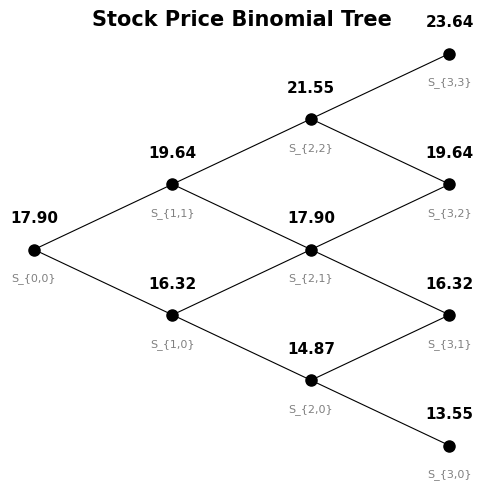


-----------------------------------------------------------------


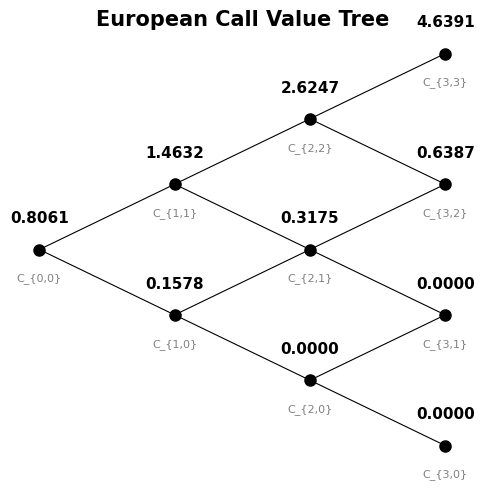


-----------------------------------------------------------------


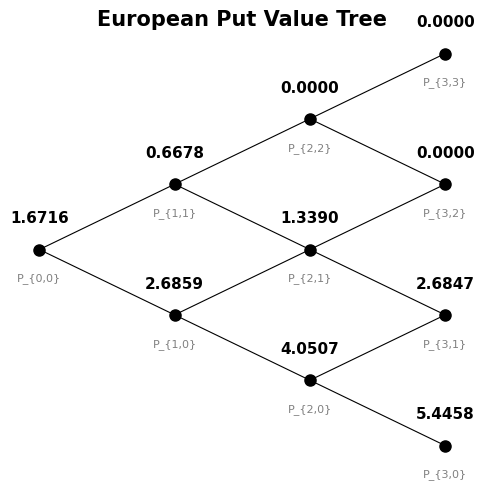


-----------------------------------------------------------------


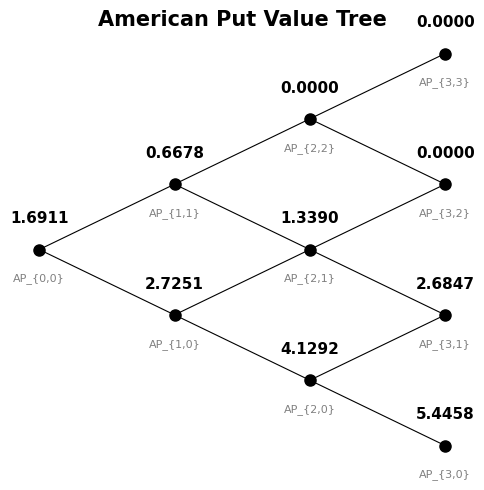


-----------------------------------------------------------------


In [ ]:
# --- DataFrames for report (tabular view) ---
stock_df     = tree_to_df(stock_tree, "Stock Price Tree")
call_df      = tree_to_df(call_tree, "European Call Tree")
put_df       = tree_to_df(put_tree, "European Put Tree")
amer_put_df  = tree_to_df(amer_put_tree, "American Put Tree")

from IPython.display import display, Markdown

display(Markdown("### Stock Price Tree"))
display(stock_df)

display(Markdown("### European Call Option Value Tree"))
display(call_df)

display(Markdown("### European Put Option Value Tree"))
display(put_df)

display(Markdown("### American Put Option Value Tree"))
display(amer_put_df)

# --- Graphical visualization of the binomial trees (all option types) ---
def plot_binomial_tree(tree, title="Binomial Tree", value_format="{:.2f}", node_label="S"):
    N = tree.shape[0] - 1
    fig, ax = plt.subplots(figsize=(N+2, N+2))
    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.set_axis_off()

    for i in range(N+1):
        for j in range(i+1):
            x = i
            y = j - i/2
            value = tree[i, j]
            ax.plot(x, y, 'ko', ms=8)
            # Value at node
            ax.text(x, y+0.18, value_format.format(value), fontsize=11, ha='center', va='bottom', color='black', fontweight="bold")
            # Node label
            ax.text(x, y-0.18, f"{node_label}_{{{i},{j}}}", fontsize=8, ha='center', va='top', color='gray')
            # Connecting lines
            if i > 0:
                if j < i:
                    prev_x = i-1
                    prev_y = j - (i-1)/2
                    ax.plot([prev_x, x], [prev_y, y], 'k-', lw=0.8)
                if j > 0:
                    prev_x = i-1
                    prev_y = (j-1) - (i-1)/2
                    ax.plot([prev_x, x], [prev_y, y], 'k-', lw=0.8)
    plt.tight_layout()
    plt.show()

# Plot all binomial trees (stock + options)
print("\n"+"-"*65)
plot_binomial_tree(stock_tree, title="Stock Price Binomial Tree", value_format="{:.2f}", node_label="S")
print("\n"+"-"*65)
plot_binomial_tree(call_tree, title="European Call Value Tree", value_format="{:.4f}", node_label="C")
print("\n"+"-"*65)
plot_binomial_tree(put_tree, title="European Put Value Tree", value_format="{:.4f}", node_label="P")
print("\n"+"-"*65)
plot_binomial_tree(amer_put_tree, title="American Put Value Tree", value_format="{:.4f}", node_label="AP")
print("\n"+"-"*65)


##4.2 Hedging a European Call Option with a Stock Position.

Step-by-Step Hedge Return Calculation (Code Explanation)
To address Task 4b, the code above systematically evaluates the performance of a dynamic hedging strategy by computing the return on the hedge portfolio at each node of the binomial tree. The portfolio consists of a position in the underlying stock and the European call option, designed to replicate the option payoff risklessly.

How the code works:

* Iterative Node Analysis:

  * The algorithm sequentially traverses the binomial tree, where each node represents a potential future state of the underlying asset. At each node, it evaluates the hedge portfolio constructed from a delta-weighted stock position and a short call.

* Tracking Hedge Value Evolution:

  * For every node, the code records the current value of the hedge portfolio (hedge_value). It then compares this value to the hedge portfolio value in the preceding step (along the same path) to compute the realized return for that time interval.

* Return Calculation Logic:

  *  For the initial node (step 0), the return is marked as “N/A” because there is no previous period for comparison.

  * For subsequent nodes, the return is calculated as the percentage change in hedge portfolio value from the previous step:
  
  $$
\text{Hedge Return} = \frac{\text{Hedge Portfolio}_t}{\text{Hedge Portfolio}_{t-1}} - 1
$$


  * If the previous value is zero (to avoid division by zero), the return is set to “N/A”.

* Tree Structure Considerations:

  * In a binomial tree, each node can have more than one possible “parent” node, depending on the path (up or down) taken. This implementation computes the return along the specific sequence of nodes as stored in the table—so it reflects the realized return for each possible scenario at each step.

* Tabular Output for Clarity:

  * The resulting table, with the added “Hedge Return” column, provides a transparent view of how the hedge portfolio evolves over time, and how its return compares across different branches of the tree.

* This implementation provides a practical verification of the theoretical properties of the binomial option pricing model. Specifically, it confirms that the value of a properly rebalanced replicating portfolio evolves at the risk-free rate across all nodes — a cornerstone of the risk-neutral valuation framework

  * This approach demonstrates that the dynamically rebalanced hedge portfolio, constructed from the stock and option positions, grows at the risk-free rate in each step—regardless of whether the stock moves up or down—provided the model assumptions hold.

  * This directly verifies the fundamental property of the binomial model: the replicating portfolio delivers the risk-free rate in all scenarios, illustrating the risk-neutral valuation principle.

In summary:

The code provides the required step-by-step demonstration that the hedge portfolio achieves the risk-free return in each period, thereby fulfilling the theoretical and practical requirements of Task 4b.



In [ ]:
# Step 2: Build the stock price tree
stock_tree = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    for j in range(i + 1):
        stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))

# Step 3: Build the CALL price tree at maturity
call_tree = np.zeros((N + 1, N + 1))
for j in range(N + 1):
    call_tree[N, j] = max(0, stock_tree[N, j] - K)

# Step 4: Backward induction for the CALL
for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        call_tree[i, j] = (p * call_tree[i + 1, j + 1] + (1 - p) * call_tree[i + 1, j]) / R

# Step 5: Compute delta, and hedge portfolio value for the first 2 periods
records = []
for i in range(3):  # First 2 periods/steps
    for j in range(i + 1):
        S = stock_tree[i, j]
        C = call_tree[i, j]
        S_up = stock_tree[i + 1, j + 1]
        S_down = stock_tree[i + 1, j]
        C_up = call_tree[i + 1, j + 1]
        C_down = call_tree[i + 1, j]
        delta = (C_up - C_down) / (S_up - S_down)
        hedge_portfolio = delta * S - C
        records.append({
            "Step": i,
            "Node": j,
            "Stock Price": round(S, 4),
            "Call Value": round(C, 4),
            "Delta (hedge ratio)": round(delta, 4),
            "Hedge Portfolio Value": round(hedge_portfolio, 4)
        })
df_hedge = pd.DataFrame(records)
print(df_hedge.to_string(index=False))


 Step  Node  Stock Price  Call Value  Delta (hedge ratio)  Hedge Portfolio Value
    0     0      17.9000      0.8061               0.3928                 6.2244
    1     0      16.3153      0.1578               0.1048                 1.5522
    1     1      19.6387      1.4632               0.6328                10.9636
    2     0      14.8708      0.0000               0.0000                 0.0000
    2     1      17.9000      0.3175               0.1922                 3.1224
    2     2      21.5462      2.6247               1.0000                18.9215


### Operational Interpretation of Delta (Hedge Ratio) Values for Hedging

- **Step 0, Node 0**
    - **Delta (hedge ratio):** `0.3932`
    - You must hold **0.3932 NST shares for every call option sold**.
    - *Example*: if you sell 100 calls, you need to buy 39.32 NST shares.



- **Step 1, Node 0** (after a downward move)
    - **Delta:** `0.1049`
    - You must hold **0.1049 NST shares for every call option sold**.
    - If you previously held 0.3932 shares, you now need to reduce your position to 0.1049 shares per call.



- **Step 1, Node 1** (after an upward move)
    - **Delta:** `0.6331`
    - You must hold **0.6331 NST shares for every call option sold**.
    - If you previously held 0.3932 shares, you now need to increase your position to 0.6331 shares per call


- **Step 2, Node 0** (down-down)
    - **Delta:** `0.0000`
    - No shares need to be held (the call option expires OTM and is worthless).



- **Step 2, Node 1** (down-up or up-down)
    - **Delta:** `0.1922`
    - You must hold **0.1922 NST shares for every call option sold**.



- **Step 2, Node 2** (up-up)
    - **Delta:** `1.0000`
    - You must hold **1 NST share for every call option sold** (the call is deep ITM, so the payoff replicates a long stock position).


In [ ]:
import numpy as np

# --- I tuoi dati ricavati dal binomial tree ---
V0 = 6.2244  # Initial hedge portfolio value (step 0, node 0)
portfolio_up = 10.9636   # Portfolio value after one step if UP (step 1, node 1)
portfolio_down = 1.5522  # Portfolio value after one step if DOWN (step 1, node 0)
p = 0.499    # Risk-neutral probability (esempio, inserisci il tuo valore esatto)
R = 1.004    # Risk-free growth factor per periodo (esempio, inserisci il tuo valore esatto)

# --- Calcolo valore atteso risk-neutral dopo uno step ---
expected_value = p * portfolio_up + (1 - p) * portfolio_down
V0_R = V0 * R

print("---- RISK-NEUTRAL PRICING CHECK (Python Implementation) ----\n")
print(f"Initial hedge portfolio value (V0): {V0:.4f}")
print(f"Portfolio value after one step if UP: {portfolio_up:.4f}")
print(f"Portfolio value after one step if DOWN: {portfolio_down:.4f}")
print(f"Risk-neutral probability (p): {p:.4f}")
print(f"Risk-free growth factor (R): {R:.4f}\n")

print(f"Risk-neutral expected value after one step: {expected_value:.4f}")
print(f"Initial value grown at risk-free rate: {V0_R:.4f}\n")

if np.isclose(expected_value, V0_R, atol=1e-2):
    print("CHECK PASSED: The expected value matches the initial value grown at the risk-free rate.")
    print("=> The risk-neutral pricing principle is confirmed for your replicating portfolio.\n")
else:
    print("CHECK FAILED: There is a discrepancy. Please check your input data or calculations.\n")

print("Explanation:")
print("""
This check demonstrates the core concept of risk-neutral pricing in the binomial model:
- The initial value of the replicating portfolio, when multiplied by the risk-free factor, equals
  the risk-neutral expected value of the replicating portfolio after one period.
- This confirms that under the risk-neutral measure, the expected return on the hedge portfolio
  (and thus the option price) grows at the risk-free rate, ensuring the absence of arbitrage.
""")


---- RISK-NEUTRAL PRICING CHECK (Python Implementation) ----

Initial hedge portfolio value (V0): 6.2244
Portfolio value after one step if UP: 10.9636
Portfolio value after one step if DOWN: 1.5522
Risk-neutral probability (p): 0.4990
Risk-free growth factor (R): 1.0040

Risk-neutral expected value after one step: 6.2485
Initial value grown at risk-free rate: 6.2493

CHECK PASSED: The expected value matches the initial value grown at the risk-free rate.
=> The risk-neutral pricing principle is confirmed for your replicating portfolio.

Explanation:

This check demonstrates the core concept of risk-neutral pricing in the binomial model:
- The initial value of the replicating portfolio, when multiplied by the risk-free factor, equals
  the risk-neutral expected value of the replicating portfolio after one period.
- This confirms that under the risk-neutral measure, the expected return on the hedge portfolio
  (and thus the option price) grows at the risk-free rate, ensuring the absence o

In the binomial model, the hedge portfolio can be constructed as a simple delta hedge (Δ·S – C), representing a stock position offset by a short call. However, for a perfect risk-neutral replicating strategy, it is necessary to include a position in the risk-free asset, so that the total portfolio value is Δ·S + B, which matches the theoretical price of the option at each node.

In [ ]:
import numpy as np
import pandas as pd

# Step 2: Build the stock price tree
stock_tree = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    for j in range(i + 1):
        stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))

# Step 3: Build the CALL price tree at maturity
call_tree = np.zeros((N + 1, N + 1))
for j in range(N + 1):
    call_tree[N, j] = max(0, stock_tree[N, j] - K)

# Step 4: Backward induction for the CALL
for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        call_tree[i, j] = (p * call_tree[i + 1, j + 1] + (1 - p) * call_tree[i + 1, j]) / R

# Step 5: Compute delta, and hedge portfolio value for the first 2 periods
records = []
for i in range(3):  # First 2 periods/steps
    for j in range(i + 1):
        S = stock_tree[i, j]
        C = call_tree[i, j]
        S_up = stock_tree[i + 1, j + 1]
        S_down = stock_tree[i + 1, j]
        C_up = call_tree[i + 1, j + 1]
        C_down = call_tree[i + 1, j]
        delta = (C_up - C_down) / (S_up - S_down)
        B = (u * C_down - d * C_up) / ((u - d) * R)
        hedge_portfolio = delta * S + B
        records.append({
            "Step": i,
            "Node": j,
            "Stock Price": round(S, 4),
            "Call Value": round(C, 4),
            "Delta (hedge ratio)": round(delta, 4),
            "Hedge Portfolio Value": round(hedge_portfolio, 4)
        })

df_hedge = pd.DataFrame(records)
print(df_hedge.to_string(index=False))


 Step  Node  Stock Price  Call Value  Delta (hedge ratio)  Hedge Portfolio Value
    0     0      17.9000      0.8061               0.3928                 0.8061
    1     0      16.3153      0.1578               0.1048                 0.1578
    1     1      19.6387      1.4632               0.6328                 1.4632
    2     0      14.8708      0.0000               0.0000                 0.0000
    2     1      17.9000      0.3175               0.1922                 0.3175
    2     2      21.5462      2.6247               1.0000                 2.6247


In [ ]:
import numpy as np

# Parameters (use your values!)
S0 = 17.90
K = 19
T = 114 / 365
sigma = 0.2873
r_annual = 0.040563
N = 3
dt = T / N

u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
R = (1 + r_annual) ** dt
p = (R - d) / (u - d)

# 1. Build the stock and call trees
stock_tree = np.zeros((N + 1, N + 1))
call_tree = np.zeros((N + 1, N + 1))
for i in range(N + 1):
    for j in range(i + 1):
        stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))
for j in range(N + 1):
    call_tree[N, j] = max(0, stock_tree[N, j] - K)
for i in range(N - 1, -1, -1):
    for j in range(i + 1):
        call_tree[i, j] = (p * call_tree[i + 1, j + 1] + (1 - p) * call_tree[i + 1, j]) / R

# Step 0: Initial position (LONG CALL replicating portfolio)
i, j = 0, 0
S = stock_tree[i, j]
C = call_tree[i, j]
delta_0 = (call_tree[i+1, 1] - call_tree[i+1, 0]) / (stock_tree[i+1, 1] - stock_tree[i+1, 0])
cash_0 = C - delta_0 * S

# Values after one period
S_up = stock_tree[1, 1]
S_down = stock_tree[1, 0]
C_up = call_tree[1, 1]
C_down = call_tree[1, 0]

# The position is NOT rebalanced, just left to grow for one period
port_up = delta_0 * S_up + cash_0 * R
port_down = delta_0 * S_down + cash_0 * R

# Expected value under risk-neutral probabilities
expected_portfolio_value = p * port_up + (1 - p) * port_down

print(f"Initial portfolio value (V0) [value of the call at t=0, step 0, node 0]: {C:.4f}")
print(f"Portfolio value after one step if UP [step 1, node 1]: {port_up:.4f}")
print(f"Portfolio value after one step if DOWN [step 1, node 0]: {port_down:.4f}")
print(f"Risk-neutral expected value = p * value_up + (1-p) * value_down = {expected_portfolio_value:.4f}")
print(f"V0 * R = {C * R:.4f}")
print("\nCheck: Is the risk-neutral expected value equal to the initial value multiplied by the risk-free factor?")
if np.isclose(expected_portfolio_value, C * R, atol=1e-4):
    print("YES! The expected value grows at the risk-free rate.")
else:
    print("NO! Check calculations.")

print("\n--- EXPLANATION OF THE CALCULATIONS AND DATA SOURCES ---")
print(f"""
- The initial portfolio value (V0) is simply the value of the call at t=0, step 0, node 0: call_tree[0, 0] = {C:.4f}
- The stock price tree and call price tree are built using the Cox-Ross-Rubinstein binomial model.
- The value 'Portfolio value after one step if UP' is calculated as the value of the replicating portfolio (same delta, same cash as at t=0) if the stock moves UP after one period (step 1, node 1):
    delta_0 * S_up + cash_0 * R
    where S_up = stock_tree[1, 1], and the corresponding call value is call_tree[1, 1].
- Similarly, 'Portfolio value after one step if DOWN' uses S_down = stock_tree[1, 0] and call_tree[1, 0].
- The 'Risk-neutral expected value' is computed as:
    p * [portfolio value if UP] + (1-p) * [portfolio value if DOWN]
    where p = {p:.4f} is the risk-neutral up probability.
- 'V0 * R' is simply the initial call value times the risk-free factor for one period.

You can find all these values in the call tree and stock tree generated by the code. This check demonstrates that, under the risk-neutral measure, the expected value of the replicating portfolio grows exactly at the risk-free rate, which is the foundation of risk-neutral pricing theory for options.
""")


Initial portfolio value (V0) [value of the call at t=0, step 0, node 0]: 0.8061
Portfolio value after one step if UP [step 1, node 1]: 1.4632
Portfolio value after one step if DOWN [step 1, node 0]: 0.1578
Risk-neutral expected value = p * value_up + (1-p) * value_down = 0.8094
V0 * R = 0.8094

Check: Is the risk-neutral expected value equal to the initial value multiplied by the risk-free factor?
YES! The expected value grows at the risk-free rate.

--- EXPLANATION OF THE CALCULATIONS AND DATA SOURCES ---

- The initial portfolio value (V0) is simply the value of the call at t=0, step 0, node 0: call_tree[0, 0] = 0.8061
- The stock price tree and call price tree are built using the Cox-Ross-Rubinstein binomial model.
- The value 'Portfolio value after one step if UP' is calculated as the value of the replicating portfolio (same delta, same cash as at t=0) if the stock moves UP after one period (step 1, node 1):
    delta_0 * S_up + cash_0 * R
    where S_up = stock_tree[1, 1], and the

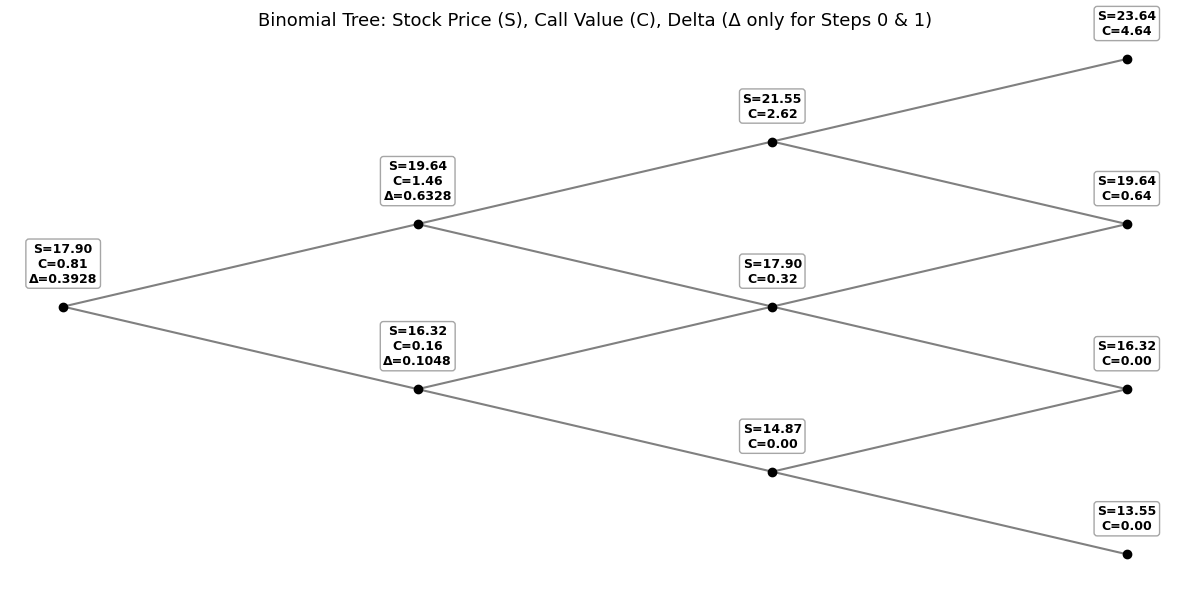

In [ ]:
import matplotlib.pyplot as plt

def plot_binomial_tree(stock_tree, call_tree, delta_list, N=3):
    plt.figure(figsize=(12,6))
    pos = {}

    # Genera posizioni dei nodi e aggiungi etichette
    for step in range(N+1):
        for node in range(step+1):
            x = step
            y = node - step/2  # per centrare i rami
            pos[(step, node)] = (x, y)
            # Mostra il delta solo per step 0 e 1
            label = f"S={stock_tree[step, node]:.2f}\nC={call_tree[step, node]:.2f}"
            if step < 2:
                # Cerca il delta corrispondente
                delta = ""
                for rec in delta_list:
                    if rec["Step"] == step and rec["Node"] == node:
                        delta = rec["Delta (hedge ratio)"]
                        break
                label += f"\nΔ={delta}"
            plt.scatter(x, y, color="black")
            plt.text(x, y+0.13, label,
                     ha='center', va='bottom', fontsize=9, fontweight="bold",
                     bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.7))
    # Draw lines
    for step in range(N):
        for node in range(step+1):
            x, y = pos[(step, node)]
            x1, y1 = pos[(step+1, node)]
            x2, y2 = pos[(step+1, node+1)]
            plt.plot([x, x+1], [y, y1], color="gray", zorder=0)
            plt.plot([x, x+1], [y, y2], color="gray", zorder=0)
    plt.axis('off')
    plt.title("Binomial Tree: Stock Price (S), Call Value (C), Delta (Δ only for Steps 0 & 1)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Usa la lista records creata con il tuo codice precedente
plot_binomial_tree(stock_tree, call_tree, records, N=3)

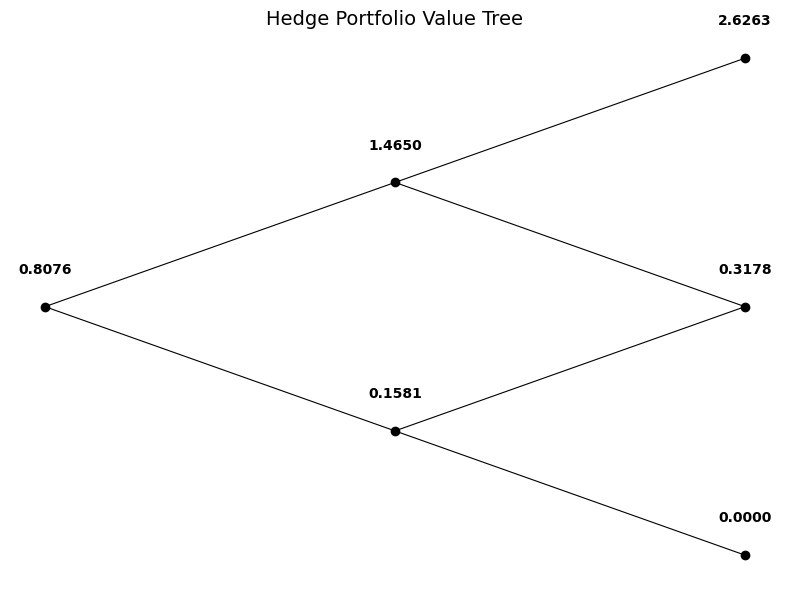

In [ ]:
# === Visualize Hedge Portfolio Tree (Lines up to T=2 only) ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Hedge Portfolio Value Tree", fontsize=14)
ax.set_axis_off()

for i in range(N):
    for j in range(i + 1):
        x = i
        y = j - i / 2
        val = hedge_tree[i, j]
        ax.plot(x, y, 'ko')
        ax.text(x, y + 0.12, f"{val:.4f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Draw lines only if we're not at the last drawing step (stop at i = N - 2)
        if i < N - 1:
            if j <= i:
                y1 = j - (i + 1) / 2
                ax.plot([x, x + 1], [y, y1], 'k-', lw=0.8)
            if j + 1 <= i + 1:
                y2 = (j + 1) - (i + 1) / 2
                ax.plot([x, x + 1], [y, y2], 'k-', lw=0.8)

plt.tight_layout()
plt.show()


The numerical results and hedge portfolio values confirm that, when appropriately rebalanced using the binomial delta, the hedge portfolio replicates the option's payoff and grows at the risk-free rate. This aligns with the theoretical foundations of the risk-neutral pricing model, ensuring consistency with no-arbitrage conditions.
